<a href="https://colab.research.google.com/github/codyub/ESAA/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용데이터를 이용한 K-Means클러스터링 및 이미지 변환을 활용한 모델링과 XAI

* 데이콘 '월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회' 데이터 활용
https://dacon.io/competitions/official/235713/data
* 참고 논문 "신용 데이터의 이미지 변환을 활용한 합성곱 신경망과 설명 가능한 인공지능(XAI)을 이용한 개인신용평가"

## 1. 데이터 및 라이브러리 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir("/content/drive/MyDrive/ESAA/2023-1/프로젝트3_신용카드연체예측/data/") # 유빈
#os.chdir("/content/drive/MyDrive/ESAA/OB/OB1조/방학프로젝트/data") #재령
#os.chdir("/content/drive/MyDrive/OB1조/방학프로젝트/data") #세영

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

## 2. EDA

In [ ]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
train.head()

gender car reality  child_num  income_total           income_type  \
index                                                                     
0          F   N       N          0      202500.0  Commercial associate   
1          F   N       Y          1      247500.0  Commercial associate   
2          M   Y       Y          0      450000.0               Working   
3          F   N       Y          0      202500.0  Commercial associate   
4          F   Y       Y          0      157500.0         State servant   

                            edu_type     family_type           house_type  \
index                                                                       
0                   Higher education         Married  Municipal apartment   
1      Secondary / secondary special  Civil marriage    House / apartment   
2                   Higher education         Married    House / apartment   
3      Secondary / secondary special         Married    House / apartment   
4                   Higher education         Married    House / apartment   

       DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
index                                                                    
0          -13899          -4709           1           0      0      0   
1          -11380          -1540           1           0      0      1   
2          -19087          -4434           1           0      1      0   
3          -15088          -2092           1           0      1      0   
4          -15037          -2105           1           0      0      0   

        occyp_type  family_size  begin_month  credit  
index                                                 
0              NaN          2.0         -6.0     1.0  
1         Laborers          3.0         -5.0     1.0  
2         Managers          2.0        -22.0     2.0  
3      Sales staff          2.0        -37.0     0.0  
4         Managers          2.0        -26.0     2.0

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [ ]:
sub = pd.read_csv("sample_submission.csv", index_col=0)
sub.head()

0  1  2
index         
26457  0  0  0
26458  0  0  0
26459  0  0  0
26460  0  0  0
26461  0  0  0

### A. 변수별 기본적인 시각화

변수 의미
* index
* gender: 성별
* car: 차량 소유 여부
* reality: 부동산 소유 여부
* child_num: 자녀 수
* income_total: 연간 소득
* income_type: 소득 분류
* edu_type: 교육 수준
* family_type: 결혼 여부
* house_type: 생활 방식
* DAYS_BIRTH: 출생일
* DAYS_EMPLOYED: 업무 시작일
* FLAG_MOBIL: 핸드폰 소유 여부
* work_phone: 업무용 전화 소유 여부
* phone: 전화 소유 여부
* email: 이메일 소유 여부
* occyp_type: 직업 유형
* family_size: 가족 규모
* begin_month: 신용카드 발급 월
* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

1. target 변수
* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
* 낮을수록 높은 신용의 신용카드 사용자를 의미함

<Axes: xlabel='credit', ylabel='count'>

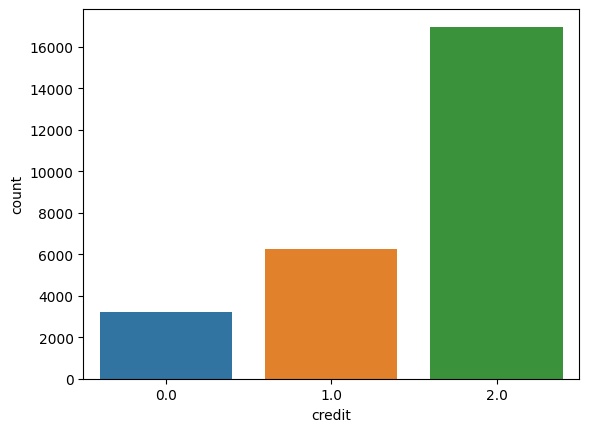

In [ ]:
sns.countplot(x='credit', data=train)

In [ ]:
# 타깃값 분포
## 비율
print('0의 비율', round(len(train[train['credit']==0])/len(train), 4))
print('1의 비율', round(len(train[train['credit']==1])/len(train),4))
print('2의 비율', round(len(train[train['credit']==2])/len(train),4))

0의 비율 0.1218
1의 비율 0.2369
2의 비율 0.6413


* 신용수준이 낮을수록 수가 많아짐

2. 연속형 변수

In [ ]:
num_col = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'child_num']

income_total (연간소득)

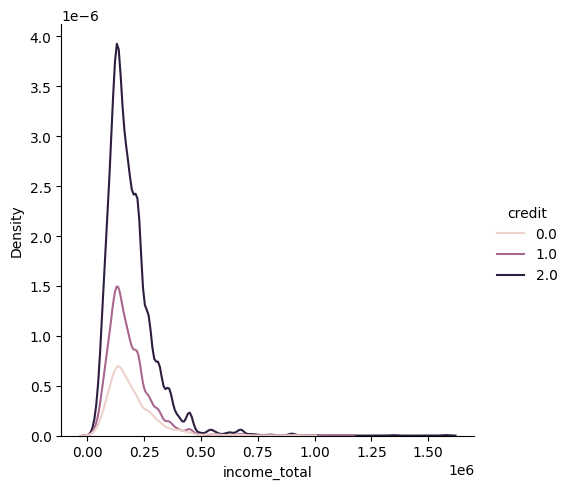

In [ ]:
sns.displot(x='income_total', data=train, hue='credit', kind='kde')

In [ ]:
train['income_total'].value_counts()

135000.0    3164
157500.0    2233
180000.0    2225
112500.0    2178
225000.0    2170
            ... 
57150.0        1
51750.0        1
87448.5        1
227250.0       1
191700.0       1
Name: income_total, Length: 249, dtype: int64

* 소득이 높을수록 신용점수가 높은 풀이 많다.

DAYS_BIRTH (출생일)
  * 데이터 수집 당시부터 역으로 셈한다.
  * 전처리 아이디어 ) 연단위로 환산하여 나이 계산한다.
  --> 범주형 변수 'age_range' 만들기

<Axes: xlabel='DAYS_BIRTH', ylabel='Count'>

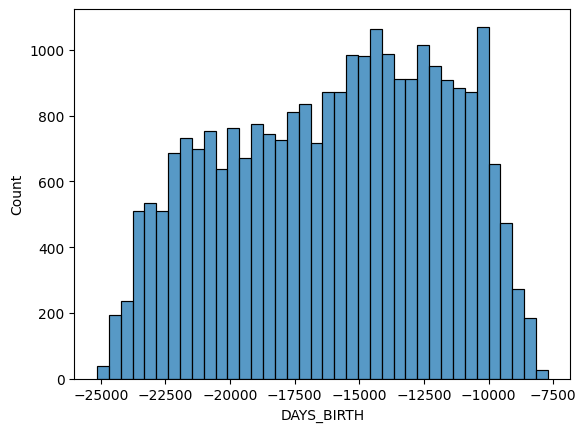

In [ ]:
sns.histplot(x='DAYS_BIRTH', data=train)

<Axes: xlabel='age', ylabel='Count'>

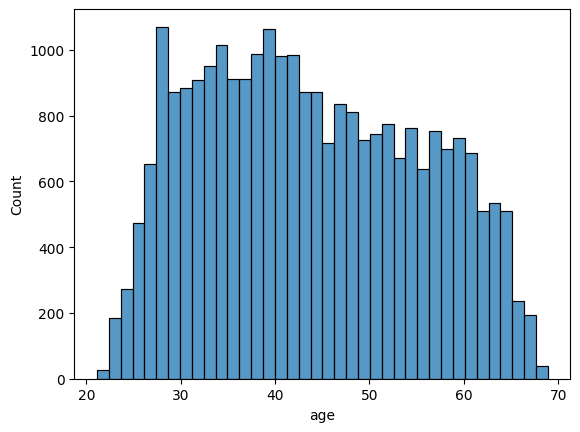

In [ ]:
train_1 = train.copy()
train_1['age'] = abs(train['DAYS_BIRTH']/365)
sns.histplot(x='age', data=train_1)

In [ ]:
train_1['age'].describe()

count    26457.000000
mean        43.720696
std         11.511203
min         21.109589
25%         34.098630
50%         42.594521
75%         53.235616
max         68.909589
Name: age, dtype: float64

EDA 분석을 위해 10살 간격으로 나이대를 나타내는 변수를 만들어줌.

In [ ]:
age_bin = [20,30,40,50,60,70]
age_label = ['20s', '30s', '40s', '50s', '60s']
train_1['age_range'] = pd.cut(train_1['age'], age_bin, labels = age_label)

<Axes: xlabel='age_range', ylabel='count'>

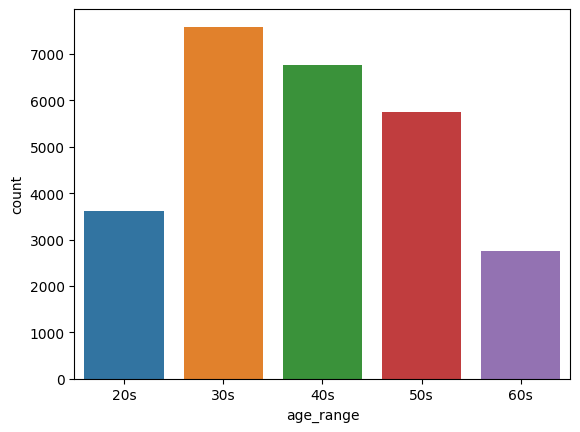

In [ ]:
sns.countplot(x='age_range', data=train_1)

DAYS_EMPLOYED (업무시작일)
  * 데이터 수집 당시부터 역으로 셈한다.
  * 전처리 아이디어) 연도나 월 단위로 환산

<Axes: xlabel='DAYS_EMPLOYED', ylabel='Count'>

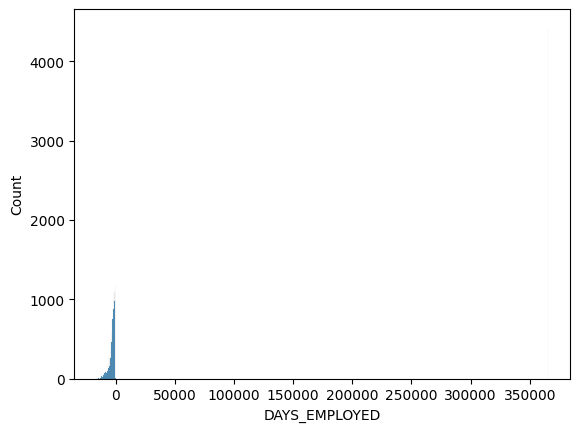

In [ ]:
sns.histplot(x='DAYS_EMPLOYED', data=train)

<ipython-input-22-752a2610ea0b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['DAYS_EMPLOYED'])


<Axes: xlabel='DAYS_EMPLOYED', ylabel='Density'>

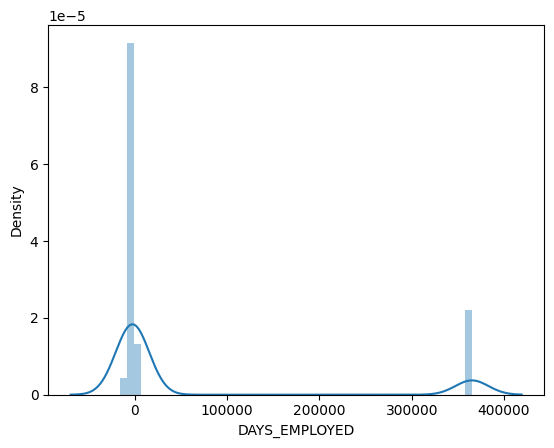

In [ ]:
sns.distplot(train['DAYS_EMPLOYED'])

<Axes: xlabel='DAYS_EMPLOYED'>

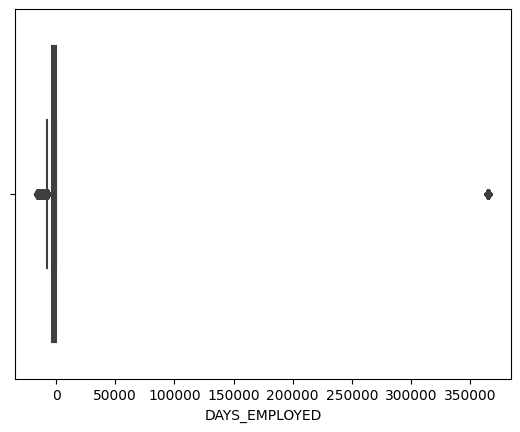

In [ ]:
sns.boxplot(x='DAYS_EMPLOYED', data=train)

* 이상치 있음 -> 제거

In [ ]:
train['DAYS_EMPLOYED'].value_counts()

 365243    4438
-401         57
-1539        47
-200         45
-2087        44
           ... 
-10475        1
-2202         1
-2552         1
-680          1
-4973         1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

In [ ]:
train[train['DAYS_EMPLOYED']== 365243]['income_type']

index
14       Pensioner
18       Pensioner
21       Pensioner
24       Pensioner
46       Pensioner
           ...    
26431    Pensioner
26432    Pensioner
26439    Pensioner
26441    Pensioner
26443    Pensioner
Name: income_type, Length: 4438, dtype: object

In [ ]:
train[train['income_type']== 'Pensioner']

gender car reality  child_num  income_total income_type  \
index                                                           
14         F   N       Y          0      157500.0   Pensioner   
18         F   N       Y          0      216000.0   Pensioner   
21         F   N       N          0      157500.0   Pensioner   
24         F   N       N          0      202500.0   Pensioner   
46         F   N       N          0      135000.0   Pensioner   
...      ...  ..     ...        ...           ...         ...   
26431      F   N       Y          0      225000.0   Pensioner   
26432      F   Y       Y          0       72000.0   Pensioner   
26439      F   N       Y          0       67500.0   Pensioner   
26441      F   N       Y          0       90000.0   Pensioner   
26443      F   N       Y          0       90000.0   Pensioner   

                            edu_type           family_type         house_type  \
index                                                                           
14     Secondary / secondary special  Single / not married  House / apartment   
18     Secondary / secondary special               Married  House / apartment   
21     Secondary / secondary special               Married  House / apartment   
24     Secondary / secondary special  Single / not married  House / apartment   
46     Secondary / secondary special                 Widow  House / apartment   
...                              ...                   ...                ...   
26431  Secondary / secondary special                 Widow  House / apartment   
26432  Secondary / secondary special               Married  House / apartment   
26439  Secondary / secondary special               Married  House / apartment   
26441              Incomplete higher             Separated  House / apartment   
26443  Secondary / secondary special  Single / not married  House / apartment   

       DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
index                                                                    
14         -22922         365243           1           0      1      0   
18         -23113         365243           1           0      0      0   
21         -21253         365243           1           0      1      0   
24         -22361         365243           1           0      1      0   
46         -21100         365243           1           0      1      0   
...           ...            ...         ...         ...    ...    ...   
26431      -21151         365243           1           0      0      1   
26432      -22314         365243           1           0      1      0   
26439      -19238         365243           1           0      0      0   
26441      -24129         365243           1           0      0      0   
26443      -22286         365243           1           0      0      0   

      occyp_type  family_size  begin_month  credit  
index                                               
14           NaN          1.0        -41.0     2.0  
18           NaN          2.0        -37.0     2.0  
21           NaN          2.0         -7.0     2.0  
24           NaN          1.0         -5.0     2.0  
46           NaN          1.0        -24.0     2.0  
...          ...          ...          ...     ...  
26431        NaN          1.0        -60.0     1.0  
26432        NaN          2.0        -17.0     1.0  
26439        NaN          2.0        -57.0     2.0  
26441        NaN          1.0        -43.0     2.0  
26443        NaN          1.0        -21.0     1.0  

[4449 rows x 19 columns]

업무시작일을 연 단위로 바꿈

<Axes: xlabel='emp_year', ylabel='Count'>

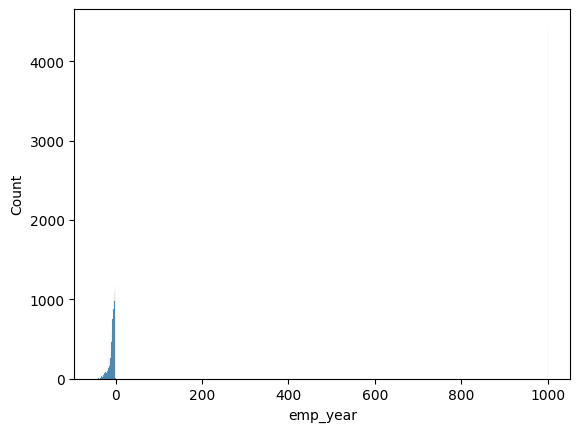

In [ ]:
train_1['emp_year'] = train['DAYS_EMPLOYED']/365
sns.histplot(x='emp_year', data=train_1)

업무시작일을 월 단위로 바꿈

<Axes: xlabel='emp_month', ylabel='Count'>

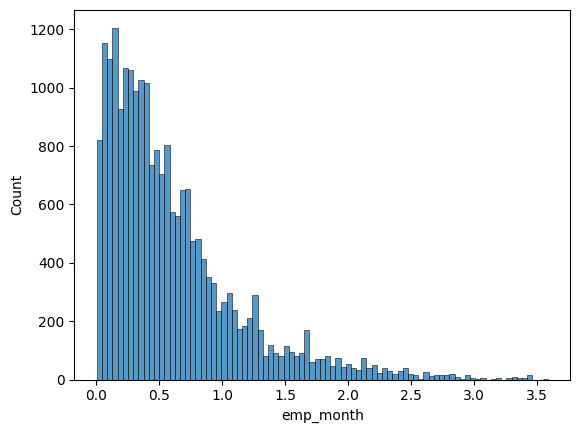

In [ ]:
train_1['emp_month'] = abs((train['DAYS_EMPLOYED'][train['DAYS_EMPLOYED']<50000]/365)/12)
sns.histplot(x='emp_month', data=train_1)

begin_month (신용카드 발급월)

<Axes: xlabel='begin_month', ylabel='Count'>

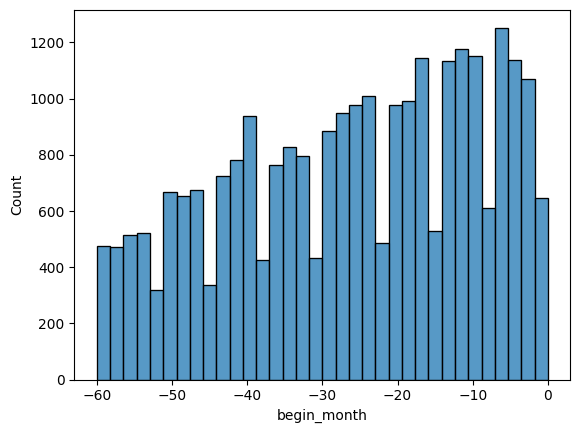

In [ ]:
sns.histplot(x='begin_month', data=train)

child_num (자녀 수)

In [ ]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

<Axes: xlabel='child_num', ylabel='Count'>

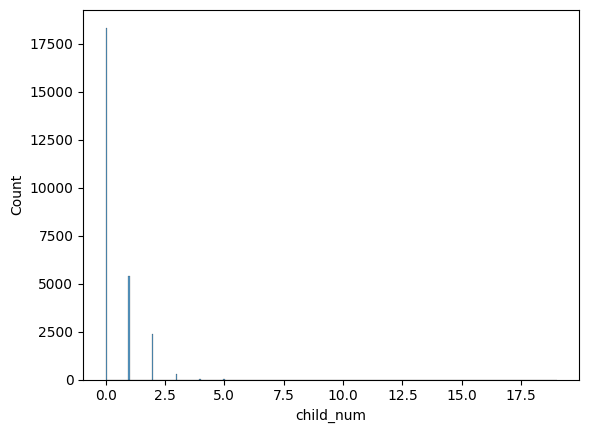

In [ ]:
sns.histplot(train['child_num'])

5명 초과는 이상치 처리해도 될듯

3. 범주형 변수

In [ ]:
train['FLAG_MOBIL'].value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

* 모든 사람들이 핸드폰 소유하고 있으므로 분석에 배제시킴

In [ ]:
cat_col = ['gender', 'car', 'reality', 'work_phone',
           'phone', 'email', 'income_type', 'edu_type',
           'family_type', 'house_type', 'occyp_type',
           'family_size']
print(len(cat_col))

12


In [ ]:
for i in range(len(cat_col)):
  print(cat_col[i])
  print(train[cat_col[i]].value_counts(ascending=True))
  print("\n")

gender
M     8760
F    17697
Name: gender, dtype: int64


car
Y    10047
N    16410
Name: car, dtype: int64


reality
N     8627
Y    17830
Name: reality, dtype: int64


work_phone
1     5946
0    20511
Name: work_phone, dtype: int64


phone
1     7785
0    18672
Name: phone, dtype: int64


email
1     2415
0    24042
Name: email, dtype: int64


income_type
Student                     7
State servant            2154
Pensioner                4449
Commercial associate     6202
Working                 13645
Name: income_type, dtype: int64


edu_type
Academic degree                     23
Lower secondary                    257
Incomplete higher                 1020
Higher education                  7162
Secondary / secondary special    17995
Name: edu_type, dtype: int64


family_type
Widow                    1103
Separated                1539
Civil marriage           2123
Single / not married     3496
Married                 18196
Name: family_type, dtype: int64


house_type
Co-op apartmen

범주형 변수 분포 시각화

두개의 범주만 가진 변수

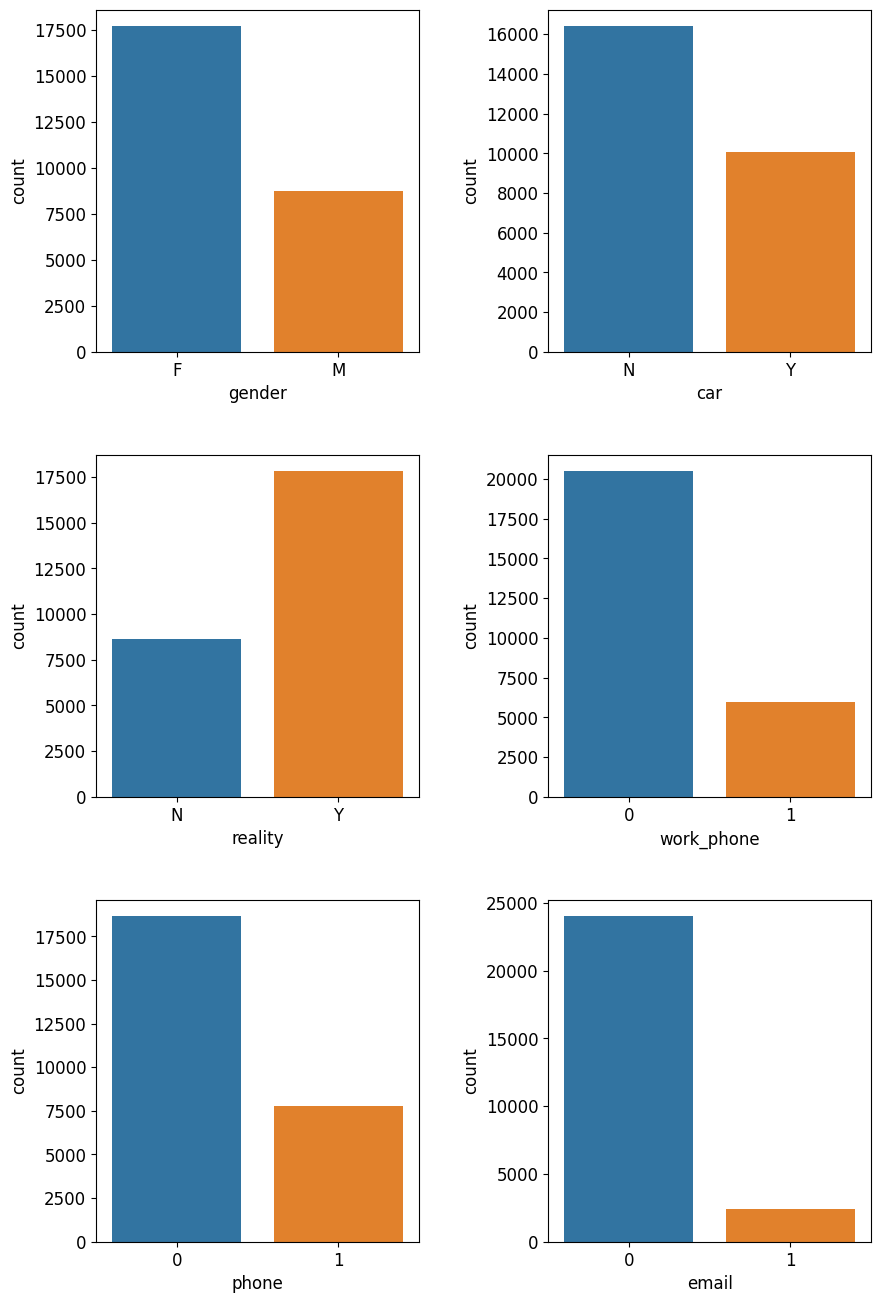

In [ ]:
import matplotlib.gridspec as gridspec # 여러 그래프를 격자 형태로 배치

mpl.rc('font', size=12)
grid = gridspec.GridSpec(3,2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

for idx, ft in enumerate(cat_col[0:6]):
  ax = plt.subplot(grid[idx])
  sns.countplot(x=ft, data=train_1, ax=ax)
  # sns.barplot(x=ft, y='credit', data=train, ax=ax)

3개 이상의 범주 가진 변수

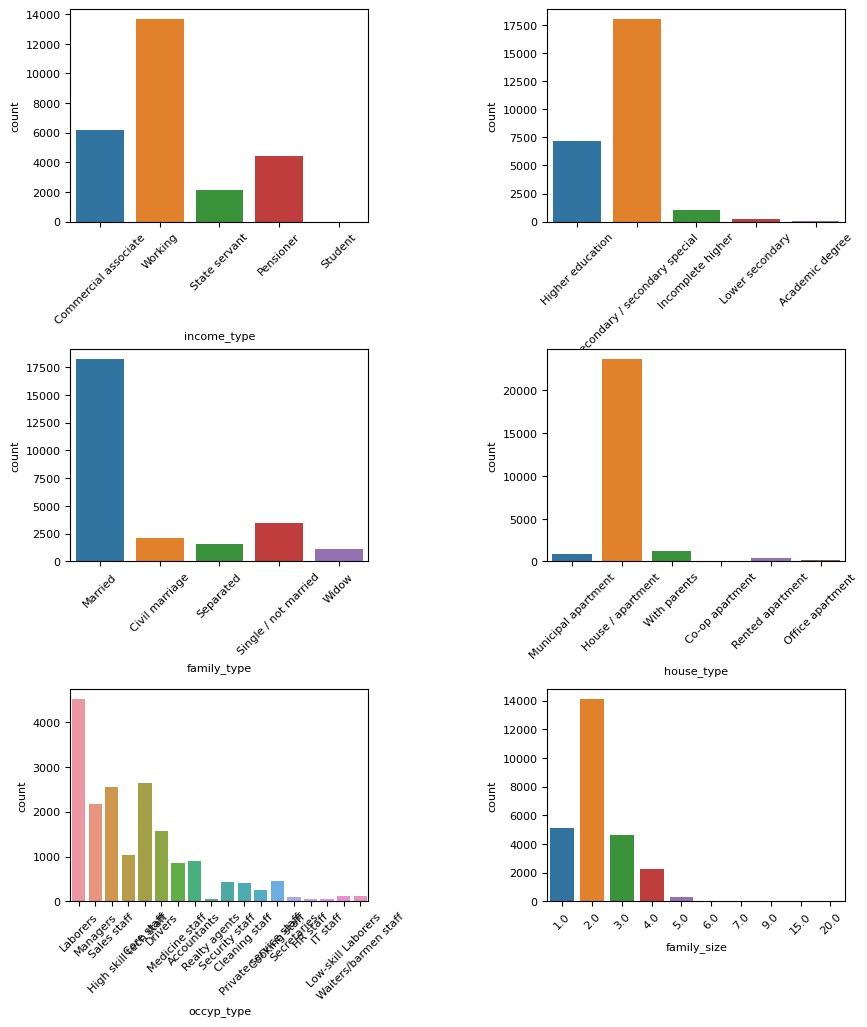

In [ ]:
mpl.rc('font', size=8)
grid = gridspec.GridSpec(4,2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.6, hspace=0.6) # 서브플롯 간 좌우/상하 여백 설정

for idx, ft in enumerate(cat_col[6:]):
  ax = plt.subplot(grid[idx])
  sns.countplot(x=ft, data=train_1, ax=ax)
  plt.xticks(rotation=45)

* 전처리 아이디어
  * house_type 범주를 house / non-house 2개로 바꾸기
  * occyp_type 4~5개로 범주 통합시키기
  * flag_mobil 드롭시키기
  * family_size 5명이상인 그룹 하나로 묶기

특정 X값이 타겟값에 치우치는지 확인

In [ ]:
def write_percent(ax, total_size):
  # 도형 객체를 순회하며 막대 상단에 타깃값 비율 표시
  for patch in ax.patches:
    h = patch.get_height() #도형 높이 (데이터 개수)
    w = patch.get_width() #도형 너비
    left_coord = patch.get_x() #도형 왼쪽 테두리의 x축 위치
    percent = h/total_size *100 #타깃값 비율

    # 텍스트 입력
    ax.text(x=left_coord + w/2.0, #x축위치
            y=h + total_size*0.001, #y축위치
            s= f'{percent:1.1f}%', #입력텍스트
            ha='center') #가운데정렬

먼저 두개의 범주만 가진 변수

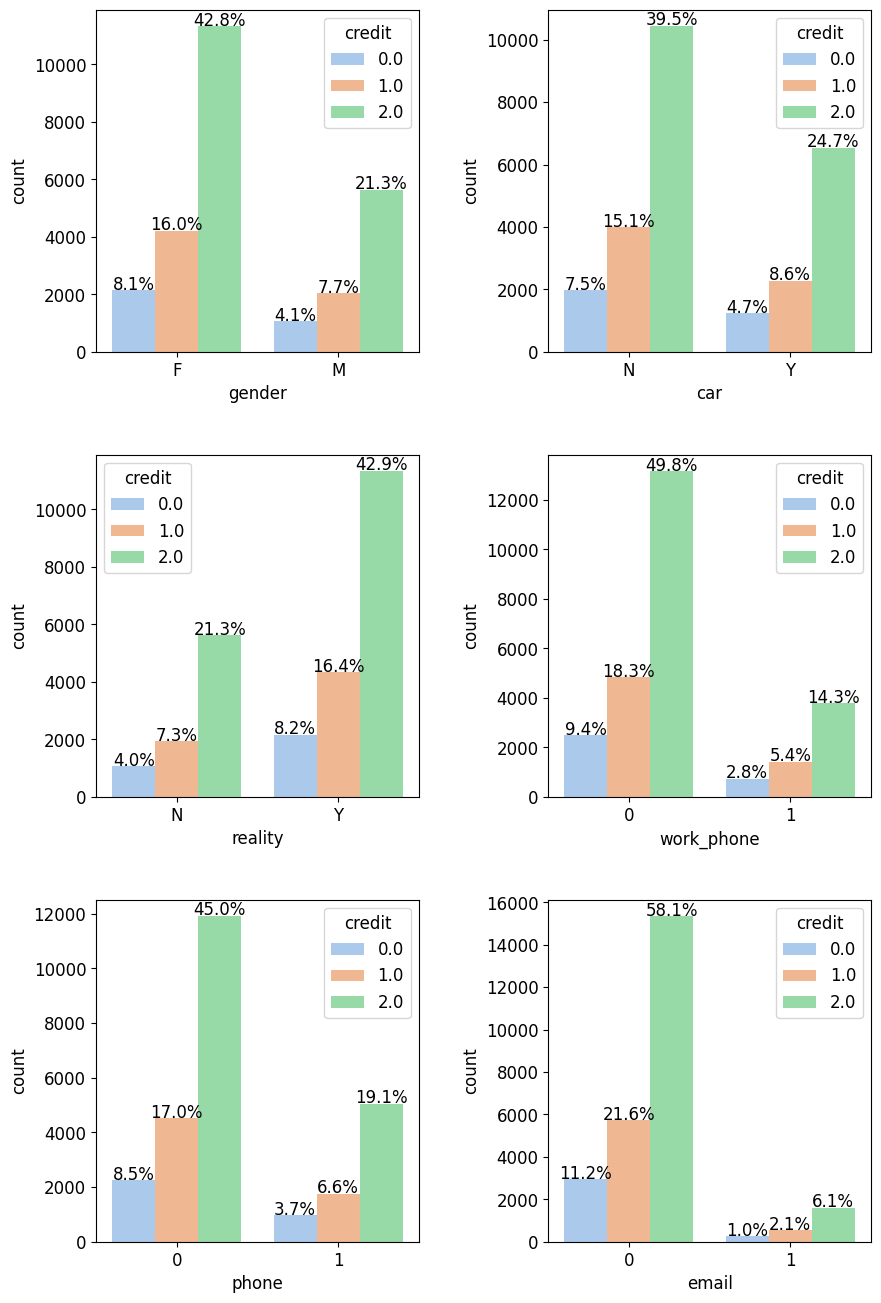

In [ ]:
mpl.rc('font', size=12)
grid = gridspec.GridSpec(3,2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

for idx, ft in enumerate(cat_col[0:6]):
  ax = plt.subplot(grid[idx])
  sns.countplot(x=ft, data=train_1, hue='credit', palette='pastel', ax=ax)
  write_percent(ax, len(train))

다음으로 3개 이상의 범주를 가진 변수

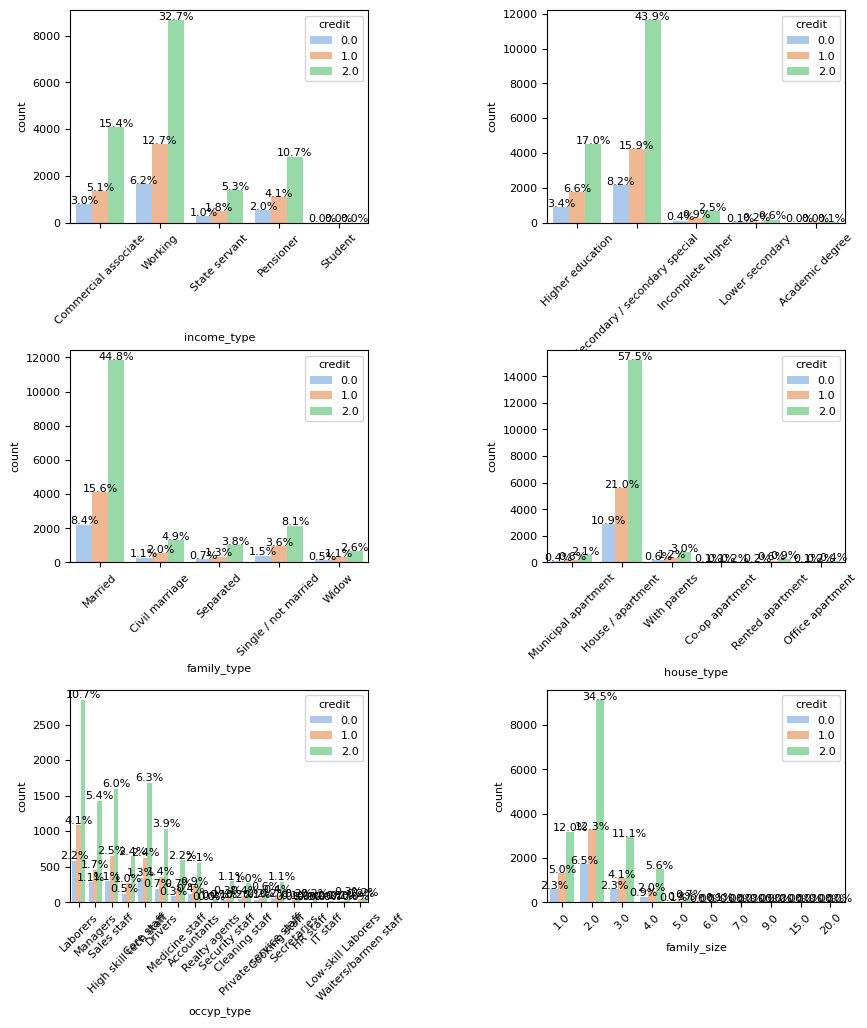

In [ ]:
mpl.rc('font', size=8)
grid = gridspec.GridSpec(4,2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.6, hspace=0.6) # 서브플롯 간 좌우/상하 여백 설정

for idx, ft in enumerate(cat_col[6:]):
  ax = plt.subplot(grid[idx])
  plt.xticks(rotation=45)
  sns.countplot(x=ft, data=train_1, hue='credit', palette='pastel', ax=ax)
  write_percent(ax, len(train_1))

* 모든 변수에서 경향성이 같다.
* 모든 변수 내 모든 범주에서 신용정도가 낮을수록 사람이 많아진다.
* 비율차이가 비슷한 변수는 없으므로 제거할 변수는 x

4. 상관관계
* 숫자형 변수끼리만

<ipython-input-40-3e7c54f6591b>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data = train_2.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')


<Axes: >

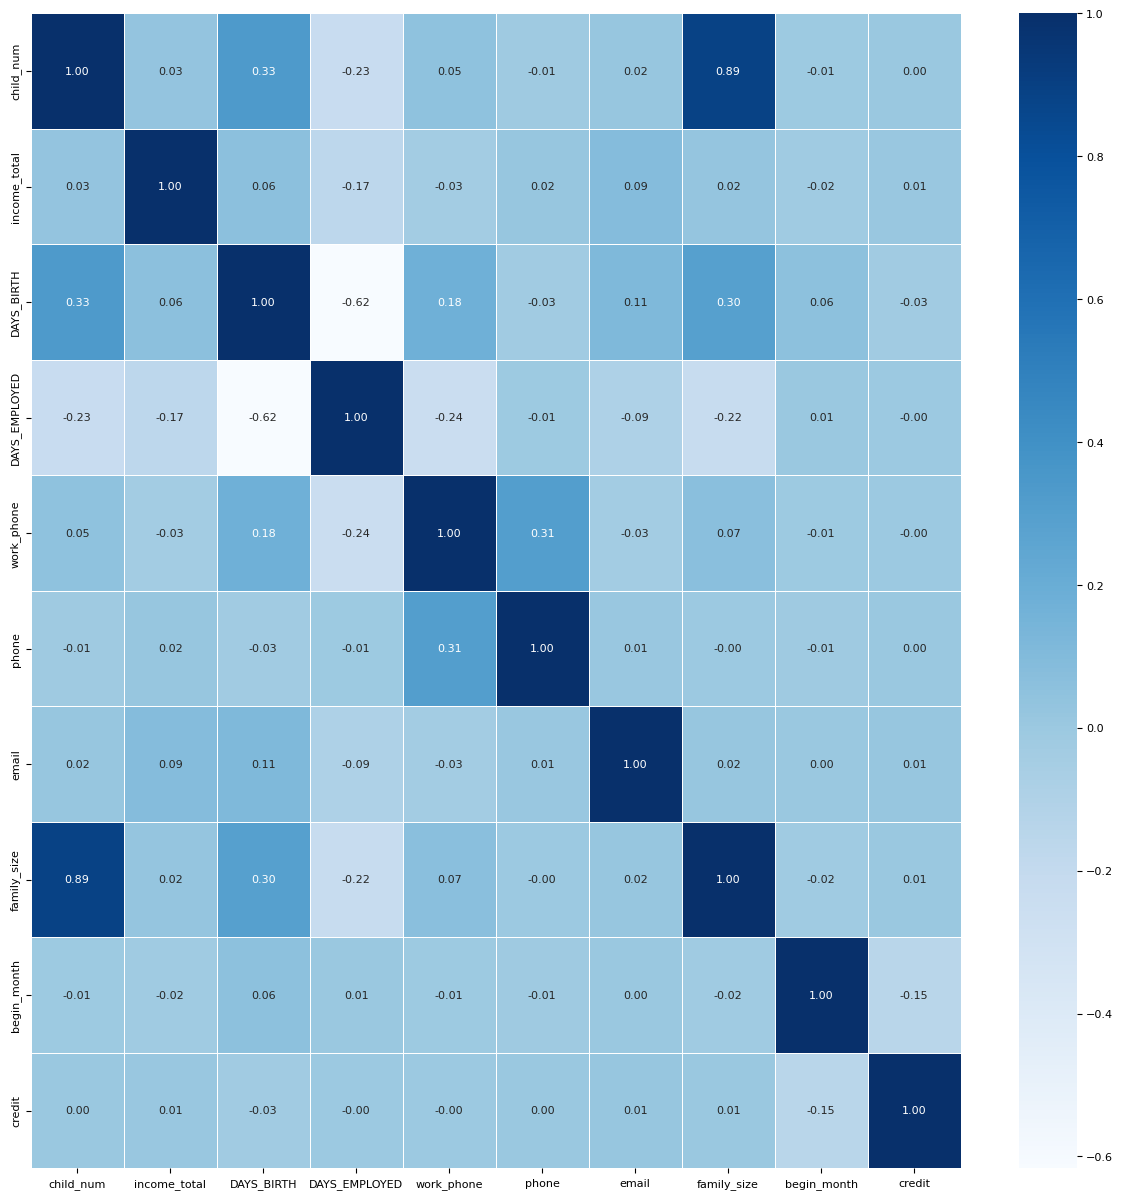

In [ ]:
# 원본데이터에서 flag_mobil만 제외
train_1 = train.drop('FLAG_MOBIL', axis=1)
# credit 열을 맨 마지막으로
a = train_1.columns.tolist()
id = a.index('credit')
new_col = a[:id] + a[id+1:]
new_col.append(a[id])
train_2 = train_1[new_col]

plt.figure(figsize=(15,15))
sns.heatmap(data = train_2.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

* credit과 다른 열과의 상관관계가 그리 높지 않다.

### B. 중복 행 확인

중복 행 제거: 기본 사용법
df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
subset : 중복값을 검사할 열 입니다. 기본적으로 모든 열을 검사합니다.
keep : {first / last} 중복제거를할때 남길 행입니다. first면 첫값을 남기고 last면 마지막 값을 남깁니다.
inplace : 원본을 변경할지의 여부입니다.
ignore_index : 원래 index를 무시할지 여부입니다. True일 경우 0,1,2, ... , n으로 부여됩니다.

결측값 제거: 기본 사용법
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
axis : {0: index / 1: columns} 결측치 제거를 진행 할 레이블입니다.
how : {'any' : 존재하면 제거 / 'all' : 모두 결측치면 제거} 제거할 유형입니다. 포함만 시켜도 제거할지, 전무 NA여야 제거할지 정할 수 있습니다.
tresh : 결측값이 아닌 값이 몇 개 미만일 경우에만 적용시키는 인수 입니다.
예를들어, tresh값이 3이라면 결측값이 아닌 값이 3개 미만일 경우에만 dropna메서드를 수행합니다.
subset : dropna메서드를 수행할 레이블을 지정합니다.
inplace : 원본을 변경할지의 여부입니다.

1. 신용카드 연체 월수가 있던데, 같은 사람이 다른 기간동안 발급 받았을 수 있음 --> 어떠한 카드는 연체, 어떠한 카드는 연체가 아니면 이 경우 어떻게 되는가?
credit을 매기는 기준이 사람 그 자체인지,해당 발급받은 카드에 대한 것인지 모르겠음

In [ ]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [ ]:
train_drop = train.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24823 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         24823 non-null  object 
 1   car            24823 non-null  object 
 2   reality        24823 non-null  object 
 3   child_num      24823 non-null  int64  
 4   income_total   24823 non-null  float64
 5   income_type    24823 non-null  object 
 6   edu_type       24823 non-null  object 
 7   family_type    24823 non-null  object 
 8   house_type     24823 non-null  object 
 9   DAYS_BIRTH     24823 non-null  int64  
 10  DAYS_EMPLOYED  24823 non-null  int64  
 11  FLAG_MOBIL     24823 non-null  int64  
 12  work_phone     24823 non-null  int64  
 13  phone          24823 non-null  int64  
 14  email          24823 non-null  int64  
 15  occyp_type     17210 non-null  object 
 16  family_size    24823 non-null  float64
 17  begin_month    24823 non-null  float64
 18  credit

In [ ]:
train_drop.corr()

<ipython-input-48-d6f19e38629a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_drop.corr()


child_num  income_total  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
child_num       1.000000      0.032285    0.331754      -0.227693         NaN   
income_total    0.032285      1.000000    0.066064      -0.167335         NaN   
DAYS_BIRTH      0.331754      0.066064    1.000000      -0.616934         NaN   
DAYS_EMPLOYED  -0.227693     -0.167335   -0.616934       1.000000         NaN   
FLAG_MOBIL           NaN           NaN         NaN            NaN         NaN   
work_phone      0.051133     -0.035599    0.180552      -0.242288         NaN   
phone          -0.011168      0.017112   -0.029736      -0.003829         NaN   
email           0.015755      0.089086    0.109664      -0.089546         NaN   
family_size     0.890896      0.023976    0.297787      -0.223216         NaN   
begin_month    -0.004932     -0.018807    0.059369       0.004297         NaN   
credit          0.005825      0.005274   -0.024332      -0.002725         NaN   

               work_phone     phone     email  family_size  begin_month  \
child_num        0.051133 -0.011168  0.015755     0.890896    -0.004932   
income_total    -0.035599  0.017112  0.089086     0.023976    -0.018807   
DAYS_BIRTH       0.180552 -0.029736  0.109664     0.297787     0.059369   
DAYS_EMPLOYED   -0.242288 -0.003829 -0.089546    -0.223216     0.004297   
FLAG_MOBIL            NaN       NaN       NaN          NaN          NaN   
work_phone       1.000000  0.309731 -0.031348     0.068687    -0.007943   
phone            0.309731  1.000000  0.011768    -0.000480    -0.012399   
email           -0.031348  0.011768  1.000000     0.014652     0.002873   
family_size      0.068687 -0.000480  0.014652     1.000000    -0.020316   
begin_month     -0.007943 -0.012399  0.002873    -0.020316     1.000000   
credit          -0.002498  0.003388  0.012133     0.009937    -0.143323   

                 credit  
child_num      0.005825  
income_total   0.005274  
DAYS_BIRTH    -0.024332  
DAYS_EMPLOYED -0.002725  
FLAG_MOBIL          NaN  
work_phone    -0.002498  
phone          0.003388  
email          0.012133  
family_size    0.009937  
begin_month   -0.143323  
credit         1.000000

In [ ]:
train.corr()

<ipython-input-49-0bc27f030cd9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


child_num  income_total  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
child_num       1.000000      0.032186    0.332816      -0.228159         NaN   
income_total    0.032186      1.000000    0.064155      -0.166478         NaN   
DAYS_BIRTH      0.332816      0.064155    1.000000      -0.616776         NaN   
DAYS_EMPLOYED  -0.228159     -0.166478   -0.616776       1.000000         NaN   
FLAG_MOBIL           NaN           NaN         NaN            NaN         NaN   
work_phone      0.051521     -0.034207    0.178752      -0.241827         NaN   
phone          -0.010555      0.019013   -0.029247      -0.007749         NaN   
email           0.016120      0.089882    0.111238      -0.091090         NaN   
family_size     0.890530      0.023839    0.298108      -0.223077         NaN   
begin_month    -0.007229     -0.018047    0.057306       0.007964         NaN   
credit          0.004081      0.008555   -0.025187      -0.003798         NaN   

               work_phone     phone     email  family_size  begin_month  \
child_num        0.051521 -0.010555  0.016120     0.890530    -0.007229   
income_total    -0.034207  0.019013  0.089882     0.023839    -0.018047   
DAYS_BIRTH       0.178752 -0.029247  0.111238     0.298108     0.057306   
DAYS_EMPLOYED   -0.241827 -0.007749 -0.091090    -0.223077     0.007964   
FLAG_MOBIL            NaN       NaN       NaN          NaN          NaN   
work_phone       1.000000  0.310256 -0.031048     0.068705    -0.008563   
phone            0.310256  1.000000  0.012494    -0.000132    -0.014286   
email           -0.031048  0.012494  1.000000     0.016122     0.002320   
family_size      0.068705 -0.000132  0.016122     1.000000    -0.023032   
begin_month     -0.008563 -0.014286  0.002320    -0.023032     1.000000   
credit          -0.003134  0.003452  0.014812     0.008227    -0.147477   

                 credit  
child_num      0.004081  
income_total   0.008555  
DAYS_BIRTH    -0.025187  
DAYS_EMPLOYED -0.003798  
FLAG_MOBIL          NaN  
work_phone    -0.003134  
phone          0.003452  
email          0.014812  
family_size    0.008227  
begin_month   -0.147477  
credit         1.000000

- 그나마 corr이 높은 것은 begin_month: 신용카드를 발급하기 시작한 날
- 신용카드 발급한지 오래되었을 수록 credit이 커질 확률이 높음. -> 당연한거 아닌가? 모루겠따..
- 다중공선성이 보이는 데이터는 family size와 child num말고 없음

- 약 2천건의 데이터가 중복되어 있음을 알 수 있었음
- 중복되는 데이터를 ID를 만들어서 왜 굳이 살렸었을까?

- 신용카드 발급이 아니라, 신용카드 사용자 개개인에게 credit이 매겨진다고 가정하고, 적용하기 위해서 begin_month를 drop 해보자

In [ ]:
train_begin = train_drop

In [ ]:
train_begin.drop('begin_month', axis=1, inplace=True)

<ipython-input-51-a0c446915b50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_begin.drop('begin_month', axis=1, inplace=True)


In [ ]:
train_begin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24823 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         24823 non-null  object 
 1   car            24823 non-null  object 
 2   reality        24823 non-null  object 
 3   child_num      24823 non-null  int64  
 4   income_total   24823 non-null  float64
 5   income_type    24823 non-null  object 
 6   edu_type       24823 non-null  object 
 7   family_type    24823 non-null  object 
 8   house_type     24823 non-null  object 
 9   DAYS_BIRTH     24823 non-null  int64  
 10  DAYS_EMPLOYED  24823 non-null  int64  
 11  FLAG_MOBIL     24823 non-null  int64  
 12  work_phone     24823 non-null  int64  
 13  phone          24823 non-null  int64  
 14  email          24823 non-null  int64  
 15  occyp_type     17210 non-null  object 
 16  family_size    24823 non-null  float64
 17  credit         24823 non-null  float64
dtypes: flo

In [ ]:
train_begin.corr()

<ipython-input-53-7e5850ab30ad>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_begin.corr()


child_num  income_total  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
child_num       1.000000      0.032285    0.331754      -0.227693         NaN   
income_total    0.032285      1.000000    0.066064      -0.167335         NaN   
DAYS_BIRTH      0.331754      0.066064    1.000000      -0.616934         NaN   
DAYS_EMPLOYED  -0.227693     -0.167335   -0.616934       1.000000         NaN   
FLAG_MOBIL           NaN           NaN         NaN            NaN         NaN   
work_phone      0.051133     -0.035599    0.180552      -0.242288         NaN   
phone          -0.011168      0.017112   -0.029736      -0.003829         NaN   
email           0.015755      0.089086    0.109664      -0.089546         NaN   
family_size     0.890896      0.023976    0.297787      -0.223216         NaN   
credit          0.005825      0.005274   -0.024332      -0.002725         NaN   

               work_phone     phone     email  family_size    credit  
child_num        0.051133 -0.011168  0.015755     0.890896  0.005825  
income_total    -0.035599  0.017112  0.089086     0.023976  0.005274  
DAYS_BIRTH       0.180552 -0.029736  0.109664     0.297787 -0.024332  
DAYS_EMPLOYED   -0.242288 -0.003829 -0.089546    -0.223216 -0.002725  
FLAG_MOBIL            NaN       NaN       NaN          NaN       NaN  
work_phone       1.000000  0.309731 -0.031348     0.068687 -0.002498  
phone            0.309731  1.000000  0.011768    -0.000480  0.003388  
email           -0.031348  0.011768  1.000000     0.014652  0.012133  
family_size      0.068687 -0.000480  0.014652     1.000000  0.009937  
credit          -0.002498  0.003388  0.012133     0.009937  1.000000

In [ ]:
train_begin = train_begin.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [ ]:
train_begin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12099 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         12099 non-null  object 
 1   car            12099 non-null  object 
 2   reality        12099 non-null  object 
 3   child_num      12099 non-null  int64  
 4   income_total   12099 non-null  float64
 5   income_type    12099 non-null  object 
 6   edu_type       12099 non-null  object 
 7   family_type    12099 non-null  object 
 8   house_type     12099 non-null  object 
 9   DAYS_BIRTH     12099 non-null  int64  
 10  DAYS_EMPLOYED  12099 non-null  int64  
 11  FLAG_MOBIL     12099 non-null  int64  
 12  work_phone     12099 non-null  int64  
 13  phone          12099 non-null  int64  
 14  email          12099 non-null  int64  
 15  occyp_type     8433 non-null   object 
 16  family_size    12099 non-null  float64
 17  credit         12099 non-null  float64
dtypes: flo

- 데이터 수가 매우 감소함: 26456 -> 12099
- 이는 같은 정보를 가진 사람이 다른 날짜로 카드를 받았을 수 있다는 것을 의미함
- 의문: 다른 정보가 모두 같은 사람은 credit이 모두 같을까?

In [ ]:
train_begin.corr()

<ipython-input-56-7e5850ab30ad>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_begin.corr()


child_num  income_total  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
child_num       1.000000      0.026223    0.318520      -0.222131         NaN   
income_total    0.026223      1.000000    0.059721      -0.162112         NaN   
DAYS_BIRTH      0.318520      0.059721    1.000000      -0.612508         NaN   
DAYS_EMPLOYED  -0.222131     -0.162112   -0.612508       1.000000         NaN   
FLAG_MOBIL           NaN           NaN         NaN            NaN         NaN   
work_phone      0.051414     -0.034946    0.181835      -0.241929         NaN   
phone          -0.028144      0.013752   -0.044432       0.001282         NaN   
email           0.011014      0.087179    0.106694      -0.085693         NaN   
family_size     0.889919      0.024119    0.275934      -0.213433         NaN   
credit          0.000163     -0.012535   -0.013371       0.001956         NaN   

               work_phone     phone     email  family_size    credit  
child_num        0.051414 -0.028144  0.011014     0.889919  0.000163  
income_total    -0.034946  0.013752  0.087179     0.024119 -0.012535  
DAYS_BIRTH       0.181835 -0.044432  0.106694     0.275934 -0.013371  
DAYS_EMPLOYED   -0.241929  0.001282 -0.085693    -0.213433  0.001956  
FLAG_MOBIL            NaN       NaN       NaN          NaN       NaN  
work_phone       1.000000  0.295450 -0.038200     0.064466 -0.011967  
phone            0.295450  1.000000  0.003643    -0.015578 -0.006537  
email           -0.038200  0.003643  1.000000     0.005922  0.001986  
family_size      0.064466 -0.015578  0.005922     1.000000 -0.000436  
credit          -0.011967 -0.006537  0.001986    -0.000436  1.000000

In [ ]:
train_begin['income_total'] = np.log1p(train_begin['income_total'])

<ipython-input-57-20c864ccb2ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_begin['income_total'] = np.log1p(train_begin['income_total'])


In [ ]:
train_begin.corr()

<ipython-input-58-7e5850ab30ad>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_begin.corr()


child_num  income_total  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
child_num       1.000000      0.028165    0.318520      -0.222131         NaN   
income_total    0.028165      1.000000    0.100939      -0.202894         NaN   
DAYS_BIRTH      0.318520      0.100939    1.000000      -0.612508         NaN   
DAYS_EMPLOYED  -0.222131     -0.202894   -0.612508       1.000000         NaN   
FLAG_MOBIL           NaN           NaN         NaN            NaN         NaN   
work_phone      0.051414     -0.047456    0.181835      -0.241929         NaN   
phone          -0.028144     -0.001361   -0.044432       0.001282         NaN   
email           0.011014      0.092912    0.106694      -0.085693         NaN   
family_size     0.889919      0.020045    0.275934      -0.213433         NaN   
credit          0.000163     -0.015398   -0.013371       0.001956         NaN   

               work_phone     phone     email  family_size    credit  
child_num        0.051414 -0.028144  0.011014     0.889919  0.000163  
income_total    -0.047456 -0.001361  0.092912     0.020045 -0.015398  
DAYS_BIRTH       0.181835 -0.044432  0.106694     0.275934 -0.013371  
DAYS_EMPLOYED   -0.241929  0.001282 -0.085693    -0.213433  0.001956  
FLAG_MOBIL            NaN       NaN       NaN          NaN       NaN  
work_phone       1.000000  0.295450 -0.038200     0.064466 -0.011967  
phone            0.295450  1.000000  0.003643    -0.015578 -0.006537  
email           -0.038200  0.003643  1.000000     0.005922  0.001986  
family_size      0.064466 -0.015578  0.005922     1.000000 -0.000436  
credit          -0.011967 -0.006537  0.001986    -0.000436  1.000000

### C. 주제별로 변수를 묶어서 분석

1. 소득 관련 변수 (재령)       
  차량 소유 여부(car), 부동산 소유 여부(reality), 연간 소득(income_total), 소득 분류(income_type), 직업 유형(occyp_type)   
  +나이(DAYS_BIRTH -> age_range)

<Axes: xlabel='age', ylabel='Count'>

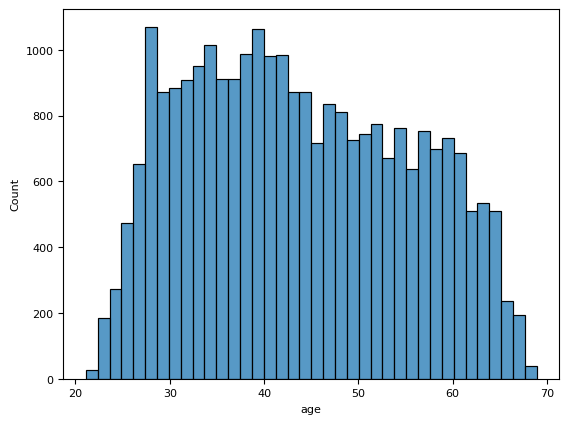

In [ ]:
train['age'] = abs(train['DAYS_BIRTH']/365)
sns.histplot(x='age', data=train)

In [ ]:
train['age'].describe()

count    26457.000000
mean        43.720696
std         11.511203
min         21.109589
25%         34.098630
50%         42.594521
75%         53.235616
max         68.909589
Name: age, dtype: float64

In [ ]:
age_bin = [20,30,40,50,60,70]
age_label = ['20대', '30대', '40대', '50대', '60대']
train['age_range'] = pd.cut(train['age'], age_bin, labels = age_label)

In [ ]:
train_1 = train[['car', 'reality', 'income_total', 'income_type', 'occyp_type', 'age_range', 'credit']]
train_1.head()

car reality  income_total           income_type   occyp_type age_range  \
index                                                                          
0       N       N      202500.0  Commercial associate          NaN       30대   
1       N       Y      247500.0  Commercial associate     Laborers       30대   
2       Y       Y      450000.0               Working     Managers       50대   
3       N       Y      202500.0  Commercial associate  Sales staff       40대   
4       Y       Y      157500.0         State servant     Managers       40대   

       credit  
index          
0         1.0  
1         1.0  
2         2.0  
3         0.0  
4         2.0

1) income_total ~ credit

<Axes: xlabel='credit', ylabel='income_total'>

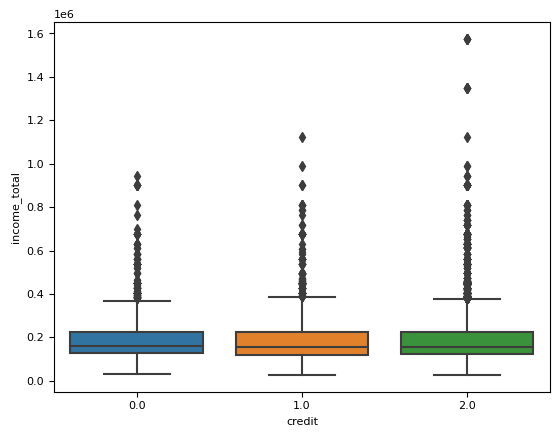

In [ ]:
sns.boxplot(x='credit', y='income_total', data=train_1)

* 전반적인 분포는 credit별로 차이가 없다.
* credit이 높아질수록 (신용이 낮아질수록) 소득분포 꼬리가 길게 나타난다.


2) income_total ~ credit ~ (X1)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


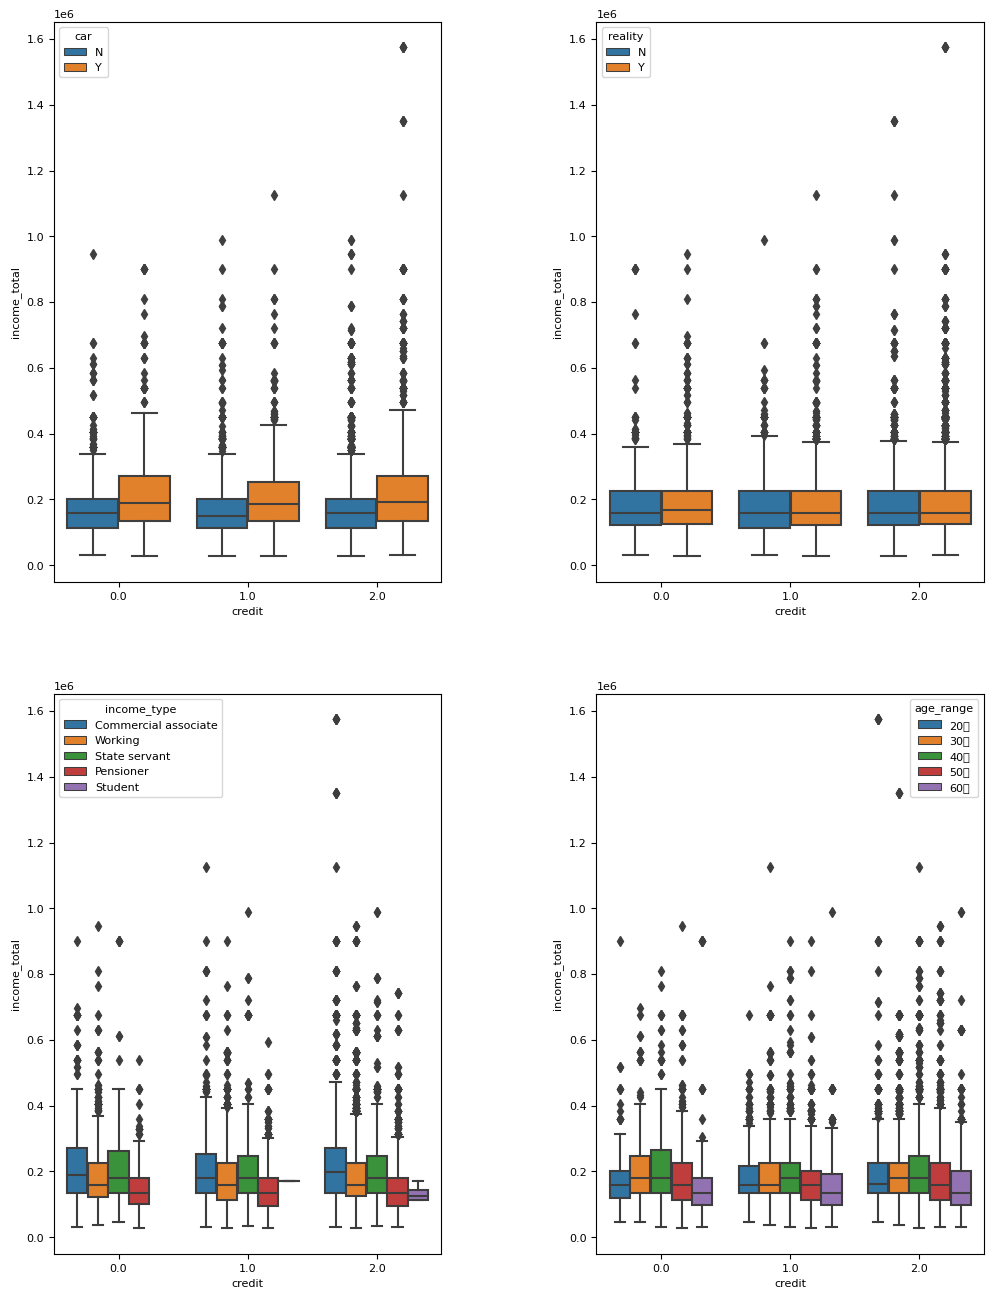

In [ ]:
mpl.rc('font', size=8)
grid = gridspec.GridSpec(2,2)
plt.figure(figsize=(12,16))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

train_2 = train_1[['car', 'reality', 'income_type', 'age_range', 'income_total', 'credit']]
# 범주형 변수 앞에 배치하고 뒤에 연속현 변수, 타겟변수 배치

for idx, ft in enumerate(train_2.columns[0:4]):
  ax = plt.subplot(grid[idx])
  sns.boxplot(x=train_2['credit'], y=train_2['income_total'], hue=ft, data=train_2, ax=ax)

* 범주를 하나 더 추가하여도    
  전반적인 분포는 credit별로 차이가 없다.
* car
  * 모든 credit 수준에서   
  차가 있는 그룹이 없는 그룹보다 소득수준이 높게 나타난다.
* reality
  * 모든 credit 수준에서
  부동산이 있든 없든 소득수준은 비슷하다.
* income_type
  * 모든 credit 수준에서
  자영업자, 공무원, 월급쟁이, 연금수령자 학생 순으로 소득수준이 높게 나타난다.
* age_range
  * 모든 credit 수준에서    
  20->40 소득수준이 높아지고 40->60 소득수준이 낮아지는 경향이   
  공통적으로 나타난다.


3) income_toal ~ credit ~ (X1 * X2)

 **income_toal ~ credit ~ (car * reality)**

In [ ]:
train_3 = train_2[train_2['income_total']<=800000]

<Axes: title={'center': 'income_total'}, xlabel='[car, reality]'>

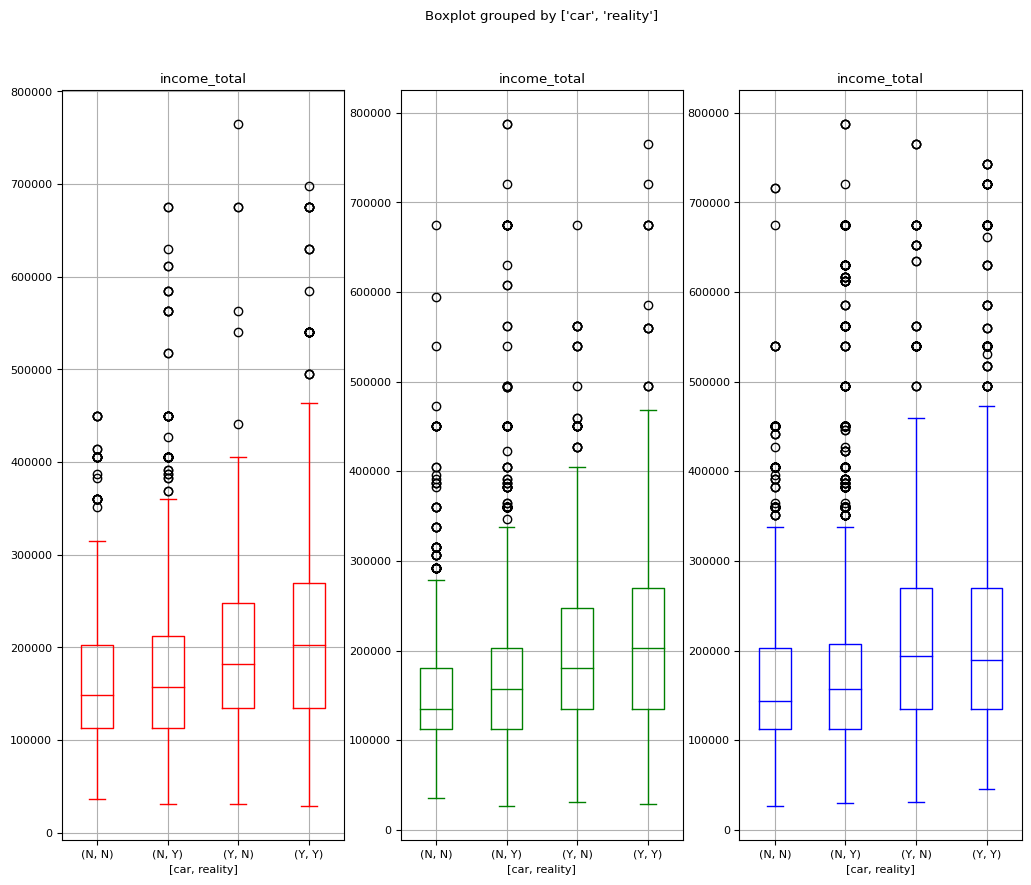

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,10))

train_3[train_3['credit']==0].boxplot(column=['income_total'], by=['car','reality'], ax= axes[0], color='r')
train_3[train_3['credit']==1].boxplot(column=['income_total'], by=['car','reality'], ax= axes[1], color='g')
train_3[train_3['credit']==2].boxplot(column=['income_total'], by=['car','reality'], ax= axes[2], color='b')

* 모든 credit 수준 내에서      
  차,부동산이 아예 없는 그룹 < 둘중에 하나 있는 그룹 < 둘다 있는 그룹 으로 갈수록     
  inome_total이 커진다.  
* 모든 credit 수준에서 income_total 범위가 비슷하게 나타난다.

NO

**income_total ~ credit ~ (reality * age_range)**

<Axes: title={'center': 'income_total'}, xlabel='[age_range, reality]'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


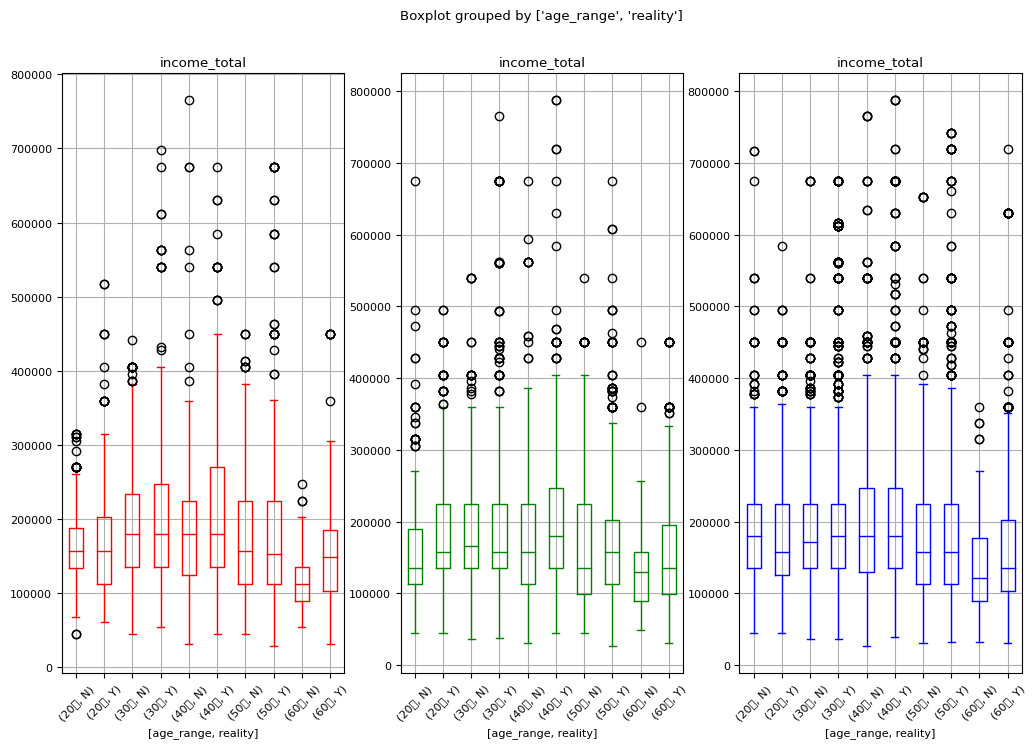

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,8))

train_3[train_3['credit']==0].boxplot(column=['income_total'], by=['age_range','reality'], ax= axes[0], color='r', rot=45)
train_3[train_3['credit']==1].boxplot(column=['income_total'], by=['age_range','reality'], ax= axes[1], color='g', rot=45)
train_3[train_3['credit']==2].boxplot(column=['income_total'], by=['age_range','reality'], ax= axes[2], color='b', rot=45)

* reality 요인을 넣기 전에는 둥근산모양이었음
* 모든 credit 수준에서
  부동산이 있는 60대의 income_total이 반등한다.
* credit=2 (신용도가 가장 낮은 그룹)에서
  부동산이 없는 20대의 income_total이 다른그룹에서와 달리 높은 수준으로 나타난다. (**)


**income_total ~ credit ~ (income_type * age_range)**

In [ ]:
pd.crosstab(train_1['age_range'], train_1['income_type'])

income_type  Commercial associate  Pensioner  State servant  Student  Working
age_range                                                                    
20대                          1107         16            285        1     2199
30대                          2055         31            809        2     4691
40대                          2013        128            566        0     4059
50대                           928       2007            397        4     2403
60대                            99       2267             97        0      293

* student는 관측값이 적어서 그냥 빼버림

In [ ]:
train_4 = train_3[train_3['income_type']!='Student']
train_4.income_type.value_counts()

Working                 13630
Commercial associate     6167
Pensioner                4449
State servant            2146
Name: income_type, dtype: int64

<Axes: title={'center': 'income_total'}, xlabel='[age_range, income_type]'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


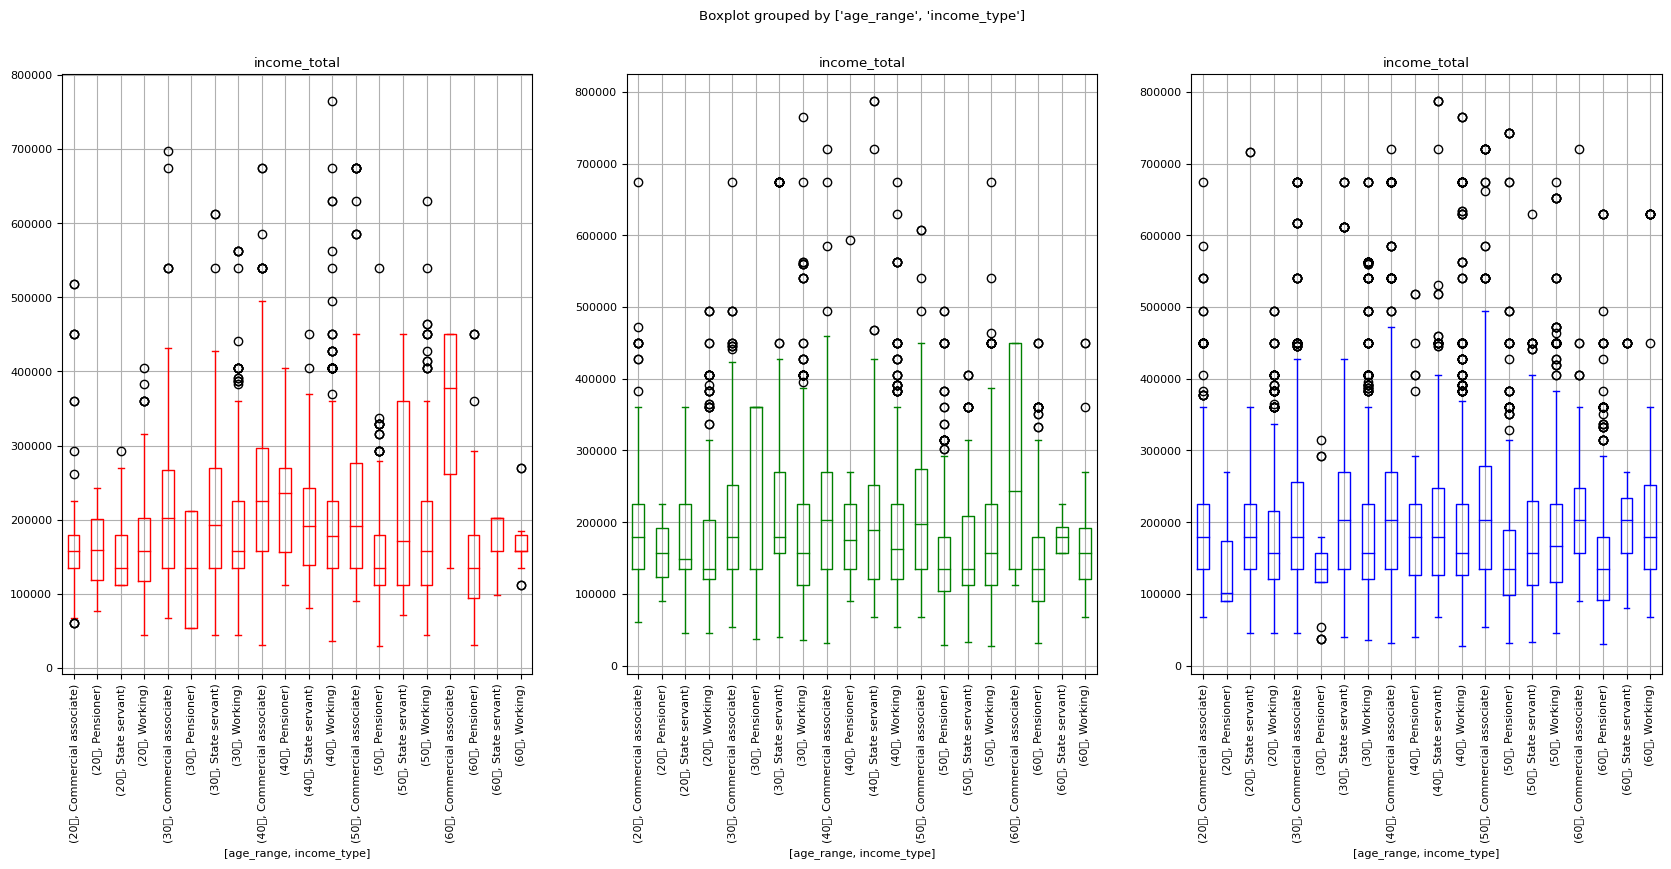

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,8))

train_4[train_4['credit']==0].boxplot(column=['income_total'], by=['age_range','income_type'], ax= axes[0], color='r', rot=90)
train_4[train_4['credit']==1].boxplot(column=['income_total'], by=['age_range','income_type'], ax= axes[1], color='g', rot=90)
train_4[train_4['credit']==2].boxplot(column=['income_total'], by=['age_range','income_type'], ax= axes[2], color='b', rot=90)

* 모든 credit 수준에서 income_total 범위가 비슷하게 나타난다.
* credit=0 에서 연금수령자인 30대는 소득수준이 다른30대보다 낮은데에 비해,    
  credit=1 에서 연금수령자인 30대는 소득수준이 다른30대보다 높다.
  credit=2 에서 연금수령자인 30대는 분포가 밀집되어 있다 (?)
* credit=0 에서 자영업자인 60대는 소득수준이 다른 60대보다, 다른 credit보다 높다.      
YES

train_2 = train_1[['car', 'reality', 'income_type', 'age_range', 'income_total', 'credit']]

**income_total ~ credit ~ (car * age_range)**

<Axes: title={'center': 'income_total'}, xlabel='[age_range, car]'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


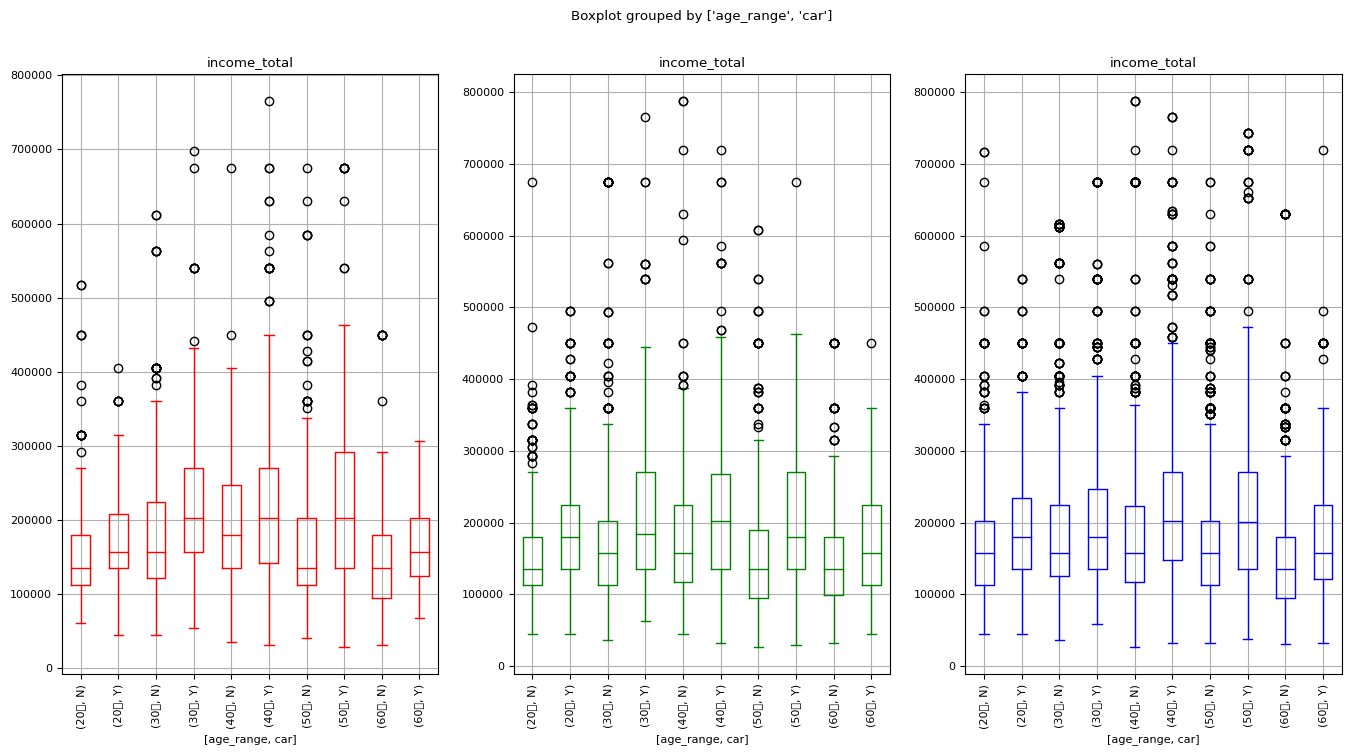

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,8))

train_4[train_4['credit']==0].boxplot(column=['income_total'], by=['age_range','car'], ax= axes[0], color='r', rot=90)
train_4[train_4['credit']==1].boxplot(column=['income_total'], by=['age_range','car'], ax= axes[1], color='g', rot=90)
train_4[train_4['credit']==2].boxplot(column=['income_total'], by=['age_range','car'], ax= axes[2], color='b', rot=90)

* 모든 credit에서, 모든 나이대에서 차없는사람이 차있는사람보다 소득수준이 낮다

* car 요인을 넣기 전에는 둥근산모양이었음
* credit=2에서 차없는 사람들에서 모든나이대가 소득수준이 비슷함(**)     
YES  
  

**income_total ~ credit ~ (reality*income_type)**

<Axes: title={'center': 'income_total'}, xlabel='[income_type, reality]'>

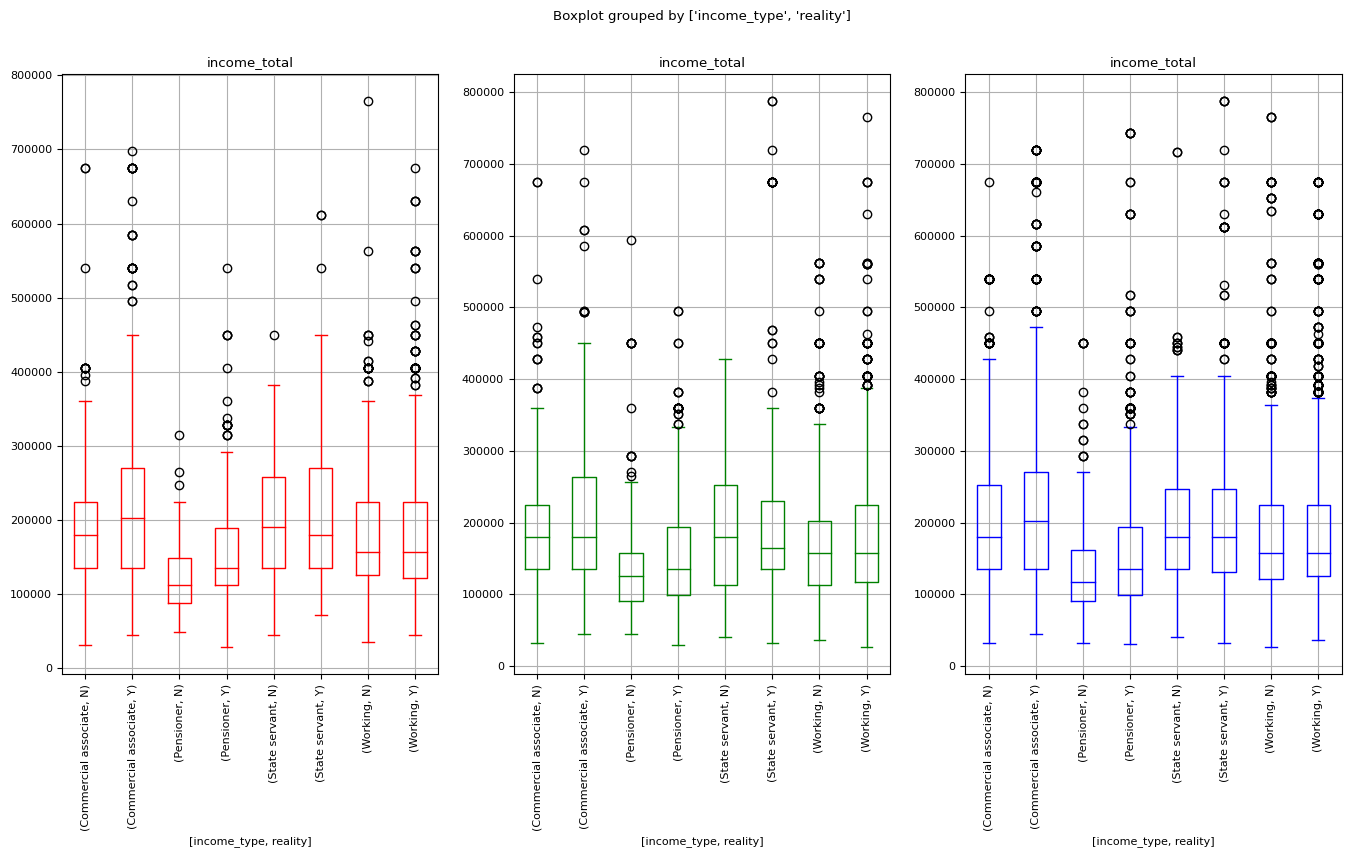

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,8))

train_4[train_4['credit']==0].boxplot(column=['income_total'], by=['income_type','reality'], ax= axes[0], color='r', rot=90)
train_4[train_4['credit']==1].boxplot(column=['income_total'], by=['income_type','reality'], ax= axes[1], color='g', rot=90)
train_4[train_4['credit']==2].boxplot(column=['income_total'], by=['income_type','reality'], ax= axes[2], color='b', rot=90)

* 모든 credit에서
  자영업자와 연금수령자는 부동산이 없는 사람이 부동산 잇는 사람보다 소득수준이 낮은데,
  공무원과 월급쟁이는 부동산이 없는 사람이 부동산 잇는 사람보다 소득수준이 높다
* credit=1에서는
  자영업자 중에서 부동산이 없는 사람과 부동산이 잇는 사람 소득수준이 거의 비슷하다

<Axes: title={'center': 'income_total'}, xlabel='[age_range, reality, car]'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


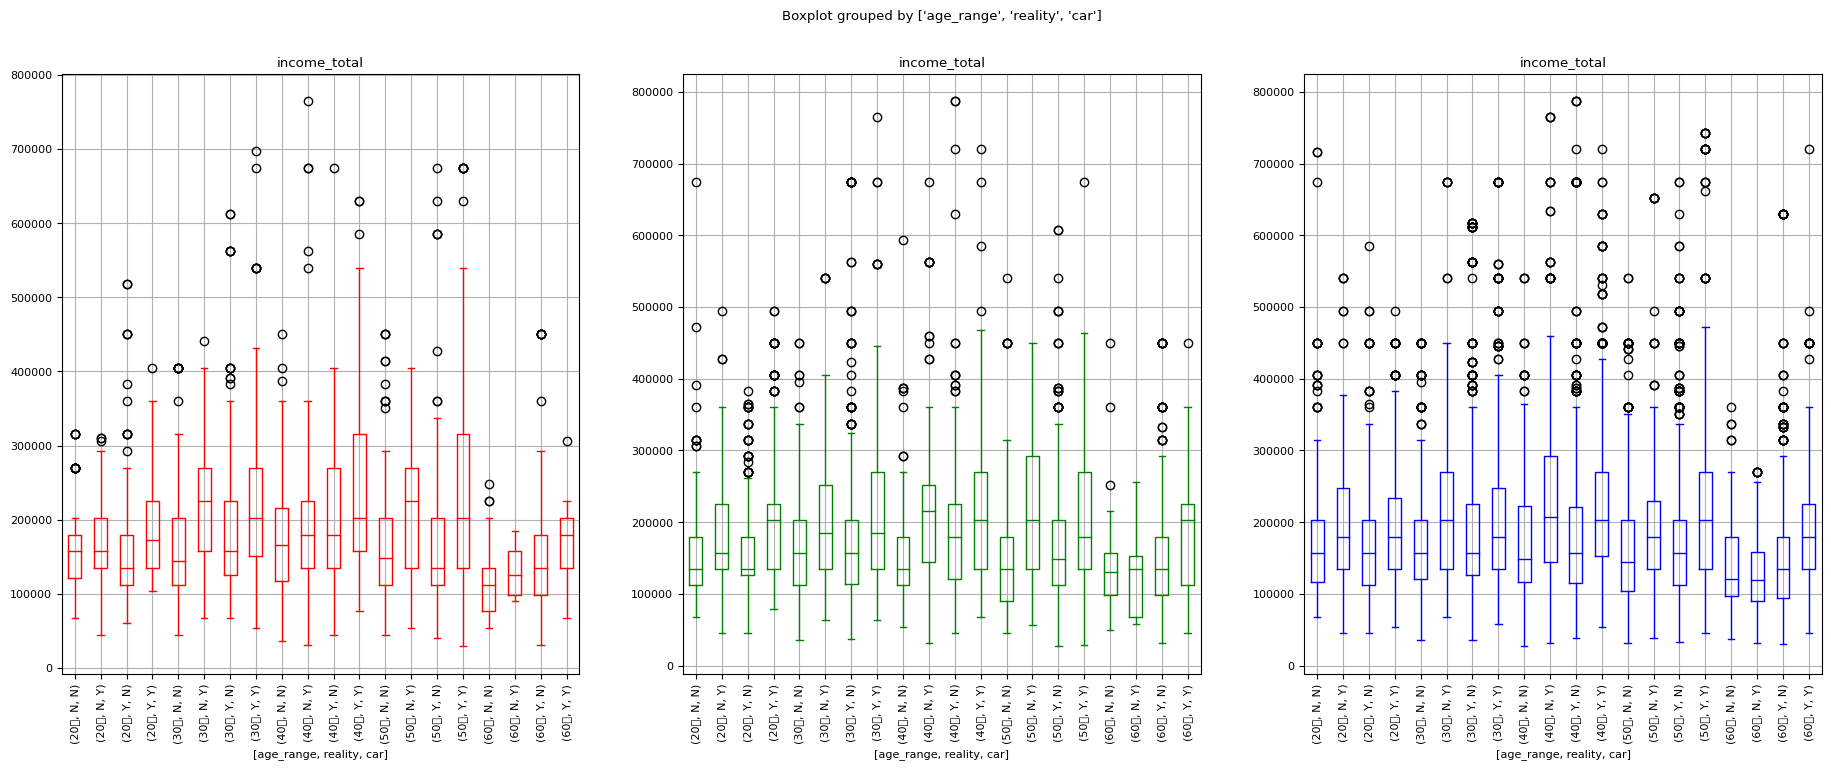

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(22,8))

train_4[train_4['credit']==0].boxplot(column=['income_total'], by=['age_range', 'reality', 'car'], ax= axes[0], color='r', rot=90)
train_4[train_4['credit']==1].boxplot(column=['income_total'], by=['age_range', 'reality', 'car'], ax= axes[1], color='g', rot=90)
train_4[train_4['credit']==2].boxplot(column=['income_total'], by=['age_range', 'reality', 'car'], ax= axes[2], color='b', rot=90)

2. 가족 관련 변수
  (유빈)     
  자녀 수(child_num), 결혼 여부(faily_type), 생활방식(house_type), 가족규모(family_size)     
  +소득(income_total)



In [ ]:
train_drop = train.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

EDA1

1) 가족규모

<Axes: xlabel='family_size', ylabel='income_total'>

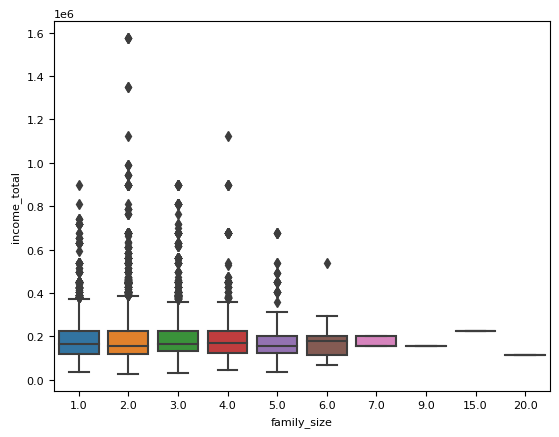

In [ ]:
sns.boxplot(data=train_drop, y="income_total",x='family_size')

<Axes: xlabel='credit', ylabel='count'>

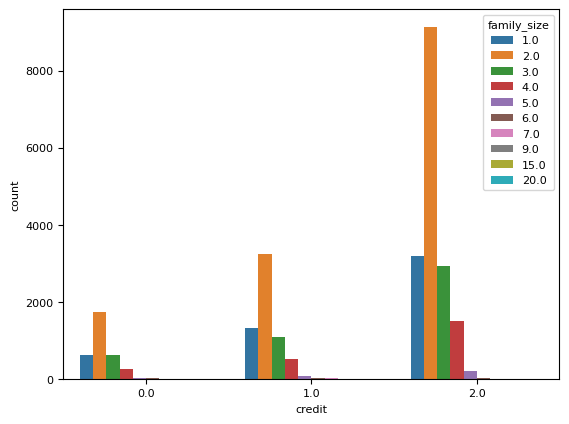

In [ ]:
sns.countplot(data=train, x="credit", hue='family_size')

2) 자녀수

<Axes: xlabel='child_num', ylabel='income_total'>

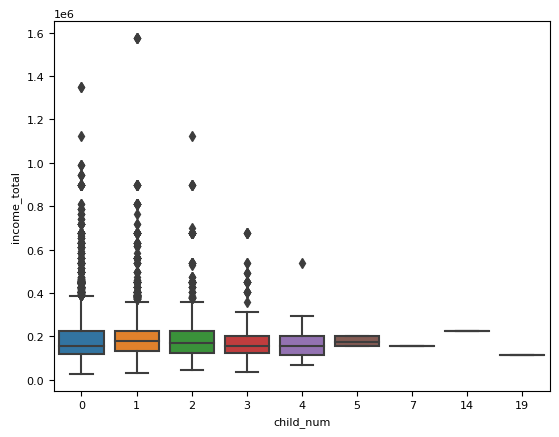

In [ ]:
sns.boxplot(data=train_drop, y="income_total",x='child_num')

<Axes: xlabel='credit', ylabel='count'>

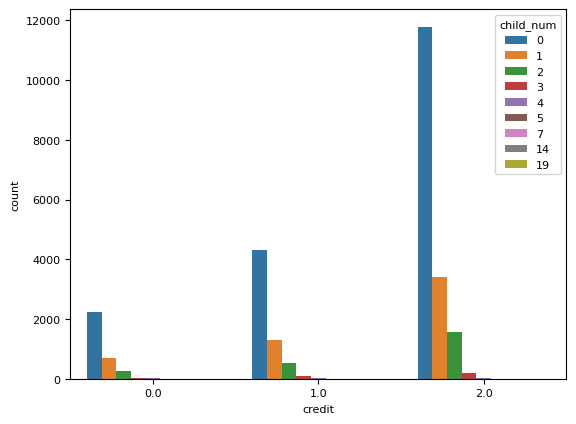

In [ ]:
sns.countplot(data=train, x="credit", hue='child_num')

3) 결혼여부

<Axes: xlabel='family_type', ylabel='income_total'>

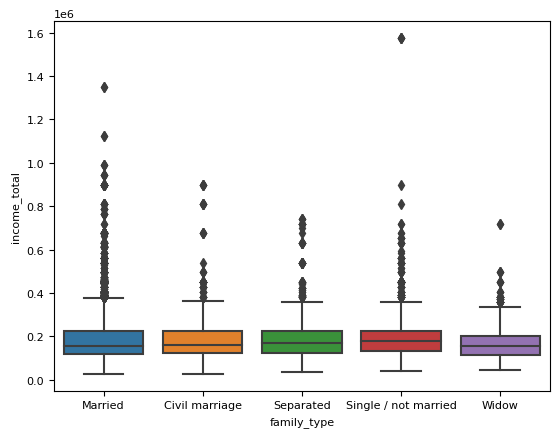

In [ ]:
sns.boxplot(data=train_drop, y="income_total",x='family_type')

<Axes: xlabel='credit', ylabel='count'>

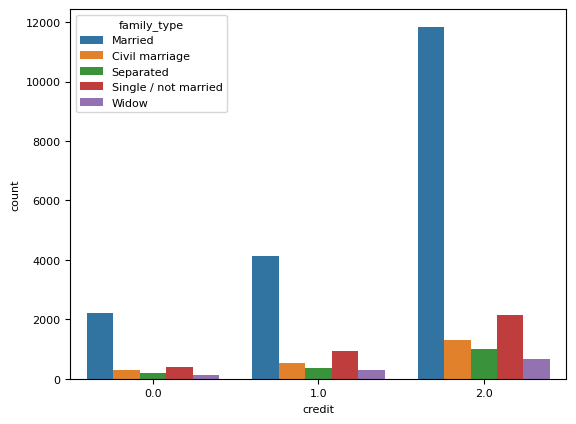

In [ ]:
sns.countplot(data=train, x="credit", hue='family_type')

4) 생활방식

<Axes: xlabel='house_type', ylabel='income_total'>

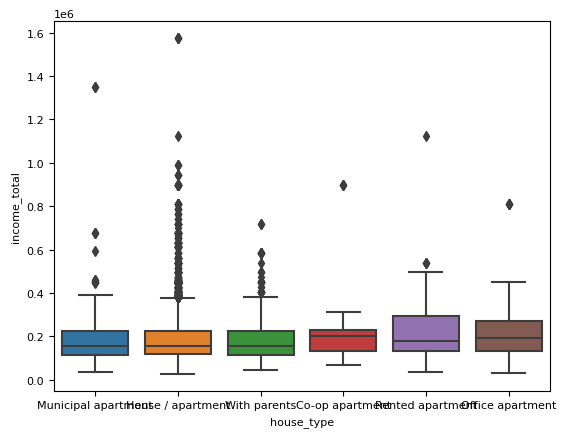

In [ ]:
sns.boxplot(data=train_drop, y="income_total",x='house_type')

<Axes: xlabel='credit', ylabel='count'>

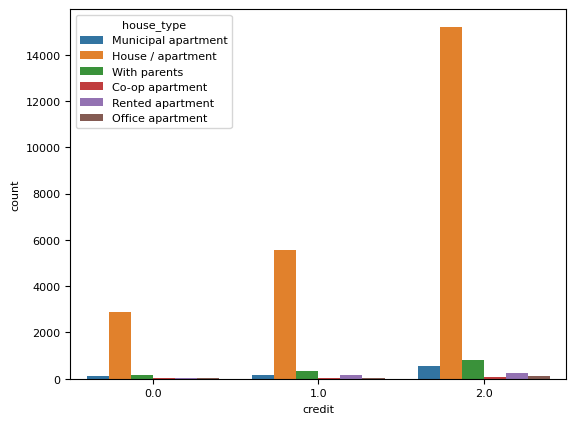

In [ ]:
sns.countplot(data=train, x="credit", hue='house_type')

EDA2

In [ ]:
train_begin = train_drop.drop('begin_month', axis=1)

1) 가족규모

<Axes: xlabel='family_size', ylabel='income_total'>

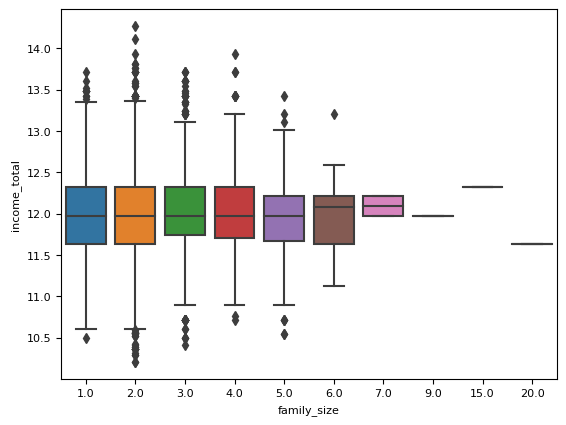

In [ ]:
sns.boxplot(data=train_begin, y="income_total",x='family_size')

<Axes: xlabel='credit', ylabel='count'>

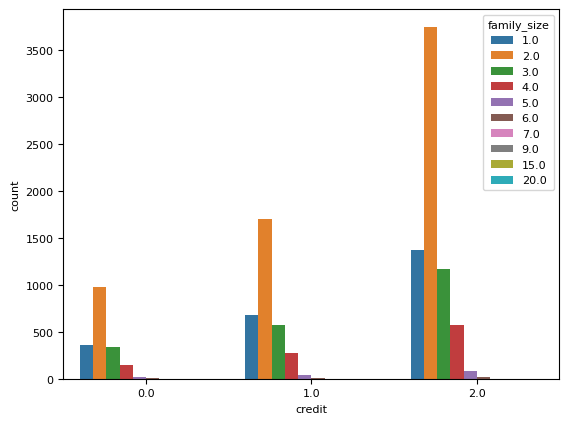

In [ ]:
sns.countplot(data=train_begin, x="credit", hue='family_size')

2) 자녀수

<Axes: xlabel='child_num', ylabel='income_total'>

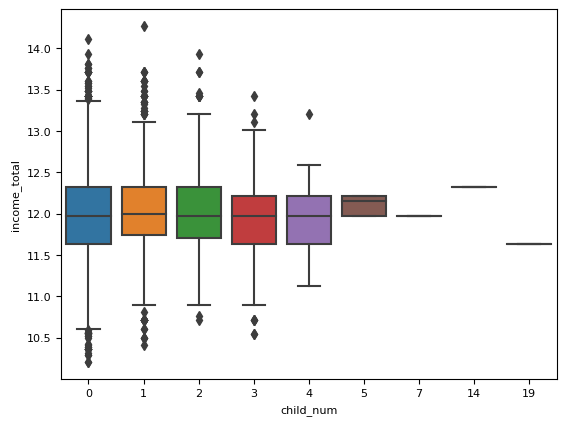

In [ ]:
sns.boxplot(data=train_begin, y="income_total",x='child_num')

<Axes: xlabel='credit', ylabel='count'>

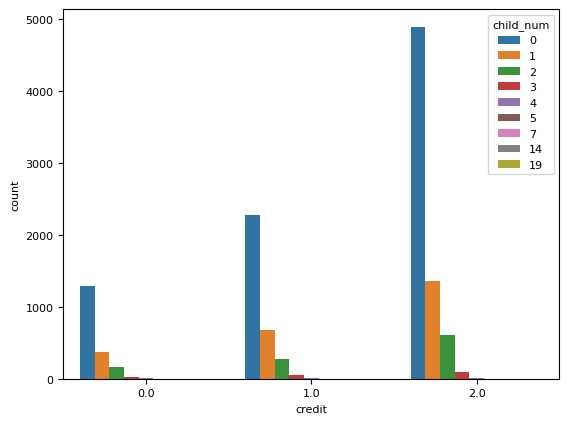

In [ ]:
sns.countplot(data=train_begin, x="credit", hue='child_num')

3) 결혼여부

<Axes: xlabel='family_type', ylabel='income_total'>

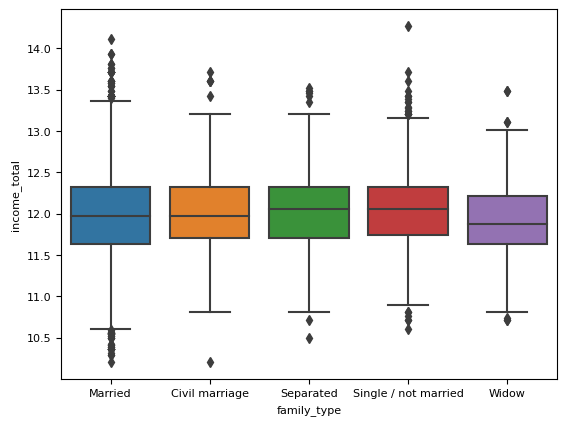

In [ ]:
sns.boxplot(data=train_begin, y="income_total",x='family_type')

<Axes: xlabel='credit', ylabel='count'>

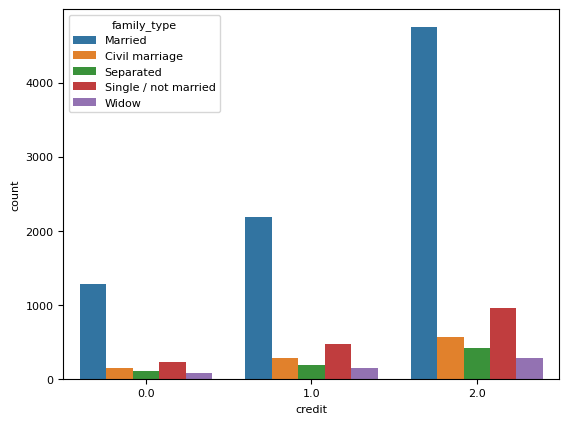

In [ ]:
sns.countplot(data=train_begin, x="credit", hue='family_type')

4) 생활방식

<Axes: xlabel='house_type', ylabel='income_total'>

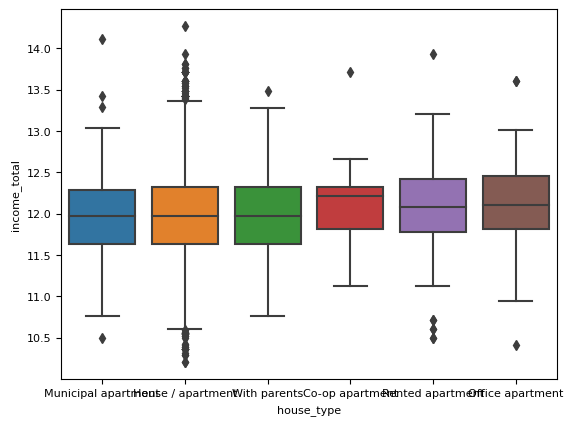

In [ ]:
sns.boxplot(data=train_begin, y="income_total",x='house_type')

<Axes: xlabel='credit', ylabel='count'>

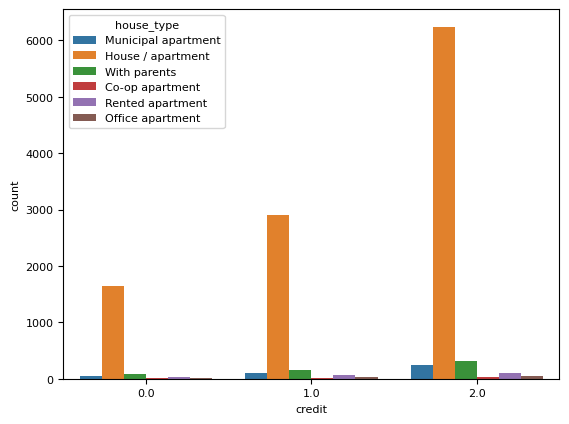

In [ ]:
sns.countplot(data=train_begin, x="credit", hue='house_type')

3. 나이 관련 변수
  (수빈)    
  출생일(DAYS_BIRTH), 업무시작일(DAYS_EMPLOYED),     
  +소득(income_total)

In [ ]:
train = pd.read_csv("train_original.csv", index_col=0)

FileNotFoundError: ignored

나이
- days_birth
- days_employed

----------------------------------

소득

- car
- reality
- income_total
- income_type
- occyp_type

In [ ]:
train['DAYS_BIRTH']=np.abs(train['DAYS_BIRTH'])

In [ ]:
train['Age'] = train['DAYS_BIRTH'] // 365
train['Age_10'] = (train['DAYS_BIRTH'] // 3650)*10

In [ ]:
train.loc[(train['Age_10']==20), 'Age_10'] = '20s'
train.loc[(train['Age_10']==30), 'Age_10'] = '30s'
train.loc[(train['Age_10']==40), 'Age_10'] = '40s'
train.loc[(train['Age_10']==50), 'Age_10'] = '50s'
train.loc[(train['Age_10']==60), 'Age_10'] = '60s'


(array([0.00442307, 0.01011678, 0.03269858, 0.02230838, 0.02353076,
        0.03655872, 0.02555733, 0.02483355, 0.03704124, 0.02232446,
        0.02012097, 0.0293853 , 0.0195902 , 0.01774055, 0.02679579,
        0.01873775, 0.01883425, 0.01992796, 0.01006853, 0.00493776]),
 array([21.  , 23.35, 25.7 , 28.05, 30.4 , 32.75, 35.1 , 37.45, 39.8 ,
        42.15, 44.5 , 46.85, 49.2 , 51.55, 53.9 , 56.25, 58.6 , 60.95,
        63.3 , 65.65, 68.  ]),
 <BarContainer object of 20 artists>)

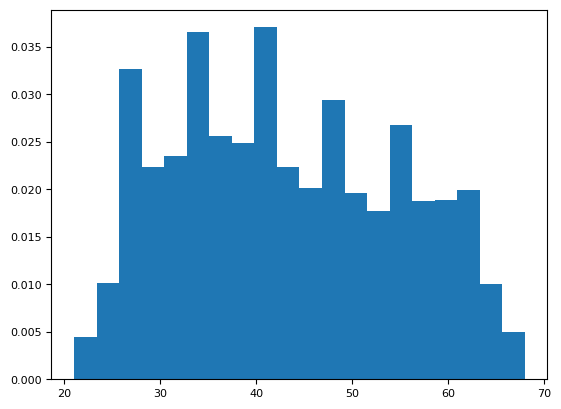

In [ ]:
plt.hist(train['Age'], density=True ,bins=20)

<Axes: xlabel='Age_10', ylabel='count'>

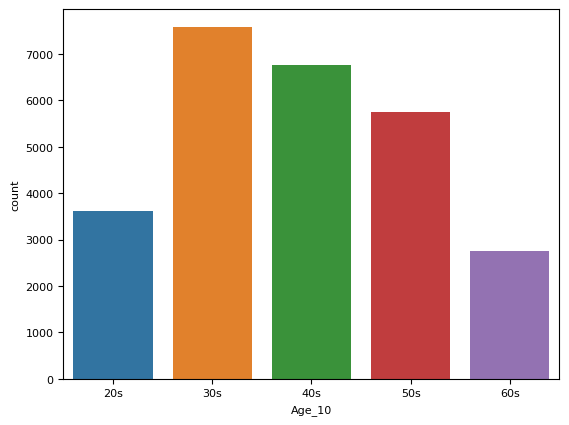

In [ ]:
sns.countplot(data=train, x='Age_10', order=['20s','30s','40s', '50s', '60s'])

<Axes: xlabel='Age_10', ylabel='income_total'>

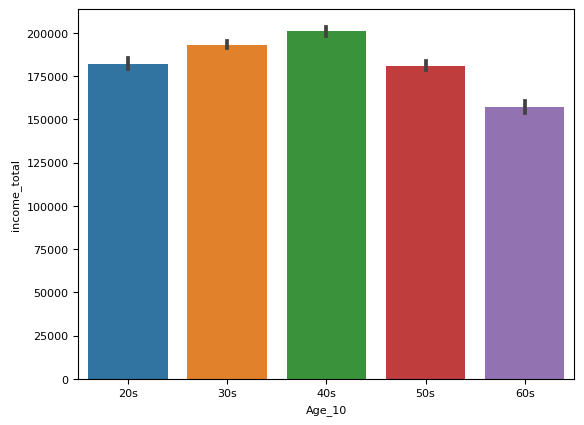

In [ ]:
sns.barplot(x='Age_10',y='income_total', data=train, order=['20s','30s','40s', '50s', '60s'])

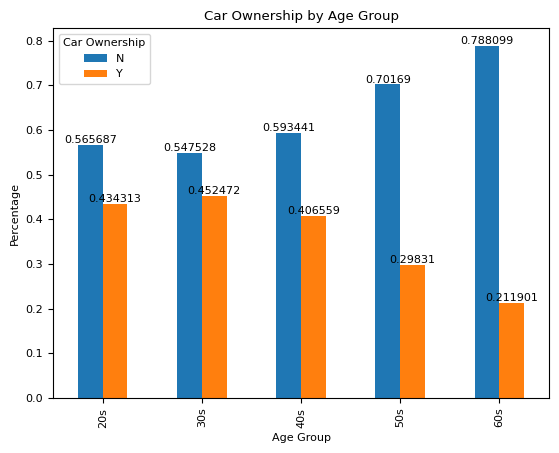

In [ ]:
# 나이대별 자동차 소유 여부의 수 계산
count_by_age_car = train.groupby(['Age_10', 'car']).size().unstack()

# 비율 계산
total_by_age = count_by_age_car.sum(axis=1)
percentage_by_age_car = count_by_age_car.divide(total_by_age, axis=0)

# 그래프 그리기
ax = percentage_by_age_car.plot(kind='bar', stacked=False)

# 비율 정보 표시
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=8)

# 그래프 옵션 설정
plt.title("Car Ownership by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage")
plt.legend(title='Car Ownership')

# 그래프 출력
plt.show()

<Axes: xlabel='Age_10', ylabel='income_total'>

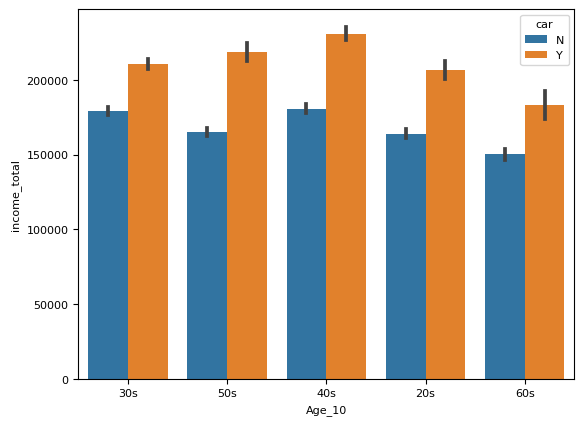

In [ ]:
sns.barplot(data=train, x='Age_10', y='income_total', hue='car')

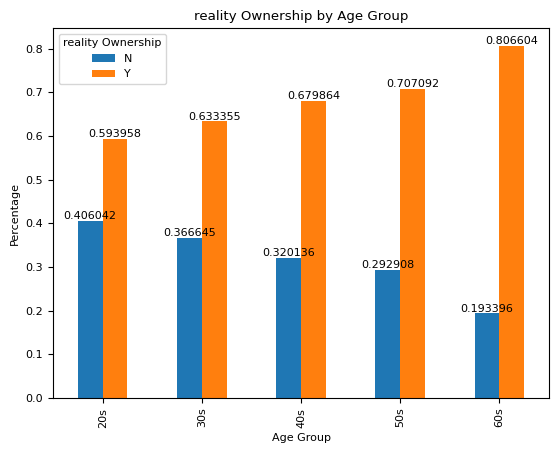

In [ ]:
# 나이대별 부동산 소유 여부의 수 계산
count_by_age_reality = train.groupby(['Age_10', 'reality']).size().unstack()

# 비율 계산
total_by_age = count_by_age_reality.sum(axis=1)
percentage_by_age_reality = count_by_age_reality.divide(total_by_age, axis=0)

# 그래프 그리기
ax = percentage_by_age_reality.plot(kind='bar', stacked=False)

# 비율 정보 표시
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=8)

# 그래프 옵션 설정
plt.title("reality Ownership by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage")
plt.legend(title='reality Ownership')

# 그래프 출력
plt.show()

<Axes: xlabel='Age_10', ylabel='income_total'>

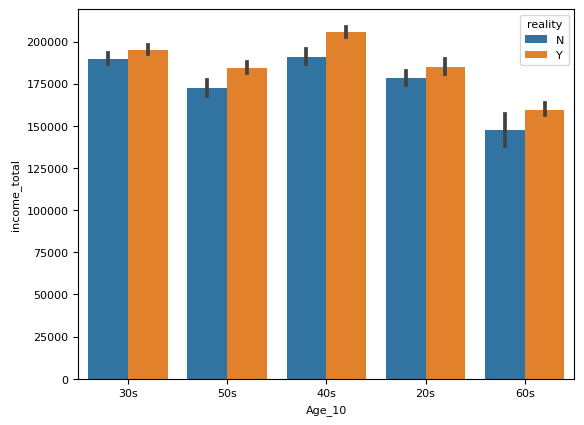

In [ ]:
sns.barplot(data=train, x='Age_10', y='income_total', hue='reality')

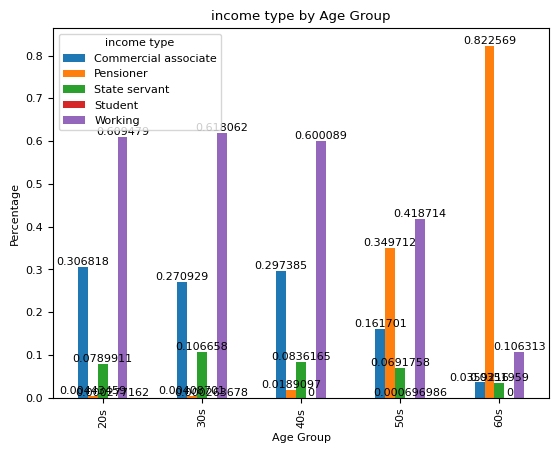

In [ ]:
#
count_by_age_reality = train.groupby(['Age_10', 'income_type']).size().unstack()

# 비율 계산
total_by_age = count_by_age_reality.sum(axis=1)
percentage_by_age_reality = count_by_age_reality.divide(total_by_age, axis=0)

# 그래프 그리기
ax = percentage_by_age_reality.plot(kind='bar', stacked=False)

# 비율 정보 표시
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=8)

# 그래프 옵션 설정
plt.title("income type by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage")
plt.legend(title='income type')

# 그래프 출력
plt.show()

**업무 시작일**

- DAYS_EMPLOYED

income type이 pensioner일경우 days employed를 365243바꿔주기

In [ ]:
train.loc[train['income_type'] == 'Pensioner', 'DAYS_EMPLOYED'] = 365243

In [ ]:
train[train['income_type'] == 'Pensioner']['DAYS_EMPLOYED'].value_counts()

365243    4449
Name: DAYS_EMPLOYED, dtype: int64

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

In [ ]:
train['DAYS_EMPLOYED']=np.abs(train['DAYS_EMPLOYED'])

In [ ]:
train['work'] = train['DAYS_EMPLOYED'] // 365
train['work_5'] = (train['DAYS_EMPLOYED'] // 1825)*5

In [ ]:
train['work_5'].value_counts()

0     14814
5      6474
10     2711
15     1192
20      672
25      371
30      137
35       54
40       32
Name: work_5, dtype: int64

In [ ]:
train.loc[(train['work_5']==0), 'work_5'] = '0~4'
train.loc[(train['work_5']==5), 'work_5'] = '5~9'
train.loc[(train['work_5']==10), 'work_5'] = '10~14'
train.loc[(train['work_5']==15), 'work_5'] = '15~19'
train.loc[(train['work_5']==20), 'work_5'] = '20~24'
train.loc[(train['work_5']==25), 'work_5'] = '25~29'
train.loc[(train['work_5']==30), 'work_5'] = '30~34'
train.loc[(train['work_5']==35), 'work_5'] = '35~39'
train.loc[(train['work_5']==40), 'work_5'] = '40+'

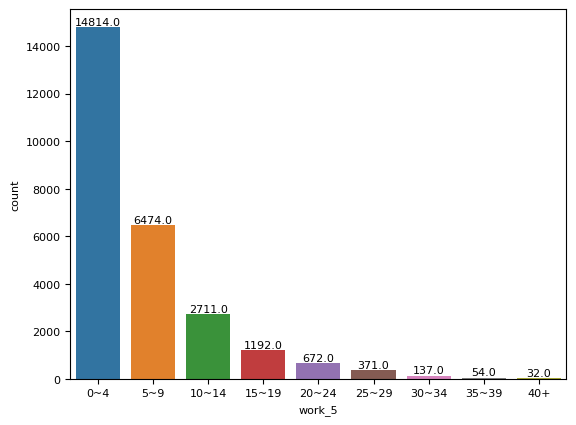

In [ ]:
ax=sns.countplot(data=train, x='work_5',order=['0~4','5~9','10~14','15~19','20~24','25~29','30~34','35~39','40+'])

for p in ax.patches:
    count = p.get_height()
    ax.annotate(str(count), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

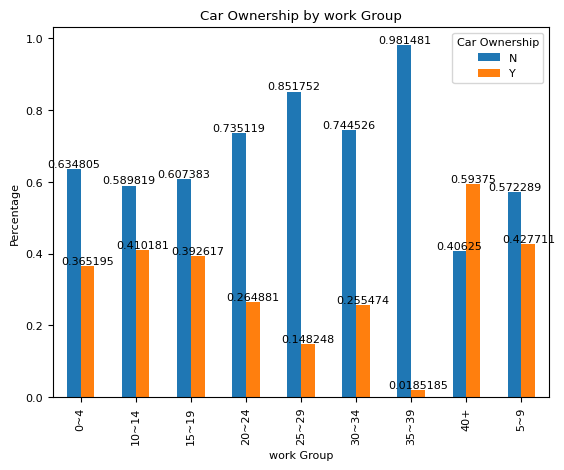

In [ ]:
# 경력별 자동차 소유 여부의 수 계산
count_by_work_car = train.groupby(['work_5', 'car']).size().unstack()

# 비율 계산
total_by_work = count_by_work_car.sum(axis=1)
percentage_by_work_car = count_by_work_car.divide(total_by_work, axis=0)

# 그래프 그리기
ax = percentage_by_work_car.plot(kind='bar', stacked=False)

# 비율 정보 표시
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=8)

# 그래프 옵션 설정
plt.title("Car Ownership by work Group")
plt.xlabel("work Group")
plt.ylabel("Percentage")
plt.legend(title='Car Ownership')

# 그래프 출력
plt.show()

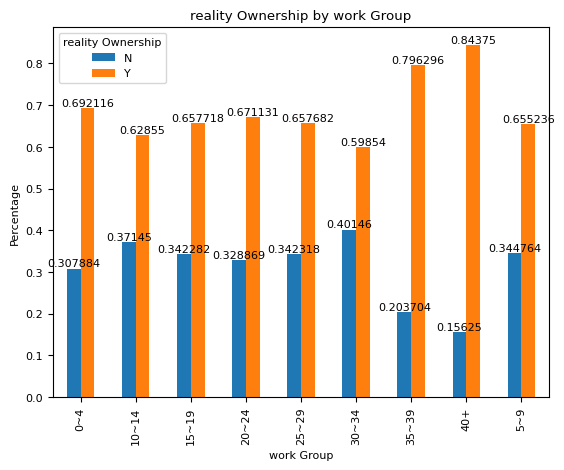

In [ ]:
# 경력별 집 소유 여부의 수 계산
count_by_work_reality = train.groupby(['work_5', 'reality']).size().unstack()

# 비율 계산
total_by_work = count_by_work_reality.sum(axis=1)
percentage_by_work_reality = count_by_work_reality.divide(total_by_work, axis=0)

# 그래프 그리기
ax = percentage_by_work_reality.plot(kind='bar', stacked=False)

# 비율 정보 표시
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=8)

# 그래프 옵션 설정
plt.title("reality Ownership by work Group")
plt.xlabel("work Group")
plt.ylabel("Percentage")
plt.legend(title='reality Ownership')

# 그래프 출력
plt.show()

4. 직업 관련 변수
  (민경)     
  업무용 전화 소유 여부(work_phone), 전화 소유 여부(phone), 이메일 소유 여부(email), 직업 유형(occyp_type), 업무 시작일(DAYS_EMPLOYED)


*   DAYS_EMPLOYED: 업무 시작일
	* 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
	* 양수 값은 고용되지 않은 상태를 의미함
 *   [int64] : -15713부터 365243까지.. 정규화

*   work_phone: 업무용 전화 소유 여부
 *   [int64] : 0, 1 두 개니까 그냥 두기
*   phone: 전화 소유 여부
 *   [int64] : 0, 1 두 개니까 그냥 두기
*   email: 이메일 소유 여부
 *   [int64] : 0, 1 두 개니까 그냥 두기
*   occyp_type: 직업 유형
 *   [object] : 18가지인데 결측치가 많으니 삭제?

*   credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도    
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함
 *   [float64] : 0, 1, 2 3가지인데 이게 타겟!

5. 직업 관련 변수
  (세영)    
  직업유형(occyp_type),

In [ ]:
train2 = train.copy()
train2['occyp_type']= train2['occyp_type'].fillna('unknown')

[Text(0, 0, 'unknown'),
 Text(1, 0, 'Laborers'),
 Text(2, 0, 'Managers'),
 Text(3, 0, 'Sales staff'),
 Text(4, 0, 'High skill tech staff'),
 Text(5, 0, 'Core staff'),
 Text(6, 0, 'Drivers'),
 Text(7, 0, 'Medicine staff'),
 Text(8, 0, 'Accountants'),
 Text(9, 0, 'Realty agents'),
 Text(10, 0, 'Security staff'),
 Text(11, 0, 'Cleaning staff'),
 Text(12, 0, 'Private service staff'),
 Text(13, 0, 'Cooking staff'),
 Text(14, 0, 'Secretaries'),
 Text(15, 0, 'HR staff'),
 Text(16, 0, 'IT staff'),
 Text(17, 0, 'Low-skill Laborers'),
 Text(18, 0, 'Waiters/barmen staff')]

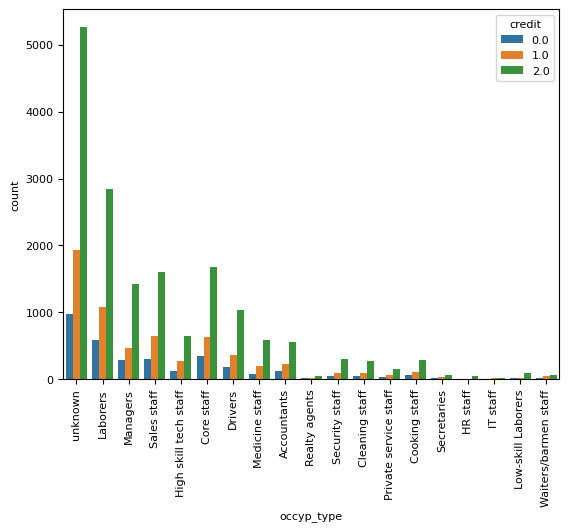

In [ ]:
plot = sns.countplot(x='occyp_type', data=train2, hue='credit')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

[Text(0, 0, 'unknown')]

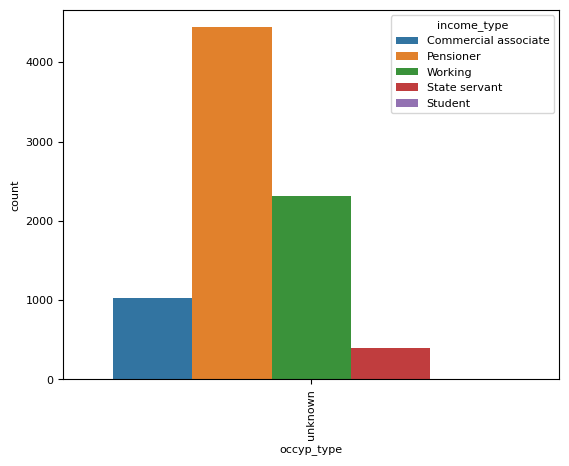

In [ ]:
# 'occyp_type' = nan (unknown) 에 해당하는 income_type 분포는?

unknown = train2[train2['occyp_type']=='unknown']

plot = sns.countplot(x='occyp_type', data=unknown, hue='income_type')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

In [ ]:
# 등급에 따른 차이를 보기 위한 데이터 분류
train_0 = train[train['income_type']=='Working']
train_1 = train[train['income_type']=='Commercial associate']
train_2 = train[train['income_type']=='Pensioner']
train_3 = train[train['income_type']=='State servant']
train_4 = train[train['income_type']=='Student']

# Categorical 그래프 함수 정의
def income_type(column):

  f, ax = plt.subplots(5,1, figsize=(16,20))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)

  ax[0].set_title('Working')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)

  ax[1].set_title('Commercial associate')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)

  ax[2].set_title('Pensioner')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_3,
                ax = ax[3],
                order = train_3[column].value_counts().index)

  ax[3].set_title('State servant')
  ax[3].set_ylabel('count')
  ax[3].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_4,
                ax = ax[4],
                order = train_4[column].value_counts().index)

  ax[4].set_title('Student')
  ax[4].set_ylabel('count')
  ax[4].tick_params(rotation=50)

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

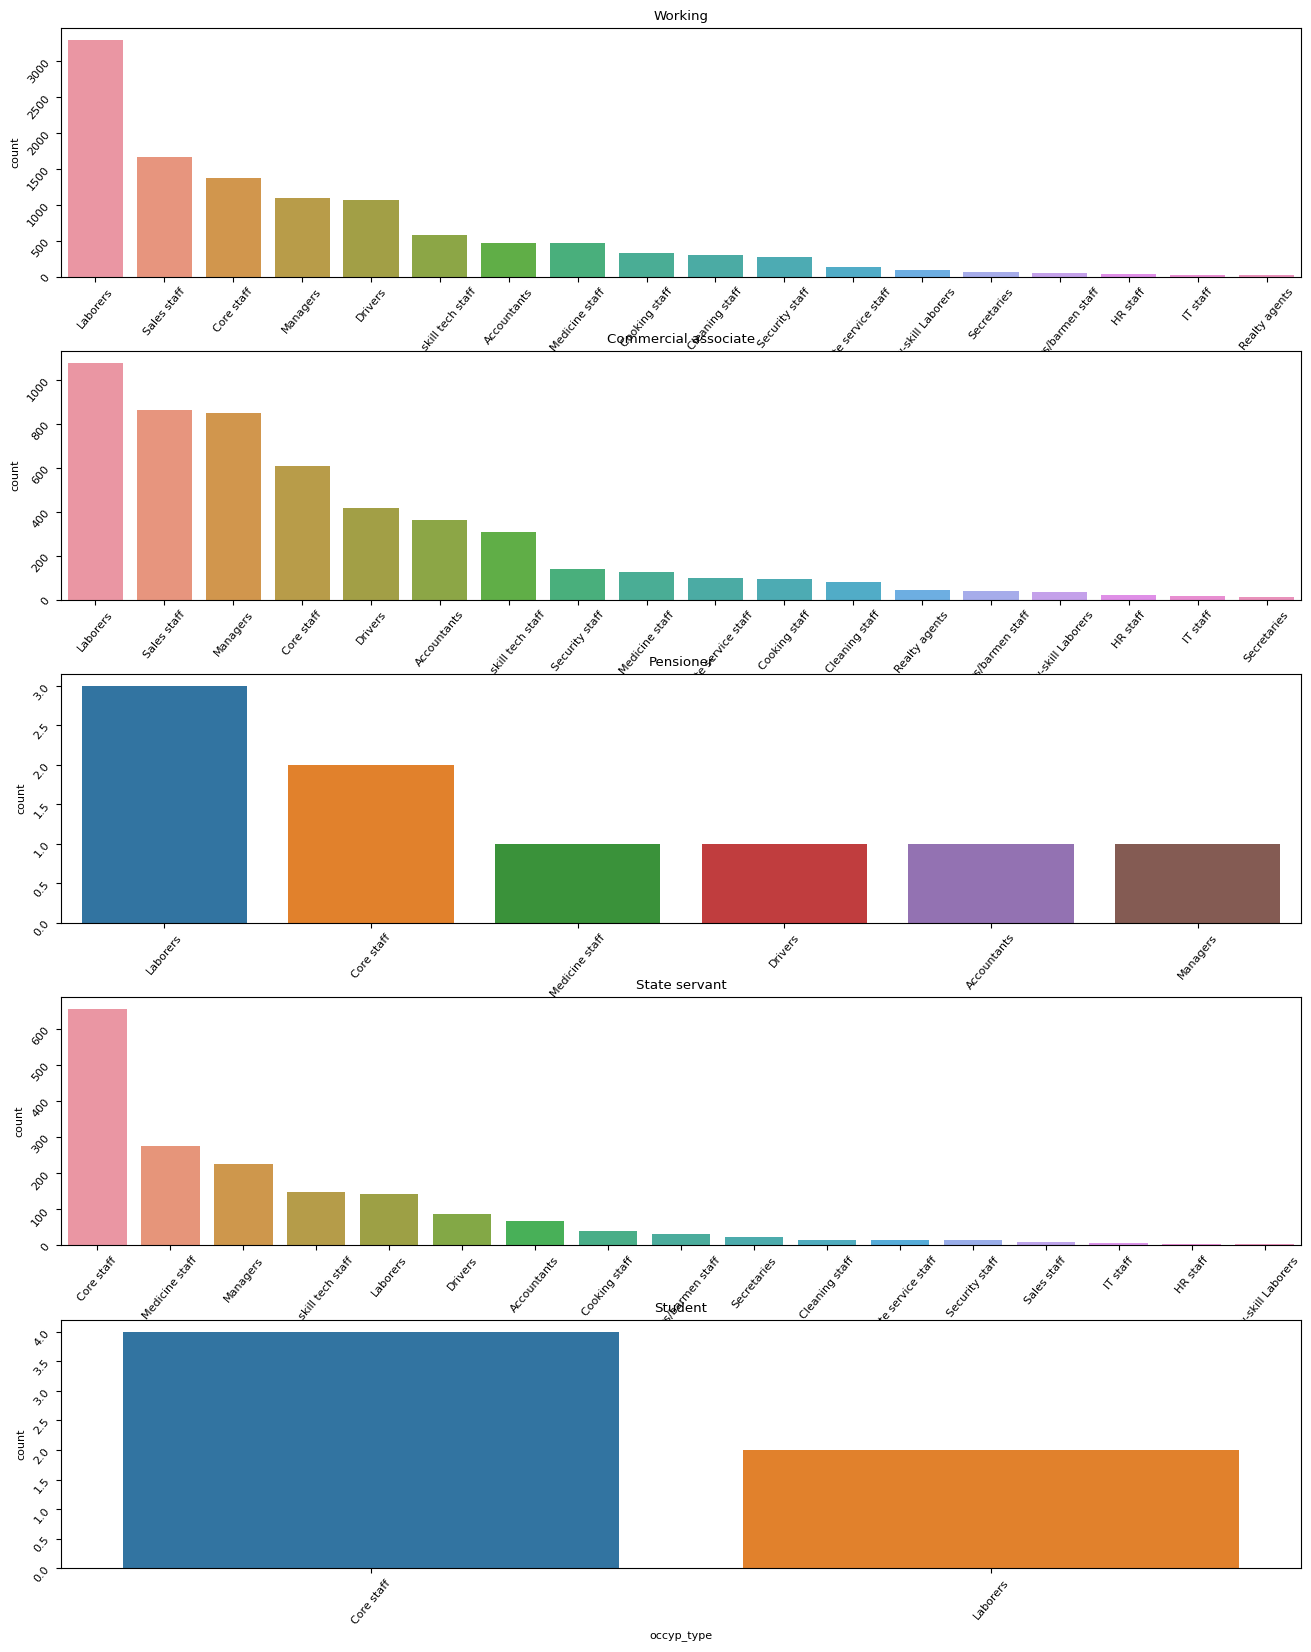

In [ ]:
income_type('occyp_type') # nan 값 처리 안 했을 때

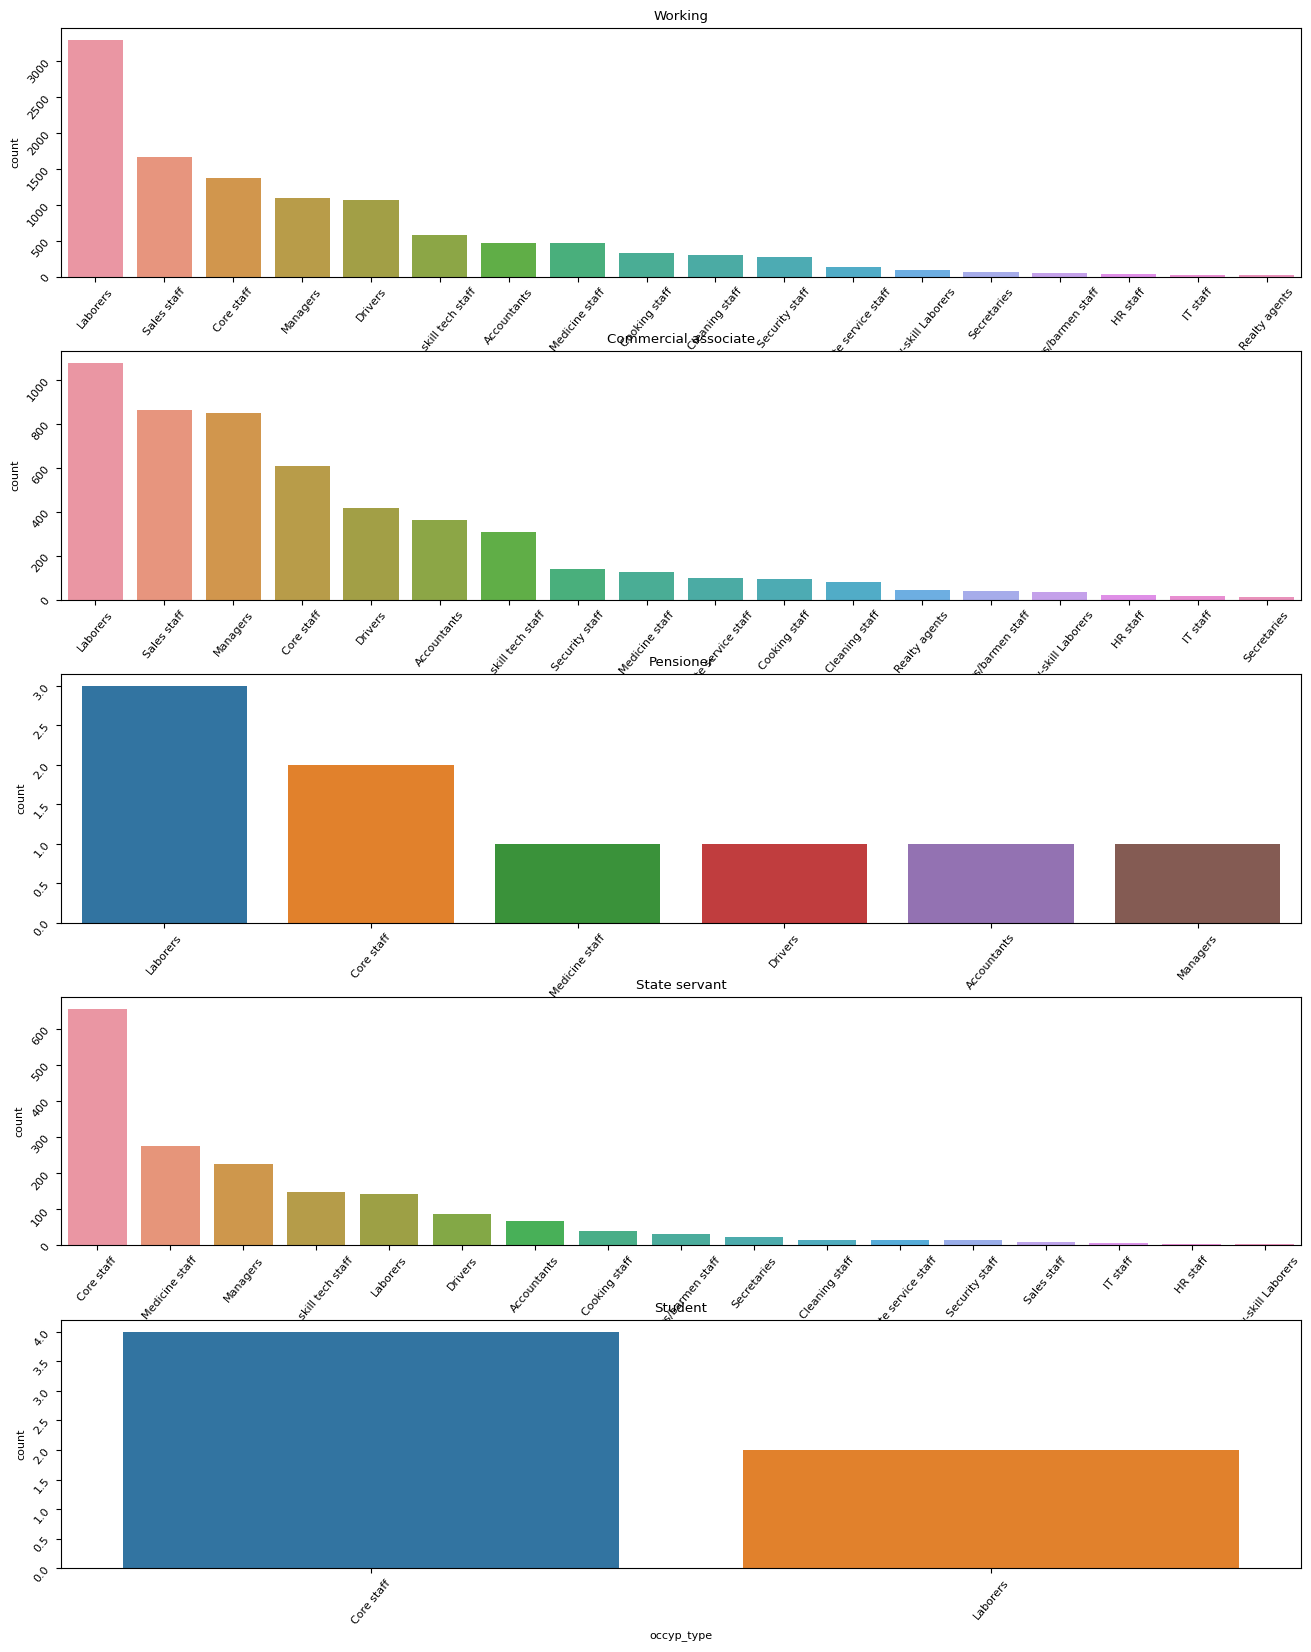

In [ ]:
income_type('occyp_type') # nan 값 unknown 으로 대체

>>
'Pensioner'의 'occyp_type' = 대부분 nan
 - nan 아닌 값 으로 기입된 것이 오히려 이상치 수준
    - 'Pensioner 전체 4449 명 중 unknown 외 3,2,1,1,1 명  



## 3. 데이터 전처리

In [ ]:
train_0 = pd.read_csv("train.csv", index_col=0)
test_0 = pd.read_csv("test.csv", index_col=0)
train_0.head()

gender car reality  child_num  income_total           income_type  \
index                                                                     
0          F   N       N          0      202500.0  Commercial associate   
1          F   N       Y          1      247500.0  Commercial associate   
2          M   Y       Y          0      450000.0               Working   
3          F   N       Y          0      202500.0  Commercial associate   
4          F   Y       Y          0      157500.0         State servant   

                            edu_type     family_type           house_type  \
index                                                                       
0                   Higher education         Married  Municipal apartment   
1      Secondary / secondary special  Civil marriage    House / apartment   
2                   Higher education         Married    House / apartment   
3      Secondary / secondary special         Married    House / apartment   
4                   Higher education         Married    House / apartment   

       DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
index                                                                    
0          -13899          -4709           1           0      0      0   
1          -11380          -1540           1           0      0      1   
2          -19087          -4434           1           0      1      0   
3          -15088          -2092           1           0      1      0   
4          -15037          -2105           1           0      0      0   

        occyp_type  family_size  begin_month  credit  
index                                                 
0              NaN          2.0         -6.0     1.0  
1         Laborers          3.0         -5.0     1.0  
2         Managers          2.0        -22.0     2.0  
3      Sales staff          2.0        -37.0     0.0  
4         Managers          2.0        -26.0     2.0

### FLAG_MOBILE
* 값이 모두 1로 의미없으므로 드롭

In [ ]:
train_0.drop(['FLAG_MOBIL'], axis=1, inplace=True)
test_0.drop(['FLAG_MOBIL'], axis=1, inplace=True)

### DAYS_EMPLOYED
* 뻥쟁이 처리

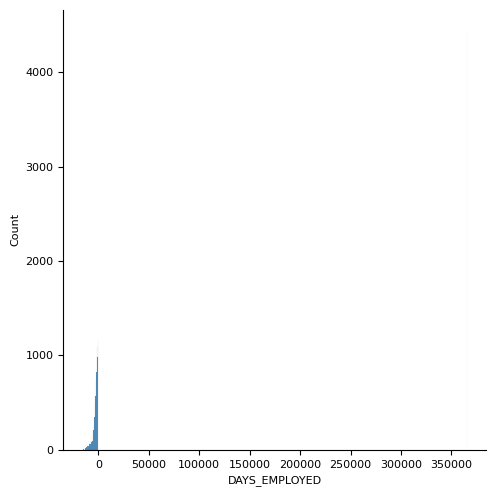

In [ ]:
sns.displot(data=train_0, x='DAYS_EMPLOYED')

In [ ]:
train_0['DAYS_EMPLOYED'] = -train_0['DAYS_EMPLOYED']
train_0.loc[train_0['income_type']=='Pensioner', 'DAYS_EMPLOYED'] = 1

test_0['DAYS_EMPLOYED'] = -test_0['DAYS_EMPLOYED']
test_0.loc[test_0['income_type']=='Pensioner', 'DAYS_EMPLOYED'] = 1

In [ ]:
train_0['DAYS_EMPLOYED'] = np.log(train_0['DAYS_EMPLOYED'])

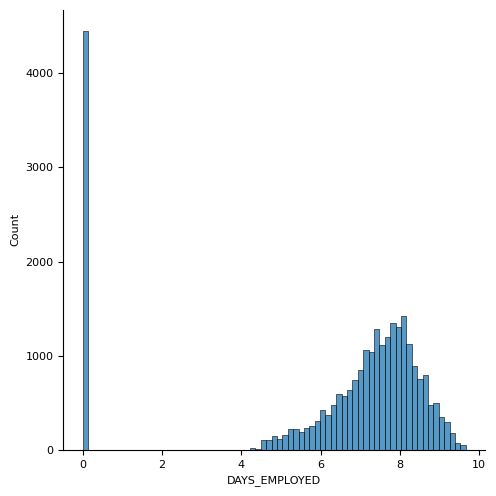

In [ ]:
sns.displot(data=train_0, x='DAYS_EMPLOYED')

days_employed 처리하고 id 처리해야함       
그 다음에 다른것들 처리

### ID
* 새롭게 생성

In [ ]:
for df in [train_0,test_0]:
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the 'id' column in train_0 DataFrame
train_0['ID'] = encoder.fit_transform(train_0[['ID']])

# Remove the 'index' column
train_0 = train_0.reset_index(drop=True)

train_0.head()

gender car reality  child_num  income_total           income_type  \
0      F   N       N          0      202500.0  Commercial associate   
1      F   N       Y          1      247500.0  Commercial associate   
2      M   Y       Y          0      450000.0               Working   
3      F   N       Y          0      202500.0  Commercial associate   
4      F   Y       Y          0      157500.0         State servant   

                        edu_type     family_type           house_type  \
0               Higher education         Married  Municipal apartment   
1  Secondary / secondary special  Civil marriage    House / apartment   
2               Higher education         Married    House / apartment   
3  Secondary / secondary special         Married    House / apartment   
4               Higher education         Married    House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  work_phone  phone  email   occyp_type  \
0      -13899       8.457231           0      0      0          NaN   
1      -11380       7.339538           0      0      1     Laborers   
2      -19087       8.397057           0      1      0     Managers   
3      -15088       7.645876           0      1      0  Sales staff   
4      -15037       7.652071           0      0      0     Managers   

   family_size  begin_month  credit      ID  
0          2.0         -6.0     1.0  3096.0  
1          3.0         -5.0     1.0  7301.0  
2          2.0        -22.0     2.0  5063.0  
3          2.0        -37.0     0.0  3128.0  
4          2.0        -26.0     2.0  1917.0

In [ ]:
encoder = OrdinalEncoder()

# Fit and transform the 'id' column in train_0 DataFrame
test_0['ID'] = encoder.fit_transform(test_0[['ID']])

# Remove the 'index' column
test_0 = test_0.reset_index(drop=True)

test_0.head()

gender car reality  child_num  income_total           income_type  \
0      M   Y       N          0      112500.0             Pensioner   
1      F   N       Y          0      135000.0         State servant   
2      F   N       Y          0       69372.0               Working   
3      M   Y       N          0      112500.0  Commercial associate   
4      F   Y       Y          0      225000.0         State servant   

                        edu_type     family_type         house_type  \
0  Secondary / secondary special  Civil marriage  House / apartment   
1               Higher education         Married  House / apartment   
2  Secondary / secondary special         Married  House / apartment   
3  Secondary / secondary special         Married  House / apartment   
4               Higher education         Married  House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  work_phone  phone  email  occyp_type  \
0      -21990              1           0      1      0         NaN   
1      -18964           8671           0      1      0  Core staff   
2      -15887            217           1      1      0    Laborers   
3      -19270           2531           1      0      0     Drivers   
4      -17822           9385           1      0      0    Managers   

   family_size  begin_month      ID  
0          2.0        -60.0   306.0  
1          2.0        -36.0   810.0  
2          2.0        -40.0  3429.0  
3          2.0        -41.0   226.0  
4          2.0         -8.0  2387.0

### family_num&child_num -> child_family
* PCA로 하나로 합치기

In [ ]:
train_fam = train_0.loc[:, ['family_size', 'child_num']]
test_fam = test_0.loc[:, ['family_size', 'child_num']]

In [ ]:
from sklearn.decomposition import PCA

## train data
pca = PCA(n_components=1)

# fit과 transform 호출해 PCA 변환 데이터 반환
pca.fit(train_fam)
train_pca=pca.transform(train_fam)
print(train_pca.shape)

# PCA 변환된 데이터의 칼럼 명을 pca_component_1로 명명.
pca_columns=['pca_component_1']
train_pca=pd.DataFrame(train_pca, columns=pca_columns)

train_0['child_family'] = train_pca
train_0.drop(['child_num', 'family_size'], axis=1, inplace=True)
train_0.head()

(26457, 1)


gender car reality  income_total           income_type  \
0      F   N       N      202500.0  Commercial associate   
1      F   N       Y      247500.0  Commercial associate   
2      M   Y       Y      450000.0               Working   
3      F   N       Y      202500.0  Commercial associate   
4      F   Y       Y      157500.0         State servant   

                        edu_type     family_type           house_type  \
0               Higher education         Married  Municipal apartment   
1  Secondary / secondary special  Civil marriage    House / apartment   
2               Higher education         Married    House / apartment   
3  Secondary / secondary special         Married    House / apartment   
4               Higher education         Married    House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  work_phone  phone  email   occyp_type  \
0      -13899       8.457231           0      0      0          NaN   
1      -11380       7.339538           0      0      1     Laborers   
2      -19087       8.397057           0      1      0     Managers   
3      -15088       7.645876           0      1      0  Sales staff   
4      -15037       7.652071           0      0      0     Managers   

   begin_month  credit      ID  child_family  
0         -6.0     1.0  3096.0     -0.420886  
1         -5.0     1.0  7301.0      0.984226  
2        -22.0     2.0  5063.0     -0.420886  
3        -37.0     0.0  3128.0     -0.420886  
4        -26.0     2.0  1917.0     -0.420886

In [ ]:
## test data
pca = PCA(n_components=1)

# fit과 transform 호출해 PCA 변환 데이터 반환
pca.fit(test_fam)
test_pca=pca.transform(test_fam)
print(test_pca.shape)

# PCA 변환된 데이터의 칼럼 명을 pca_component_1로 명명.
pca_columns=['pca_component_1']
test_pca=pd.DataFrame(test_pca, columns=pca_columns)

test_0['child_family'] = test_pca
test_0.drop(['child_num', 'family_size'], axis=1, inplace=True)
test_0.head()

(10000, 1)


gender car reality  income_total           income_type  \
0      M   Y       N      112500.0             Pensioner   
1      F   N       Y      135000.0         State servant   
2      F   N       Y       69372.0               Working   
3      M   Y       N      112500.0  Commercial associate   
4      F   Y       Y      225000.0         State servant   

                        edu_type     family_type         house_type  \
0  Secondary / secondary special  Civil marriage  House / apartment   
1               Higher education         Married  House / apartment   
2  Secondary / secondary special         Married  House / apartment   
3  Secondary / secondary special         Married  House / apartment   
4               Higher education         Married  House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  work_phone  phone  email  occyp_type  \
0      -21990              1           0      1      0         NaN   
1      -18964           8671           0      1      0  Core staff   
2      -15887            217           1      1      0    Laborers   
3      -19270           2531           1      0      0     Drivers   
4      -17822           9385           1      0      0    Managers   

   begin_month      ID  child_family  
0        -60.0   306.0     -0.428573  
1        -36.0   810.0     -0.428573  
2        -40.0  3429.0     -0.428573  
3        -41.0   226.0     -0.428573  
4         -8.0  2387.0     -0.428573

데이터 합치기

In [ ]:
all_data = pd.concat([train_0, test_0])

### occyp_type
* income_type이 연금수령자인 사람들의 occyp_type에 Pensioner 넣기

In [ ]:
all_data['occyp_type']= all_data['occyp_type'].fillna('unknown')
all_data.loc[all_data['income_type']=='Pensioner', 'occyp_type'] = 'Pensioner'

all_data['occyp_type'].value_counts()

Laborers                 6208
Pensioner                6152
unknown                  5184
Core staff               3586
Sales staff              3485
Managers                 3011
Drivers                  2137
High skill tech staff    1383
Accountants              1240
Medicine staff           1206
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        174
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: occyp_type, dtype: int64

### DAYS_BIRTH -> Age
* 새롭게 생성

In [ ]:
all_data['DAYS_BIRTH']=np.abs(all_data['DAYS_BIRTH'])
all_data['Age'] = all_data['DAYS_BIRTH']//365
all_data.drop(['DAYS_BIRTH'], axis=1, inplace=True)
all_data.head()

gender car reality  income_total           income_type  \
0      F   N       N      202500.0  Commercial associate   
1      F   N       Y      247500.0  Commercial associate   
2      M   Y       Y      450000.0               Working   
3      F   N       Y      202500.0  Commercial associate   
4      F   Y       Y      157500.0         State servant   

                        edu_type     family_type           house_type  \
0               Higher education         Married  Municipal apartment   
1  Secondary / secondary special  Civil marriage    House / apartment   
2               Higher education         Married    House / apartment   
3  Secondary / secondary special         Married    House / apartment   
4               Higher education         Married    House / apartment   

   DAYS_EMPLOYED  work_phone  phone  email   occyp_type  begin_month  credit  \
0       8.457231           0      0      0      unknown         -6.0     1.0   
1       7.339538           0      0      1     Laborers         -5.0     1.0   
2       8.397057           0      1      0     Managers        -22.0     2.0   
3       7.645876           0      1      0  Sales staff        -37.0     0.0   
4       7.652071           0      0      0     Managers        -26.0     2.0   

       ID  child_family  Age  
0  3096.0     -0.420886   38  
1  7301.0      0.984226   31  
2  5063.0     -0.420886   52  
3  3128.0     -0.420886   41  
4  1917.0     -0.420886   41

### income_total
* 로그변환

<Axes: xlabel='income_total', ylabel='Count'>

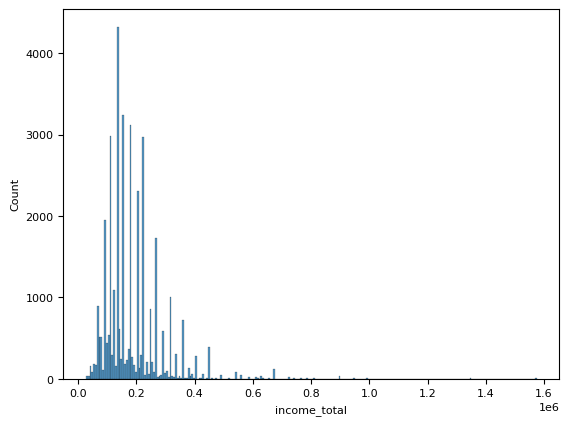

In [ ]:
sns.histplot(all_data['income_total'])

<Axes: xlabel='income_total', ylabel='Count'>

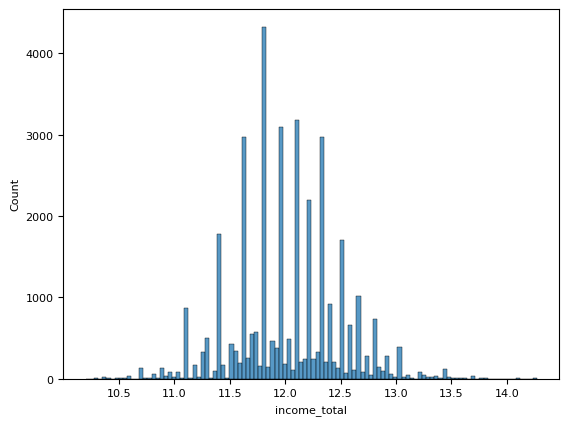

In [ ]:
all_data['income_total'] = np.log1p(all_data['income_total'])
sns.histplot(all_data['income_total'])

### 범주가 2개인 변수 인코딩
* gender, car, reality

In [ ]:
all_data['gender'] = all_data['gender'].map({"M":0,
                                             "F":1})
all_data['car'] = all_data['car'].map({"N":0,
                                       "Y":1})
all_data['reality'] = all_data['reality'].map({"N":0,
                                               "Y":1})
all_data.head()

gender  car  reality  income_total           income_type  \
0       1    0        0     12.218500  Commercial associate   
1       1    0        1     12.419170  Commercial associate   
2       0    1        1     13.017005               Working   
3       1    0        1     12.218500  Commercial associate   
4       1    1        1     11.967187         State servant   

                        edu_type     family_type           house_type  \
0               Higher education         Married  Municipal apartment   
1  Secondary / secondary special  Civil marriage    House / apartment   
2               Higher education         Married    House / apartment   
3  Secondary / secondary special         Married    House / apartment   
4               Higher education         Married    House / apartment   

   DAYS_EMPLOYED  work_phone  phone  email   occyp_type  begin_month  credit  \
0       8.457231           0      0      0      unknown         -6.0     1.0   
1       7.339538           0      0      1     Laborers         -5.0     1.0   
2       8.397057           0      1      0     Managers        -22.0     2.0   
3       7.645876           0      1      0  Sales staff        -37.0     0.0   
4       7.652071           0      0      0     Managers        -26.0     2.0   

       ID  child_family  Age  
0  3096.0     -0.420886   38  
1  7301.0      0.984226   31  
2  5063.0     -0.420886   52  
3  3128.0     -0.420886   41  
4  1917.0     -0.420886   41

### 원핫인코딩 or 레이블인코딩
family_type, house_type, income_type, edu_type, occyp_type

In [ ]:
enc_ft = ['family_type', 'house_type', 'income_type', 'edu_type', 'occyp_type']
all_data_ohe = all_data.copy()
all_data_le = all_data.copy()

원핫인코딩

In [ ]:
# 원핫인코딩
all_data_ohe = pd.get_dummies(all_data, columns = enc_ft)
print(all_data_ohe.shape)
all_data_ohe.head()

(36457, 54)


gender  car  reality  income_total  DAYS_EMPLOYED  work_phone  phone  \
0       1    0        0     12.218500       8.457231           0      0   
1       1    0        1     12.419170       7.339538           0      0   
2       0    1        1     13.017005       8.397057           0      1   
3       1    0        1     12.218500       7.645876           0      1   
4       1    1        1     11.967187       7.652071           0      0   

   email  begin_month  credit  ...  occyp_type_Managers  \
0      0         -6.0     1.0  ...                    0   
1      1         -5.0     1.0  ...                    0   
2      0        -22.0     2.0  ...                    1   
3      0        -37.0     0.0  ...                    0   
4      0        -26.0     2.0  ...                    1   

   occyp_type_Medicine staff  occyp_type_Pensioner  \
0                          0                     0   
1                          0                     0   
2                          0                     0   
3                          0                     0   
4                          0                     0   

   occyp_type_Private service staff  occyp_type_Realty agents  \
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   

   occyp_type_Sales staff  occyp_type_Secretaries  occyp_type_Security staff  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       1                       0                          0   
4                       0                       0                          0   

   occyp_type_Waiters/barmen staff  occyp_type_unknown  
0                                0                   1  
1                                0                   0  
2                                0                   0  
3                                0                   0  
4                                0                   0  

[5 rows x 54 columns]

In [ ]:
train_ohe = all_data_ohe[:len(train_0)]
test_ohe = all_data_ohe[len(train_0):]

train_ohe.to_csv("train_ohe.csv")
test_ohe.to_csv("test_ohe.csv")

레이블 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

for ft in enc_ft :
  le = LabelEncoder()
  all_data_le[ft] = le.fit_transform(all_data[ft])

print(all_data_le.shape)
all_data_le.head()

(36457, 18)


gender  car  reality  income_total  income_type  edu_type  family_type  \
0       1    0        0     12.218500            0         1            1   
1       1    0        1     12.419170            0         4            0   
2       0    1        1     13.017005            4         1            1   
3       1    0        1     12.218500            0         4            1   
4       1    1        1     11.967187            2         1            1   

   house_type  DAYS_EMPLOYED  work_phone  phone  email  occyp_type  \
0           2       8.457231           0      0      0          19   
1           1       7.339538           0      0      1           8   
2           1       8.397057           0      1      0          10   
3           1       7.645876           0      1      0          15   
4           1       7.652071           0      0      0          10   

   begin_month  credit      ID  child_family  Age  
0         -6.0     1.0  3096.0     -0.420886   38  
1         -5.0     1.0  7301.0      0.984226   31  
2        -22.0     2.0  5063.0     -0.420886   52  
3        -37.0     0.0  3128.0     -0.420886   41  
4        -26.0     2.0  1917.0     -0.420886   41

In [ ]:
train_le = all_data_le[:len(train_0)]
test_le = all_data_le[len(train_0):]

train_le.to_csv("train_le.csv")
test_le.to_csv("test_le.csv")

## 4. 차원축소(PCA)와 클러스터링(K-Means)

### Ver. 변수 53개

In [ ]:
train=pd.read_csv('train_ohe.csv', index_col=0)
test=pd.read_csv('test_ohe.csv', index_col=0)

차원축소와 군집분석

비지도학습

In [ ]:
train_un = train.drop(['credit'], axis=1)

In [ ]:
train_un.head(3)

gender  car  reality  income_total  DAYS_EMPLOYED  work_phone  phone  \
0       1    0        0     12.218500       8.457231           0      0   
1       1    0        1     12.419170       7.339538           0      0   
2       0    1        1     13.017005       8.397057           0      1   

   email  begin_month      ID  ...  occyp_type_Managers  \
0      0         -6.0  3096.0  ...                    0   
1      1         -5.0  7301.0  ...                    0   
2      0        -22.0  5063.0  ...                    1   

   occyp_type_Medicine staff  occyp_type_Pensioner  \
0                          0                     0   
1                          0                     0   
2                          0                     0   

   occyp_type_Private service staff  occyp_type_Realty agents  \
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   

   occyp_type_Sales staff  occyp_type_Secretaries  occyp_type_Security staff  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   

   occyp_type_Waiters/barmen staff  occyp_type_unknown  
0                                0                   1  
1                                0                   0  
2                                0                   0  

[3 rows x 53 columns]

스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_ss1 = ss.fit_transform(train_un)
df_ss = pd.DataFrame(df_ss1, columns = train_un.columns)
df_ss.index = train_un.index
df_ss

gender       car   reality  income_total  DAYS_EMPLOYED  work_phone  \
0      0.703562 -0.782463 -1.437626      0.408528       0.767553   -0.538417   
1      0.703562 -0.782463  0.695591      0.825883       0.387225   -0.538417   
2     -1.421339  1.278015  0.695591      2.069264       0.747077   -0.538417   
3      0.703562 -0.782463  0.695591      0.408528       0.491466   -0.538417   
4      0.703562  1.278015  0.695591     -0.114154       0.493574   -0.538417   
...         ...       ...       ...           ...            ...         ...   
26452  0.703562 -0.782463 -1.437626      0.627657       0.473429   -0.538417   
26453  0.703562 -0.782463  0.695591      0.163564       0.548673   -0.538417   
26454  0.703562  1.278015 -1.437626      1.173322       0.478705   -0.538417   
26455 -1.421339 -0.782463  0.695591      0.056884      -0.520201   -0.538417   
26456  0.703562 -0.782463 -1.437626     -1.497164       0.244694   -0.538417   

          phone     email  begin_month        ID  ...  occyp_type_Managers  \
0     -0.645705 -0.316937     1.215231 -0.519132  ...            -0.298612   
1     -0.645705  3.155199     1.275620  1.150420  ...            -0.298612   
2      1.548696 -0.316937     0.249003  0.261845  ...             3.348833   
3      1.548696 -0.316937    -0.656836 -0.506427  ...            -0.298612   
4     -0.645705 -0.316937     0.007446 -0.987242  ...             3.348833   
...         ...       ...          ...       ...  ...                  ...   
26452 -0.645705 -0.316937     1.456788  1.546666  ...            -0.298612   
26453 -0.645705 -0.316937    -1.260729  1.002325  ...            -0.298612   
26454 -0.645705 -0.316937     0.067835  0.021636  ...            -0.298612   
26455 -0.645705 -0.316937    -1.985400 -0.811751  ...            -0.298612   
26456 -0.645705 -0.316937     1.034063  0.463541  ...            -0.298612   

       occyp_type_Medicine staff  occyp_type_Pensioner  \
0                      -0.183627             -0.449615   
1                      -0.183627             -0.449615   
2                      -0.183627             -0.449615   
3                      -0.183627             -0.449615   
4                      -0.183627             -0.449615   
...                          ...                   ...   
26452                  -0.183627             -0.449615   
26453                  -0.183627             -0.449615   
26454                  -0.183627             -0.449615   
26455                  -0.183627             -0.449615   
26456                  -0.183627             -0.449615   

       occyp_type_Private service staff  occyp_type_Realty agents  \
0                              -0.09628                 -0.048856   
1                              -0.09628                 -0.048856   
2                              -0.09628                 -0.048856   
3                              -0.09628                 -0.048856   
4                              -0.09628                 -0.048856   
...                                 ...                       ...   
26452                          -0.09628                 -0.048856   
26453                          -0.09628                 -0.048856   
26454                          -0.09628                 -0.048856   
26455                          -0.09628                 -0.048856   
26456                          -0.09628                 -0.048856   

       occyp_type_Sales staff  occyp_type_Secretaries  \
0                   -0.325813               -0.060662   
1                   -0.325813               -0.060662   
2                   -0.325813               -0.060662   
3                    3.069242               -0.060662   
4                   -0.325813               -0.060662   
...                       ...                     ...   
26452               -0.325813               -0.060662   
26453               -0.325813               -0.060662   
26454               -0.325813               -0.060662   
26455          

주성분 개수 결정

In [ ]:
# 모든 독립변수개수만큼 주성분 개수 설정해서 분석
from sklearn.decomposition import PCA
pca = PCA(n_components=53)
pca_array = pca.fit_transform(df_ss)
pca_df = pd.DataFrame(pca_array, index=df_ss.index, columns=[f"pca{num+1}" for num in range(df_ss.shape[1])])
pca_df.head()

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0 -1.262903  1.127076 -2.434367  3.498649  1.153583  0.879016  0.146433   
1 -0.985941 -0.265376 -0.695721 -1.065484 -0.855971  3.725698 -1.687665   
2 -1.612688  2.654557  0.996691 -0.250566 -1.860513 -2.008461  0.143701   
3 -0.035675 -0.117042  0.040527 -0.959609  0.545131  1.938586 -1.148227   
4 -0.739298  3.177075  0.015760 -0.378473  0.116331 -0.341845  2.486538   

       pca8      pca9     pca10  ...     pca44     pca45     pca46     pca47  \
0 -1.752806 -2.129268  0.968785  ... -0.014664 -0.360445 -0.000644 -0.302530   
1  1.602928  0.786465 -0.214093  ...  0.694952 -0.677468 -0.278076 -0.082157   
2 -0.263763  0.020098  2.023364  ... -0.216379  0.750539 -0.281476 -0.125397   
3 -2.216931 -1.232163  0.028764  ... -0.489518 -0.064072 -0.118614 -0.091394   
4  0.117007 -0.236906  0.985107  ...  0.692183 -0.761505  0.208043  0.073885   

          pca48         pca49         pca50         pca51         pca52  \
0  1.325893e-13  1.916122e-14  5.397262e-15  7.394009e-15 -3.321590e-15   
1 -3.188356e-14  9.667390e-14  1.312628e-15  1.125424e-14  2.627967e-15   
2  1.983386e-15 -1.778488e-14  3.829028e-14  2.715106e-14  8.613552e-15   
3  2.213712e-15 -7.466834e-15 -2.837540e-14  9.026346e-15 -3.684786e-16   
4 -7.603145e-15 -2.791785e-15  3.638925e-14 -1.294399e-14  1.503274e-15   

          pca53  
0 -1.069182e-15  
1 -2.891630e-15  
2 -5.976971e-15  
3 -2.447599e-15  
4  3.747574e-15  

[5 rows x 53 columns]

In [ ]:
# 주성분 설명력과 기여율
result = pd.DataFrame({'고윳값':pca.explained_variance_,
                       '기여율':pca.explained_variance_ratio_},
                      index=np.array([f"pca{num+1}" for num in range(df_ss.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

고윳값           기여율     누적기여율
pca1   4.556107e+00  8.596104e-02  0.085961
pca2   2.372501e+00  4.476249e-02  0.130724
pca3   2.249259e+00  4.243725e-02  0.173161
pca4   1.934674e+00  3.650191e-02  0.209663
pca5   1.765269e+00  3.330570e-02  0.242968
pca6   1.557406e+00  2.938391e-02  0.272352
pca7   1.391791e+00  2.625922e-02  0.298612
pca8   1.378980e+00  2.601750e-02  0.324629
pca9   1.308847e+00  2.469428e-02  0.349323
pca10  1.254458e+00  2.366813e-02  0.372991
pca11  1.188283e+00  2.241958e-02  0.395411
pca12  1.151963e+00  2.173432e-02  0.417145
pca13  1.119676e+00  2.112516e-02  0.438270
pca14  1.107325e+00  2.089214e-02  0.459163
pca15  1.090221e+00  2.056943e-02  0.479732
pca16  1.070263e+00  2.019288e-02  0.499925
pca17  1.062710e+00  2.005037e-02  0.519975
pca18  1.055150e+00  1.990773e-02  0.539883
pca19  1.046052e+00  1.973609e-02  0.559619
pca20  1.041440e+00  1.964907e-02  0.579268
pca21  1.031892e+00  1.946893e-02  0.598737
pca22  1.024644e+00  1.933217e-02  0.618069
pca23  1.013683e+00  1.912537e-02  0.637195
pca24  1.012519e+00  1.910341e-02  0.656298
pca25  1.006387e+00  1.898771e-02  0.675286
pca26  9.984988e-01  1.883889e-02  0.694125
pca27  9.971066e-01  1.881262e-02  0.712937
pca28  9.927971e-01  1.873131e-02  0.731669
pca29  9.909049e-01  1.869561e-02  0.750364
pca30  9.803503e-01  1.849648e-02  0.768861
pca31  9.726894e-01  1.835194e-02  0.787213
pca32  9.681222e-01  1.826577e-02  0.805478
pca33  9.579411e-01  1.807368e-02  0.823552
pca34  9.531028e-01  1.798239e-02  0.841534
pca35  9.486092e-01  1.789761e-02  0.859432
pca36  9.193419e-01  1.734542e-02  0.876778
pca37  9.104685e-01  1.717800e-02  0.893956
pca38  8.344645e-01  1.574402e-02  0.909700
pca39  8.174976e-01  1.542390e-02  0.925123
pca40  7.836358e-01  1.478502e-02  0.939908
pca41  7.589616e-01  1.431949e-02  0.954228
pca42  6.933085e-01  1.308080e-02  0.967309
pca43  5.886882e-01  1.110690e-02  0.978416
pca44  4.790202e-01  9.037776e-03  0.987453
pca45  3.999081e-01  7.545150e-03  0.994999
pca46  2.052641e-01  3.872761e-03  0.998871
pca47  5.982185e-02  1.128672e-03  1.000000
pca48  8.984090e-31  1.695047e-32  1.000000
pca49  4.968829e-31  9.374794e-33  1.000000
pca50  2.978769e-31  5.620106e-33  1.000000
pca51  2.123543e-31  4.006534e-33  1.000000
pca52  4.462073e-32  8.418687e-34  1.000000
pca53  1.018539e-32  1.921699e-34  1.000000

* 주성분의 개수 정하는 기준 (OR)
  1. 고윳값이 0.7이상인 주성분     
  = 39개 이하
  2. 누적기여율이 0.8 이상이 넘어가지는 지점의 주성분     = 31->32개
  3. Scree Plot에서 완만해지는 지점


A. 주성분 개수 = 최적 11개




* PCA 수행

In [ ]:
# 이제 PCA 변환
from sklearn.decomposition import PCA

pca_11=PCA(n_components=11) #PCA로 변환할 차원의 수를 의미.

#fit과 transform 호출해 PCA 변환 데이터 반환
pca_11.fit(df_ss)
df_ss_pca_11=pca_11.transform(df_ss)
print(df_ss_pca_11.shape)

(26457, 11)


In [ ]:
# PCA 변환된 데이터의 칼럼 명을 지정.
pca_columns=[f"pca{num+1}" for num in range(df_ss_pca_11.shape[1])]
df_ss_pca_11=pd.DataFrame(df_ss_pca_11, columns=pca_columns)
df_ss_pca_11.head(3)

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0 -1.262673  1.144386 -2.445725  3.489373  1.057813  1.264063 -0.306478   
1 -0.986836 -0.273101 -0.690287 -1.128078 -0.941228  3.470112  2.198488   
2 -1.612714  2.660841  0.999058 -0.210836 -1.773277 -2.047801 -0.522873   

       pca8      pca9     pca10     pca11  
0  1.693074  1.963620 -0.523026  1.184823  
1 -1.080686 -0.550807  0.345352 -1.852133  
2  0.136476  0.126653 -1.889486 -0.151134

In [ ]:
# pca component 별로 원본 데이터의 변동성을 얼마나 잘 반영하고 있는지
print(pca_11.explained_variance_ratio_)
print(pca_11.explained_variance_ratio_.sum())

[0.0859609  0.04474676 0.04241791 0.03646054 0.03320936 0.0283833
 0.02586836 0.02551299 0.02410869 0.02274333 0.02165298]
0.3910651339976458


* 군집개수 결정

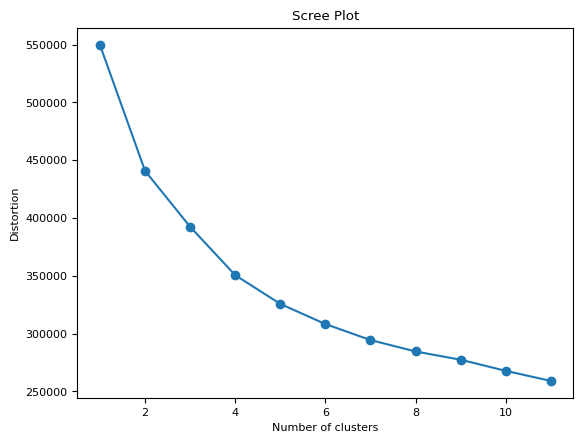

In [ ]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 12):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_ss_pca_11)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 12), distortions, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

최적 군집 개수 6개로!

In [ ]:
kmeans=KMeans(n_clusters=6,init='k-means++',max_iter=300,random_state=0)
kmeans.fit(df_ss_pca_11)
#fit 수행하여 irisDF 데이터에 대한 군집화 수행 결과가 kmeans 객체 변수로 변환

#kmeans의 labels_속성값 통해 irisDF의 각 데이터가 어떤 중심에 속하는지를 알 수 있다
print(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[5 4 2 ... 5 4 4]


In [ ]:
df_ss_pca_11_with = df_ss_pca_11.copy()
df_ss_pca_11_with['cluster'] = kmeans.labels_
df_ss_pca_11_with

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0     -1.262673  1.144386 -2.445725  3.489373  1.057813  1.264063 -0.306478   
1     -0.986836 -0.273101 -0.690287 -1.128078 -0.941228  3.470112  2.198488   
2     -1.612714  2.660841  0.999058 -0.210836 -1.773277 -2.047801 -0.522873   
3     -0.035422 -0.124607  0.043913 -1.016870  0.489896  1.462867  0.922049   
4     -0.739325  3.168108  0.023053 -0.344988  0.200319  0.010498 -2.518771   
...         ...       ...       ...       ...       ...       ...       ...   
26452 -1.305140  0.681495  1.077279  0.241407  2.599615  2.133748 -1.594785   
26453 -0.845507  1.184769 -1.304977 -1.382695  0.830303 -0.580047  1.105785   
26454 -1.905916 -1.433922 -2.914495  2.960622  0.494916  1.081283  0.905485   
26455 -0.667503 -0.673279 -2.200885 -0.877182 -2.252735 -2.037127  0.466219   
26456  0.415270 -2.302758 -0.740789 -0.902463  0.099576  0.717072  0.788903   

           pca8      pca9     pca10     pca11  cluster  
0      1.693074  1.963620 -0.523026  1.184823        5  
1     -1.080686 -0.550807  0.345352 -1.852133        4  
2      0.136476  0.126653 -1.889486 -0.151134        2  
3      2.307313  1.743097  0.189111 -0.227505        3  
4     -0.479554  0.263389 -0.734145 -0.055652        2  
...         ...       ...       ...       ...      ...  
26452 -1.976871 -2.113769  0.934230 -0.631037        3  
26453 -1.280149 -0.395151 -2.015975  2.404973        2  
26454 -1.453844 -1.942129 -0.378933 -0.960939        5  
26455 -1.542801  0.351209  2.508256  1.156305        4  
26456 -0.483780 -2.033869 -1.115923  0.636016        4  

[26457 rows x 12 columns]

B. 주성분 개수 = 시각화 편의 위해 3개

* PCA 수행

In [ ]:
# 이제 PCA 변환
from sklearn.decomposition import PCA

pca_3=PCA(n_components=3) #PCA로 변환할 차원의 수를 의미.

#fit과 transform 호출해 PCA 변환 데이터 반환
pca_3.fit(df_ss)
df_ss_pca_3=pca_3.transform(df_ss)
print(df_ss_pca_3.shape)

(26457, 3)


In [ ]:
# PCA 변환된 데이터의 칼럼 명을 지정.
pca_columns=[f"pca{num+1}" for num in range(df_ss_pca_3.shape[1])]
df_ss_pca_3=pd.DataFrame(df_ss_pca_3, columns=pca_columns)
df_ss_pca_3.head(3)

pca1      pca2      pca3
0 -1.262899  1.126285 -2.436760
1 -0.985945 -0.265515 -0.696683
2 -1.612694  2.654243  0.998494

In [ ]:
# pca component 별로 원본 데이터의 변동성을 얼마나 잘 반영하고 있는지
print(pca_3.explained_variance_ratio_)
print(pca_3.explained_variance_ratio_.sum())

[0.08596104 0.04476239 0.04243674]
0.1731601690246237


* 군집 개수 결정

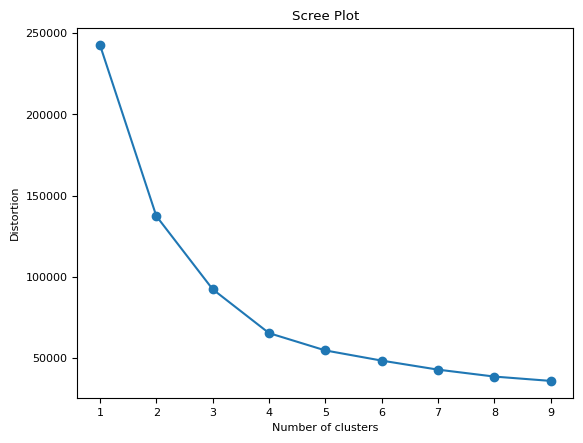

In [ ]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_ss_pca_3)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 10), distortions, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

최적 군집 개수 4개로!

In [ ]:
kmeans=KMeans(n_clusters=4,init='k-means++',max_iter=300,random_state=0)
kmeans.fit(df_ss_pca_3)
#fit 수행하여 irisDF 데이터에 대한 군집화 수행 결과가 kmeans 객체 변수로 변환

#kmeans의 labels_속성값 통해 irisDF의 각 데이터가 어떤 중심에 속하는지를 알 수 있다
print(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 2 ... 0 0 0]


In [ ]:
df_ss_pca_3_with = df_ss_pca_3.copy()
df_ss_pca_3_with['cluster'] = kmeans.labels_
df_ss_pca_3_with

pca1      pca2      pca3  cluster
0     -1.262899  1.126285 -2.436760        0
1     -0.985945 -0.265515 -0.696683        0
2     -1.612694  2.654243  0.998494        2
3     -0.035670 -0.116250  0.044657        3
4     -0.739299  3.177069  0.017212        2
...         ...       ...       ...      ...
26452 -1.304935  0.695241  1.071441        3
26453 -0.846470  1.164816 -1.275763        2
26454 -1.904695 -1.419502 -2.917301        0
26455 -0.667724 -0.670552 -2.198896        0
26456  0.415812 -2.303131 -0.749312        0

[26457 rows x 4 columns]

군집분석 시각화1

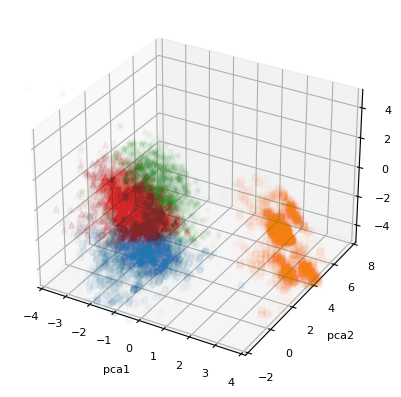

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#군집 값이 0,1,2인 경우마다 별도의 인덱스로 추출
marker0_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==0].index
marker1_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==1].index
marker2_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==2].index
marker3_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==3].index

#군집 값 0,1,2에 해당하는 인덱스로 각 군집 레벨의 pca_x,pca_y 값 추출.o,s,^로 마커 표시
ax.scatter(xs=df_ss_pca_3_with.loc[marker0_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker0_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker0_ind,'pca3'], marker='o', alpha=0.01)
ax.scatter(xs=df_ss_pca_3_with.loc[marker1_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker1_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker1_ind,'pca3'], marker='s', alpha=0.01)
ax.scatter(xs=df_ss_pca_3_with.loc[marker2_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker2_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker2_ind,'pca3'], marker='*', alpha=0.01)
ax.scatter(xs=df_ss_pca_3_with.loc[marker3_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker3_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker3_ind,'pca3'], marker='^', alpha=0.01)

ax.set_xlabel("pca1")
ax.set_ylabel("pca2")
ax.set_zlabel("pca3")

ax.set_xlim(-4,4)
ax.set_ylim(-2,8)
ax.set_zlim(-5,5)

plt.show()

군집분석 시각화2

In [ ]:
# score
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_ss1 = ss.fit_transform(train_un)

pca_3=PCA(n_components=3)
pca_3.fit(df_ss1)
score = pca_3.transform(df_ss1)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

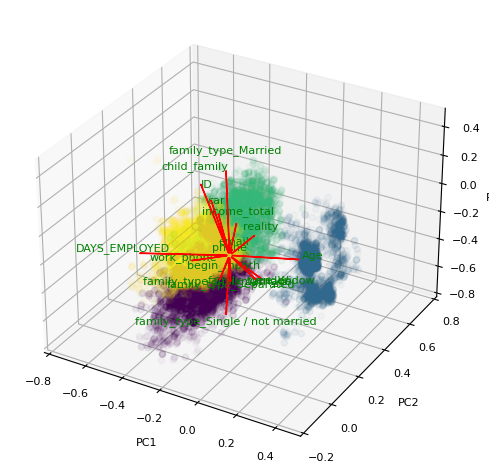

In [ ]:
def biplot(score,coeff,pcax,pcay,pcaz, labels=None):
  pca1=pcax-1
  pca2=pcay-1
  pca3=pcaz-1
  xs = score[:,pca1]
  ys = score[:,pca2]
  zs = score[:,pca3]
  #n=score.shape[1]
  n=17
  scalex = 1.0/(xs.max()- xs.min())
  scaley = 1.0/(ys.max()- ys.min())
  scalez = 1.0/(zs.max()- zs.min())

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(xs*scalex, ys*scaley, zs*scalez, c=kmeans.labels_, alpha=0.03)

  coeff = coeff.T

  for i in range(n):
    ax.arrow3D(0, 0, 0, coeff[i,pca1], coeff[i,pca2], coeff[i,pca3], color='r')
    if labels is None:
      ax.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, coeff[i,pca3] * 1.15, "Var"+str(i+1), color='g', ha='right', va='right')
    else:
      ax.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, coeff[i,pca3] * 1.15, labels[i], color='g', ha='center', va='bottom')

  ax.set_xlim(-0.8,0.5)
  ax.set_ylim(-0.2,0.8)
  ax.set_zlim(-0.8,0.5)

  ax.set_xlabel("PC{}".format(pcax))
  ax.set_ylabel("PC{}".format(pcay))
  ax.set_zlabel("PC{}".format(pcaz))

  plt.tight_layout()
  plt.grid()

biplot(score, pca_3.components_, 1, 2, 3, labels=train_un.columns)

C. 주성분 개수 = 시각화 편의 위해 2개

* PCA 수행

In [ ]:
# 이제 PCA 변환
from sklearn.decomposition import PCA

pca_2=PCA(n_components=2) #PCA로 변환할 차원의 수를 의미.

#fit과 transform 호출해 PCA 변환 데이터 반환
pca_2.fit(df_ss)
df_ss_pca_2=pca_2.transform(df_ss)
print(df_ss_pca_2.shape)

(26457, 2)


In [ ]:
# PCA 변환된 데이터의 칼럼 명을 지정.
pca_columns=[f"pca{num+1}" for num in range(df_ss_pca_2.shape[1])]
df_ss_pca_2=pd.DataFrame(df_ss_pca_2, columns=pca_columns)
df_ss_pca_2.head(3)

pca1      pca2
0 -1.262880  1.136917
1 -0.985947 -0.262593
2 -1.612691  2.657650

In [ ]:
# pca component 별로 원본 데이터의 변동성을 얼마나 잘 반영하고 있는지
print(pca_2.explained_variance_ratio_)
print(pca_2.explained_variance_ratio_.sum())

[0.08596104 0.04476042]
0.13072145404550894


* 군집 개수 결정

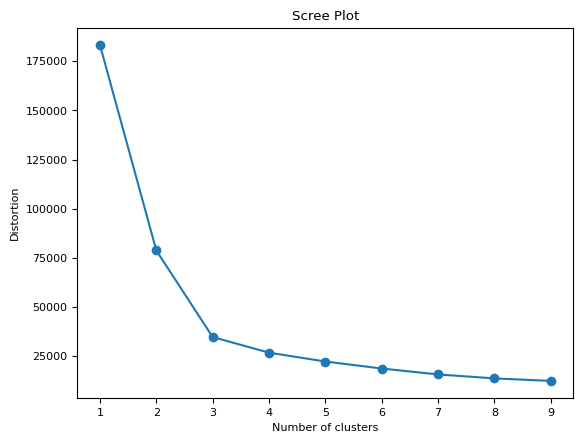

In [ ]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_ss_pca_2)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 10), distortions, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

최적 군집 개수 4개로!

In [ ]:
kmeans=KMeans(n_clusters=3,init='k-means++',max_iter=300,random_state=0)
kmeans.fit(df_ss_pca_2)
#fit 수행하여 irisDF 데이터에 대한 군집화 수행 결과가 kmeans 객체 변수로 변환

#kmeans의 labels_속성값 통해 irisDF의 각 데이터가 어떤 중심에 속하는지를 알 수 있다
print(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 0 ... 1 1 1]


In [ ]:
df_ss_pca_2_with = df_ss_pca_2.copy()
df_ss_pca_2_with['cluster'] = kmeans.labels_
df_ss_pca_2_with

pca1      pca2  cluster
0     -1.262880  1.136917        0
1     -0.985947 -0.262593        1
2     -1.612691  2.657650        0
3     -0.035687 -0.117805        1
4     -0.739295  3.177485        0
...         ...       ...      ...
26452 -1.304901  0.697963        0
26453 -0.846425  1.171018        0
26454 -1.904718 -1.429266        1
26455 -0.667750 -0.668790        1
26456  0.415858 -2.300033        1

[26457 rows x 3 columns]

군집분석 시각화1

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


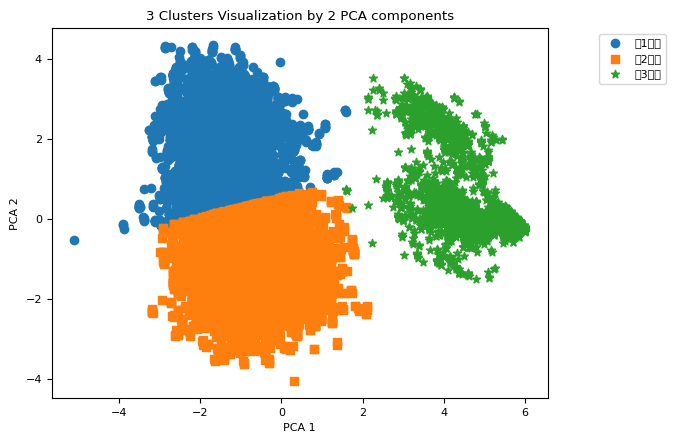

In [ ]:
#군집 값이 0,1,2인 경우마다 별도의 인덱스로 추출
marker0_ind=df_ss_pca_2_with[df_ss_pca_2_with['cluster']==0].index
marker1_ind=df_ss_pca_2_with[df_ss_pca_2_with['cluster']==1].index
marker2_ind=df_ss_pca_2_with[df_ss_pca_2_with['cluster']==2].index


#군집 값 0,1,2에 해당하는 인덱스로 각 군집 레벨의 pca_x,pca_y 값 추출.o,s,^로 마커 표시
plt.scatter(x=df_ss_pca_2_with.loc[marker0_ind,'pca1'],y=df_ss_pca_2_with.loc[marker0_ind,'pca2'],marker='o')
plt.scatter(x=df_ss_pca_2_with.loc[marker1_ind,'pca1'],y=df_ss_pca_2_with.loc[marker1_ind,'pca2'],marker='s')
plt.scatter(x=df_ss_pca_2_with.loc[marker2_ind,'pca1'],y=df_ss_pca_2_with.loc[marker2_ind,'pca2'],marker='*')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA components')
plt.legend(('제1그룹','제2그룹', '제3그룹', '제4그룹'),loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.show()

군집분석 시각화2

In [ ]:
# score
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_ss1 = ss.fit_transform(train_un)

pca_2=PCA(n_components=2)
pca_2.fit(df_ss1)
score = pca_2.transform(df_ss1)
print(df_ss1.shape)

(26457, 53)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


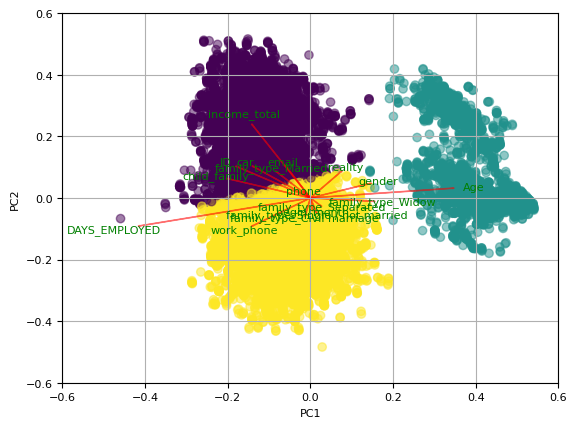

In [ ]:
def biplot_both(score,coeff,pcax,pcay,labels=None):
  pca1=pcax-1
  pca2=pcay-1
  xs = score[:,pca1]
  ys = score[:,pca2]
  #n=score.shape[1]
  n=17
  scalex = 1.0/(xs.max()- xs.min())
  scaley = 1.0/(ys.max()- ys.min())

  kmeans=KMeans(n_clusters=3,init='k-means++',max_iter=300,random_state=0)
  kmeans.fit(score)

  coeff = coeff.T

  plt.scatter(xs*scalex,ys*scaley, c=kmeans.labels_, alpha=0.5)

  for i in range(n):
    plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
    if labels is None:
      plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    else:
      plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
  plt.xlim(-0.6,0.6)
  plt.ylim(-0.6,0.6)

  plt.xlabel("PC{}".format(pcax))
  plt.ylabel("PC{}".format(pcay))
 # plt.legend(('제1그룹','제2그룹', '제3그룹', '제4그룹'),loc='upper right', bbox_to_anchor=(1.25, 1.0))
  plt.grid()

biplot_both(score, pca_2.components_,  1, 2,  labels=train_un.columns)

* 축 설명
  1. PCA1 : PCA1에 대해 Age, Gender 가 강한 양의 부하량을 갖고 있고,     
  DAYS_EMPLOYED, work_phone이 강한 음의 부하량을 갖고 있음
  2. PCA2 : PCA2에 대해 income_total이 강한 양의 부하량을 갖고 있음.


* 그룹 설명
  1. 초록색 그룹 : PCA1 수준이 높고 PCA2 수준이 높은 그룹
  -> 나이가 많고 성별이 여성이 많고 일한날수가 적으며, 총소득이 높은 그룹
  2. 노란색 그룹 : PCA1 수준이 낮고 PCA2 수준이 낮은 그룹
  -> 나이가 적고 성별이 남성이 많고 일한날수가 많으며, 총소득이 낮은 그룹
  3. 보라색 그룹 : PCA1 수준이 낮고 PCA2 수준이 높은 그룹
  -> 나이가 적고 성별이 남성이 많고 일한날수가 많으며, 총소득이 높은 그룹
  


### Ver. 변수 9개

In [ ]:
train_un = pd.read_csv("train_img.csv", index_col=0)
train_un.head()

begin_month      ID  Age  DAYS_EMPLOYED  income_total  child_family  \
0         -6.0  3096.0   38       8.457231     12.218500     -0.420886   
1         -5.0  7301.0   31       7.339538     12.419170      0.984226   
2        -22.0  5063.0   52       8.397057     13.017005     -0.420886   
3        -37.0  3128.0   41       7.645876     12.218500     -0.420886   
4        -26.0  1917.0   41       7.652071     11.967187     -0.420886   

   family_type_Married  income_type_Pensioner  \
0                    1                      0   
1                    0                      0   
2                    1                      0   
3                    1                      0   
4                    1                      0   

   income_type_Commercial associate  
0                                 1  
1                                 1  
2                                 0  
3                                 1  
4                                 0

스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_ss1 = ss.fit_transform(train_un)
df_ss = pd.DataFrame(df_ss1, columns = train_un.columns)
df_ss.index = train_un.index
df_ss

begin_month        ID       Age  DAYS_EMPLOYED  income_total  \
0         1.215231 -0.519132 -0.452819       0.767553      0.408528   
1         1.275620  1.150420 -1.060808       0.387225      0.825883   
2         0.249003  0.261845  0.763158       0.747077      2.069264   
3        -0.656836 -0.506427 -0.192253       0.491466      0.408528   
4         0.007446 -0.987242 -0.192253       0.493574     -0.114154   
...            ...       ...       ...            ...           ...   
26452     1.456788  1.546666 -0.887097       0.473429      0.627657   
26453    -1.260729  1.002325 -0.192253       0.548673      0.163564   
26454     0.067835  0.021636 -1.408230       0.478705      1.173322   
26455    -1.985400 -0.811751 -1.408230      -0.520201      0.056884   
26456     1.034063  0.463541  0.850013       0.244694     -1.497164   

       child_family  family_type_Married  income_type_Pensioner  \
0         -0.365568             0.673796              -0.449615   
1          0.854866            -1.484129              -0.449615   
2         -0.365568             0.673796              -0.449615   
3         -0.365568             0.673796              -0.449615   
4         -0.365568             0.673796              -0.449615   
...             ...                  ...                    ...   
26452      2.075301             0.673796              -0.449615   
26453      0.175082            -1.484129              -0.449615   
26454     -0.365568            -1.484129              -0.449615   
26455     -1.045352            -1.484129              -0.449615   
26456     -0.365568            -1.484129              -0.449615   

       income_type_Commercial associate  
0                              1.807175  
1                              1.807175  
2                             -0.553350  
3                              1.807175  
4                             -0.553350  
...                                 ...  
26452                         -0.553350  
26453                         -0.553350  
26454                         -0.553350  
26455                         -0.553350  
26456                         -0.553350  

[26457 rows x 9 columns]

주성분 개수 결정

In [ ]:
# 모든 독립변수개수만큼 주성분 개수 설정해서 분석
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
pca_array = pca.fit_transform(df_ss)
pca_df = pd.DataFrame(pca_array, index=df_ss.index, columns=[f"pca{num+1}" for num in range(df_ss.shape[1])])
pca_df.head()

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0  1.009923 -1.130064 -0.177531  0.882287 -1.804355  0.553318  0.056023   
1  1.850173 -0.514796 -0.208384  2.478349  0.565620  1.012042  0.078790   
2  0.572942 -0.253607  0.945287  0.500740 -0.563847 -2.056643 -0.669768   
3  0.778100 -0.947750  1.208387 -0.165180 -1.188198  0.867236  0.155415   
4  0.074272 -0.555075 -0.397336 -0.999721 -0.661407 -0.636347  0.172357   

       pca8      pca9  
0 -0.087748 -0.288800  
1  0.273379 -0.102913  
2 -0.333610 -0.066855  
3 -0.083723 -0.052391  
4  0.145675 -0.005727

In [ ]:
# 주성분 설명력과 기여율
result = pd.DataFrame({'고윳값':pca.explained_variance_,
                       '기여율':pca.explained_variance_ratio_},
                      index=np.array([f"pca{num+1}" for num in range(df_ss.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

고윳값       기여율     누적기여율
pca1  2.890736  0.321181  0.321181
pca2  1.595776  0.177302  0.498483
pca3  1.041588  0.115728  0.614210
pca4  1.010660  0.112291  0.726501
pca5  0.884637  0.098289  0.824791
pca6  0.815348  0.090591  0.915382
pca7  0.495880  0.055096  0.970477
pca8  0.223033  0.024780  0.995258
pca9  0.042682  0.004742  1.000000

* 주성분의 개수 정하는 기준 (OR)
  1. 고윳값이 0.7이상인 주성분 = 12개 이하
  2. 누적기여율이 0.8 이상이 넘어가지는 지점의 주성분 = 10->11개
  3. Scree Plot에서 완만해지는 지점


B. 주성분 개수 = 시각화 편의 위해 3개

* PCA 수행

In [ ]:
# 이제 PCA 변환
from sklearn.decomposition import PCA

pca_3=PCA(n_components=3) #PCA로 변환할 차원의 수를 의미.

#fit과 transform 호출해 PCA 변환 데이터 반환
pca_3.fit(df_ss)
df_ss_pca_3=pca_3.transform(df_ss)
print(df_ss_pca_3.shape)

(26457, 3)


In [ ]:
# PCA 변환된 데이터의 칼럼 명을 지정.
pca_columns=[f"pca{num+1}" for num in range(df_ss_pca_3.shape[1])]
df_ss_pca_3=pd.DataFrame(df_ss_pca_3, columns=pca_columns)
df_ss_pca_3.head(3)

pca1      pca2      pca3
0  1.009923 -1.130064 -0.177531
1  1.850173 -0.514796 -0.208384
2  0.572942 -0.253607  0.945287

In [ ]:
# pca component 별로 원본 데이터의 변동성을 얼마나 잘 반영하고 있는지
print(pca_3.explained_variance_ratio_)
print(pca_3.explained_variance_ratio_.sum())

[0.32118076 0.17730175 0.1157276 ]
0.6142101048435795


* 군집 개수 결정

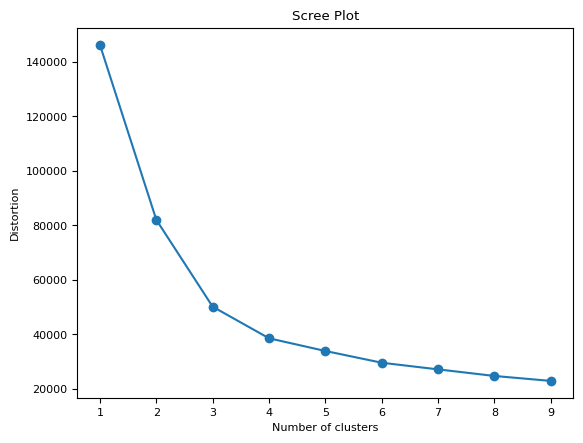

In [ ]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_ss_pca_3)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 10), distortions, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

최적 군집 개수 4개로!

In [ ]:
kmeans=KMeans(n_clusters=4,init='k-means++',max_iter=300,random_state=0)
kmeans.fit(df_ss_pca_3)
#fit 수행하여 irisDF 데이터에 대한 군집화 수행 결과가 kmeans 객체 변수로 변환

#kmeans의 labels_속성값 통해 irisDF의 각 데이터가 어떤 중심에 속하는지를 알 수 있다
print(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 3 3 ... 1 3 1]


In [ ]:
df_ss_pca_3_with = df_ss_pca_3.copy()
df_ss_pca_3_with['cluster'] = kmeans.labels_
df_ss_pca_3_with

pca1      pca2      pca3  cluster
0      1.009923 -1.130064 -0.177531        1
1      1.850173 -0.514796 -0.208384        3
2      0.572942 -0.253607  0.945287        3
3      0.778100 -0.947750  1.208387        3
4      0.074272 -0.555075 -0.397336        1
...         ...       ...       ...      ...
26452  2.131366  1.865732 -1.016683        0
26453  0.717646 -0.156777  0.566286        3
26454  0.889592 -1.266972 -0.161560        1
26455 -0.287588 -1.539918  0.671899        3
26456 -0.560782 -0.372915 -1.688956        1

[26457 rows x 4 columns]

군집분석 시각화1

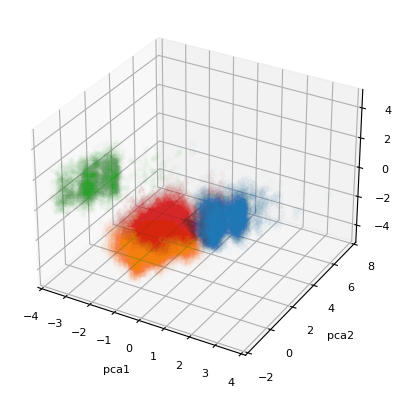

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#군집 값이 0,1,2인 경우마다 별도의 인덱스로 추출
marker0_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==0].index
marker1_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==1].index
marker2_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==2].index
marker3_ind=df_ss_pca_3_with[df_ss_pca_3_with['cluster']==3].index

#군집 값 0,1,2에 해당하는 인덱스로 각 군집 레벨의 pca_x,pca_y 값 추출.o,s,^로 마커 표시
ax.scatter(xs=df_ss_pca_3_with.loc[marker0_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker0_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker0_ind,'pca3'], marker='o', alpha=0.01)
ax.scatter(xs=df_ss_pca_3_with.loc[marker1_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker1_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker1_ind,'pca3'], marker='s', alpha=0.01)
ax.scatter(xs=df_ss_pca_3_with.loc[marker2_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker2_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker2_ind,'pca3'], marker='*', alpha=0.01)
ax.scatter(xs=df_ss_pca_3_with.loc[marker3_ind,'pca1'],ys=df_ss_pca_3_with.loc[marker3_ind,'pca2'],zs=df_ss_pca_3_with.loc[marker3_ind,'pca3'], marker='^', alpha=0.01)

ax.set_xlabel("pca1")
ax.set_ylabel("pca2")
ax.set_zlabel("pca3")

ax.set_xlim(-4,4)
ax.set_ylim(-2,8)
ax.set_zlim(-5,5)

plt.show()

군집분석 시각화2

In [ ]:
# score
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_ss1 = ss.fit_transform(train_un)

pca_3=PCA(n_components=3)
pca_3.fit(df_ss1)
score = pca_3.transform(df_ss1)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

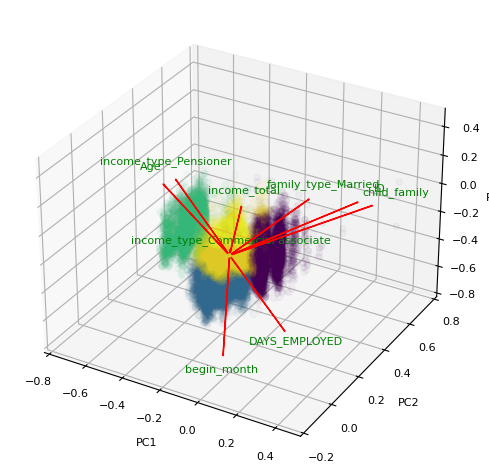

In [ ]:
def biplot(score,coeff,pcax,pcay,pcaz, labels=None):
  pca1=pcax-1
  pca2=pcay-1
  pca3=pcaz-1
  xs = score[:,pca1]
  ys = score[:,pca2]
  zs = score[:,pca3]
  #n=score.shape[1]
  n=9
  scalex = 1.0/(xs.max()- xs.min())
  scaley = 1.0/(ys.max()- ys.min())
  scalez = 1.0/(zs.max()- zs.min())

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(xs*scalex, ys*scaley, zs*scalez, c=kmeans.labels_, alpha=0.03)

  coeff = coeff.T

  for i in range(n):
    ax.arrow3D(0, 0, 0, coeff[i,pca1], coeff[i,pca2], coeff[i,pca3], color='r')
    if labels is None:
      ax.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, coeff[i,pca3] * 1.15, "Var"+str(i+1), color='g', ha='right', va='right')
    else:
      ax.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, coeff[i,pca3] * 1.15, labels[i], color='g', ha='center', va='bottom')

  ax.set_xlim(-0.8,0.5)
  ax.set_ylim(-0.2,0.8)
  ax.set_zlim(-0.8,0.5)

  ax.set_xlabel("PC{}".format(pcax))
  ax.set_ylabel("PC{}".format(pcay))
  ax.set_zlabel("PC{}".format(pcaz))

  plt.tight_layout()
  plt.grid()

biplot(score, pca_3.components_, 1, 2, 3, labels=train_un.columns)

C. 주성분 개수 = 시각화 편의 위해 2개

* PCA 수행

In [ ]:
# 이제 PCA 변환
from sklearn.decomposition import PCA

pca_2=PCA(n_components=2) #PCA로 변환할 차원의 수를 의미.

#fit과 transform 호출해 PCA 변환 데이터 반환
pca_2.fit(df_ss)
df_ss_pca_2=pca_2.transform(df_ss)
print(df_ss_pca_2.shape)

(26457, 2)


In [ ]:
# PCA 변환된 데이터의 칼럼 명을 지정.
pca_columns=[f"pca{num+1}" for num in range(df_ss_pca_2.shape[1])]
df_ss_pca_2=pd.DataFrame(df_ss_pca_2, columns=pca_columns)
df_ss_pca_2.head(3)

pca1      pca2
0  1.009923 -1.130064
1  1.850173 -0.514796
2  0.572942 -0.253607

In [ ]:
# pca component 별로 원본 데이터의 변동성을 얼마나 잘 반영하고 있는지
print(pca_2.explained_variance_ratio_)
print(pca_2.explained_variance_ratio_.sum())

[0.32118076 0.17730175]
0.49848250759007706


* 군집 개수 결정

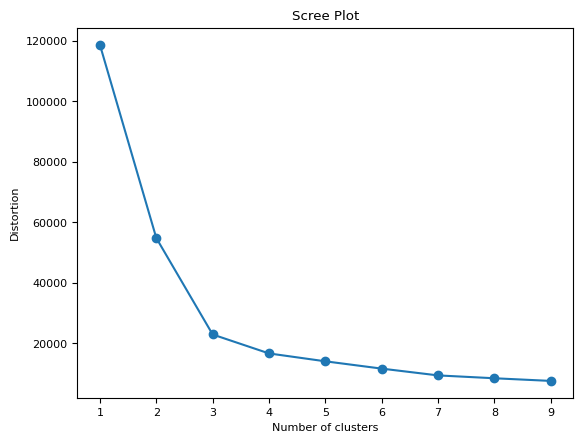

In [ ]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_ss_pca_2)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 10), distortions, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

최적 군집 개수 3개로!

In [ ]:
kmeans=KMeans(n_clusters=3,init='k-means++',max_iter=300,random_state=0)
kmeans.fit(df_ss_pca_2)
#fit 수행하여 irisDF 데이터에 대한 군집화 수행 결과가 kmeans 객체 변수로 변환

#kmeans의 labels_속성값 통해 irisDF의 각 데이터가 어떤 중심에 속하는지를 알 수 있다
print(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 1 1 1]


In [ ]:
df_ss_pca_2_with = df_ss_pca_2.copy()
df_ss_pca_2_with['cluster'] = kmeans.labels_
df_ss_pca_2_with

pca1      pca2  cluster
0      1.009923 -1.130064        1
1      1.850173 -0.514796        1
2      0.572942 -0.253607        1
3      0.778100 -0.947750        1
4      0.074272 -0.555075        1
...         ...       ...      ...
26452  2.131366  1.865732        2
26453  0.717646 -0.156777        1
26454  0.889592 -1.266972        1
26455 -0.287588 -1.539918        1
26456 -0.560782 -0.372915        1

[26457 rows x 3 columns]

군집분석 시각화1

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


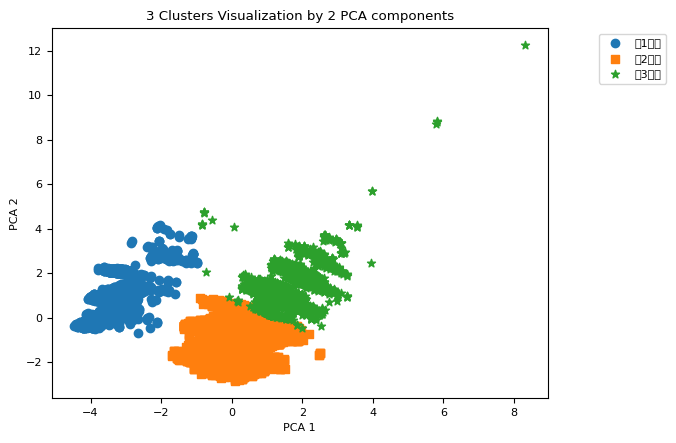

In [ ]:
#군집 값이 0,1,2인 경우마다 별도의 인덱스로 추출
marker0_ind=df_ss_pca_2_with[df_ss_pca_2_with['cluster']==0].index
marker1_ind=df_ss_pca_2_with[df_ss_pca_2_with['cluster']==1].index
marker2_ind=df_ss_pca_2_with[df_ss_pca_2_with['cluster']==2].index


#군집 값 0,1,2에 해당하는 인덱스로 각 군집 레벨의 pca_x,pca_y 값 추출.o,s,^로 마커 표시
plt.scatter(x=df_ss_pca_2_with.loc[marker0_ind,'pca1'],y=df_ss_pca_2_with.loc[marker0_ind,'pca2'],marker='o')
plt.scatter(x=df_ss_pca_2_with.loc[marker1_ind,'pca1'],y=df_ss_pca_2_with.loc[marker1_ind,'pca2'],marker='s')
plt.scatter(x=df_ss_pca_2_with.loc[marker2_ind,'pca1'],y=df_ss_pca_2_with.loc[marker2_ind,'pca2'],marker='*')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA components')
plt.legend(('제1그룹','제2그룹', '제3그룹', '제4그룹'),loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.show()

군집분석 시각화2

In [ ]:
# score
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_ss1 = ss.fit_transform(train_un)

pca_2=PCA(n_components=2)
pca_2.fit(df_ss1)
score = pca_2.transform(df_ss1)
print(df_ss1.shape)

(26457, 9)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


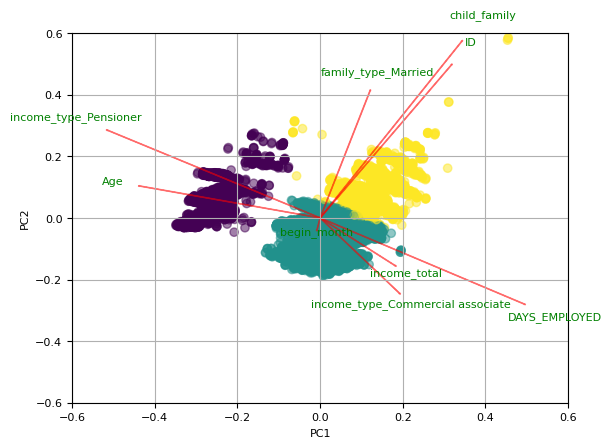

In [ ]:
def biplot_both(score,coeff,pcax,pcay,labels=None):
  pca1=pcax-1
  pca2=pcay-1
  xs = score[:,pca1]
  ys = score[:,pca2]
  #n=score.shape[1]
  n=9
  scalex = 1.0/(xs.max()- xs.min())
  scaley = 1.0/(ys.max()- ys.min())

  kmeans=KMeans(n_clusters=3,init='k-means++',max_iter=300,random_state=0)
  kmeans.fit(score)

  coeff = coeff.T

  plt.scatter(xs*scalex,ys*scaley, c=kmeans.labels_, alpha=0.5)

  for i in range(n):
    plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
    if labels is None:
      plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    else:
      plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
  plt.xlim(-0.6,0.6)
  plt.ylim(-0.6,0.6)

  plt.xlabel("PC{}".format(pcax))
  plt.ylabel("PC{}".format(pcay))
 # plt.legend(('제1그룹','제2그룹', '제3그룹', '제4그룹'),loc='upper right', bbox_to_anchor=(1.25, 1.0))
  plt.grid()

biplot_both(score, pca_2.components_,  1, 2,  labels=train_un.columns)

* 축 설명
  1. PCA1 : PCA1에 대해 DAYS_EMPLOYED, income_total, income_type_Commercial associate 가 강한 양의 부하량을 갖고 있고, Age, income_type_Pensioner 이 강한 음의 부하량을 갖고 있음
  2. PCA2 : PCA2에 대해 child_family, ID, family_type_Married 가 강한 양의 부하량을 갖고 있음.


* 그룹 설명
  1. 초록색 그룹 : PCA1 수준이 중간이고 PCA2 수준이 낮은 그룹
  2. 노란색 그룹 : PCA1 수준이 높고 PCA2 수준이 높은 그룹
  3. 보라색 그룹 : PCA1 수준이 낮고 PCA2 수준이 높은 그룹  


## 5. 이미지 변환

### A. 변수배치

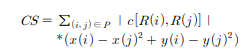

* Correlated Method 활용하여 변수 배치
* 회의결과, 피처임포턴스 기준 중요한 변수 9개만 뽑아서 이미지생성하는데 사용하기로함.

In [ ]:
train = pd.read_csv('train_ohe.csv', index_col=0)
test = pd.read_csv('test_ohe.csv', index_col=0)
train.drop('credit', axis=1, inplace=True)
print(train.shape)
train.head()

(26457, 53)


gender  car  reality  income_total  DAYS_EMPLOYED  work_phone  phone  \
0       1    0        0     12.218500       8.457231           0      0   
1       1    0        1     12.419170       7.339538           0      0   
2       0    1        1     13.017005       8.397057           0      1   
3       1    0        1     12.218500       7.645876           0      1   
4       1    1        1     11.967187       7.652071           0      0   

   email  begin_month      ID  ...  occyp_type_Managers  \
0      0         -6.0  3096.0  ...                    0   
1      1         -5.0  7301.0  ...                    0   
2      0        -22.0  5063.0  ...                    1   
3      0        -37.0  3128.0  ...                    0   
4      0        -26.0  1917.0  ...                    1   

   occyp_type_Medicine staff  occyp_type_Pensioner  \
0                          0                     0   
1                          0                     0   
2                          0                     0   
3                          0                     0   
4                          0                     0   

   occyp_type_Private service staff  occyp_type_Realty agents  \
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   

   occyp_type_Sales staff  occyp_type_Secretaries  occyp_type_Security staff  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       1                       0                          0   
4                       0                       0                          0   

   occyp_type_Waiters/barmen staff  occyp_type_unknown  
0                                0                   1  
1                                0                   0  
2                                0                   0  
3                                0                   0  
4                                0                   0  

[5 rows x 53 columns]

In [ ]:
train_img = train[['begin_month', 'ID', 'Age', 'DAYS_EMPLOYED', 'income_total', 'child_family', 'family_type_Married', 'income_type_Pensioner', 'income_type_Commercial associate']]

In [ ]:
train_img.head()

begin_month      ID  Age  DAYS_EMPLOYED  income_total  child_family  \
0         -6.0  3096.0   38       8.457231     12.218500     -0.420886   
1         -5.0  7301.0   31       7.339538     12.419170      0.984226   
2        -22.0  5063.0   52       8.397057     13.017005     -0.420886   
3        -37.0  3128.0   41       7.645876     12.218500     -0.420886   
4        -26.0  1917.0   41       7.652071     11.967187     -0.420886   

   family_type_Married  income_type_Pensioner  \
0                    1                      0   
1                    0                      0   
2                    1                      0   
3                    1                      0   
4                    1                      0   

   income_type_Commercial associate  
0                                 1  
1                                 1  
2                                 0  
3                                 1  
4                                 0

In [ ]:
col_num = len(train_img.columns) #=9
col_num_sqrt = np.sqrt(col_num).astype('int') #=3

상관관계

In [ ]:
correlation = train_img.corr()
correlation

begin_month        ID       Age  \
begin_month                          1.000000 -0.009451 -0.057365   
ID                                  -0.009451  1.000000 -0.264725   
Age                                 -0.057365 -0.264725  1.000000   
DAYS_EMPLOYED                       -0.035056  0.179075 -0.522604   
income_total                        -0.023768  0.137407 -0.105073   
child_family                        -0.017273  0.719489 -0.320227   
family_type_Married                 -0.043116  0.120798 -0.016254   
income_type_Pensioner                0.006344 -0.195615  0.619982   
income_type_Commercial associate    -0.000638  0.051285 -0.173849   

                                  DAYS_EMPLOYED  income_total  child_family  \
begin_month                           -0.035056     -0.023768     -0.017273   
ID                                     0.179075      0.137407      0.719489   
Age                                   -0.522604     -0.105073     -0.320227   
DAYS_EMPLOYED                          1.000000      0.209466      0.214375   
income_total                           0.209466      1.000000      0.029144   
child_family                           0.214375      0.029144      1.000000   
family_type_Married                    0.069033     -0.013609      0.371164   
income_type_Pensioner                 -0.948808     -0.207394     -0.231635   
income_type_Commercial associate       0.211582      0.179644      0.024617   

                                  family_type_Married  income_type_Pensioner  \
begin_month                                 -0.043116               0.006344   
ID                                           0.120798              -0.195615   
Age                                         -0.016254               0.619982   
DAYS_EMPLOYED                                0.069033              -0.948808   
income_total                                -0.013609              -0.207394   
child_family                                 0.371164              -0.231635   
family_type_Married                          1.000000              -0.054483   
income_type_Pensioner                       -0.054483               1.000000   
income_type_Commercial associate            -0.023002              -0.248794   

                                  income_type_Commercial associate  
begin_month                                              -0.000638  
ID                                                        0.051285  
Age                                                      -0.173849  
DAYS_EMPLOYED                                             0.211582  
income_total                                              0.179644  
child_family                                              0.024617  
family_type_Married                                      -0.023002  
income_type_Pensioner                                    -0.248794  
income_type_Commercial associate                          1.000000

자리배치

In [ ]:
import random
import itertools
from itertools import *

In [ ]:
# 3*3 좌표 생성
positions = list(itertools.product(range(col_num_sqrt), repeat=2))
print(positions)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


In [ ]:
col = list(train_img.columns)
print(col) # =9팩토리얼

# 칼럼 순서배치 모든 순열조합
combi_9 = list(itertools.permutations(col, col_num))

# test print
print(len(combi_9)) # 총개수 : 9팩토리얼
combi_9[0:2]

['begin_month', 'ID', 'Age', 'DAYS_EMPLOYED', 'income_total', 'child_family', 'family_type_Married', 'income_type_Pensioner', 'income_type_Commercial associate']
362880


[('begin_month',
  'ID',
  'Age',
  'DAYS_EMPLOYED',
  'income_total',
  'child_family',
  'family_type_Married',
  'income_type_Pensioner',
  'income_type_Commercial associate'),
 ('begin_month',
  'ID',
  'Age',
  'DAYS_EMPLOYED',
  'income_total',
  'child_family',
  'family_type_Married',
  'income_type_Commercial associate',
  'income_type_Pensioner')]

In [ ]:
# test code
# 칼럼 순서배치 모든 조합 + 위치좌표
for i in range(len(combi_9)):
  globals()['list_{}'.format(i)] = list(zip(combi_9[i], positions))

# test print
print(list_0)
print(list_1)

[('begin_month', (0, 0)), ('ID', (0, 1)), ('Age', (0, 2)), ('DAYS_EMPLOYED', (1, 0)), ('income_total', (1, 1)), ('child_family', (1, 2)), ('family_type_Married', (2, 0)), ('income_type_Pensioner', (2, 1)), ('income_type_Commercial associate', (2, 2))]
[('begin_month', (0, 0)), ('ID', (0, 1)), ('Age', (0, 2)), ('DAYS_EMPLOYED', (1, 0)), ('income_total', (1, 1)), ('child_family', (1, 2)), ('family_type_Married', (2, 0)), ('income_type_Commercial associate', (2, 1)), ('income_type_Pensioner', (2, 2))]


In [ ]:
# 칼럼 순서배치 모든 조합 + 위치좌표 => 한개의 리스트에 담기
combi_9_all = []
for i in range(len(combi_9)):
  globals()['list_9_{}'.format(i)] = list(zip(combi_9[i], positions))
  combi_9_all.append(globals()['list_9_{}'.format(i)])

# test print
print(combi_9_all[0])
print(combi_9_all[1])

[('begin_month', (0, 0)), ('ID', (0, 1)), ('Age', (0, 2)), ('DAYS_EMPLOYED', (1, 0)), ('income_total', (1, 1)), ('child_family', (1, 2)), ('family_type_Married', (2, 0)), ('income_type_Pensioner', (2, 1)), ('income_type_Commercial associate', (2, 2))]
[('begin_month', (0, 0)), ('ID', (0, 1)), ('Age', (0, 2)), ('DAYS_EMPLOYED', (1, 0)), ('income_total', (1, 1)), ('child_family', (1, 2)), ('family_type_Married', (2, 0)), ('income_type_Commercial associate', (2, 1)), ('income_type_Pensioner', (2, 2))]


In [ ]:
# 거리 구하는 함수 정의
import math
def distance(x1,y1, x2,y2):
  result = math.sqrt(math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2))
  return result

In [ ]:
## test code
# 거리 * 상관관계
list_9_0
# 1. 거리
x1 = list_9_0[0][1][0]
y1 = list_9_0[0][1][1]

x2 = list_9_0[1][1][0]
y2 = list_9_0[1][1][1]

distance(x1,y1, x2,y2)

1.0

In [ ]:
# 칼럼 두개씩 짝지어서 조합
combi_2 = list(itertools.combinations(combi_9_all[0], 2))  # 조합
combi_2

[(('begin_month', (0, 0)), ('ID', (0, 1))),
 (('begin_month', (0, 0)), ('Age', (0, 2))),
 (('begin_month', (0, 0)), ('DAYS_EMPLOYED', (1, 0))),
 (('begin_month', (0, 0)), ('income_total', (1, 1))),
 (('begin_month', (0, 0)), ('child_family', (1, 2))),
 (('begin_month', (0, 0)), ('family_type_Married', (2, 0))),
 (('begin_month', (0, 0)), ('income_type_Pensioner', (2, 1))),
 (('begin_month', (0, 0)), ('income_type_Commercial associate', (2, 2))),
 (('ID', (0, 1)), ('Age', (0, 2))),
 (('ID', (0, 1)), ('DAYS_EMPLOYED', (1, 0))),
 (('ID', (0, 1)), ('income_total', (1, 1))),
 (('ID', (0, 1)), ('child_family', (1, 2))),
 (('ID', (0, 1)), ('family_type_Married', (2, 0))),
 (('ID', (0, 1)), ('income_type_Pensioner', (2, 1))),
 (('ID', (0, 1)), ('income_type_Commercial associate', (2, 2))),
 (('Age', (0, 2)), ('DAYS_EMPLOYED', (1, 0))),
 (('Age', (0, 2)), ('income_total', (1, 1))),
 (('Age', (0, 2)), ('child_family', (1, 2))),
 (('Age', (0, 2)), ('family_type_Married', (2, 0))),
 (('Age', (0, 2

In [ ]:
# 칼럼 두개씩 짝지어서 조합 => 한개의 리스트에 담기
combi_2_all = []
for i in range(len(combi_9_all)):
  globals()['list_2_{}'.format(i)] = list(itertools.combinations(combi_9_all[i], 2))
  combi_2_all.append(globals()['list_2_{}'.format(i)])

# test print
print(list_2_0)
print(len(combi_2_all))

[(('begin_month', (0, 0)), ('ID', (0, 1))), (('begin_month', (0, 0)), ('Age', (0, 2))), (('begin_month', (0, 0)), ('DAYS_EMPLOYED', (1, 0))), (('begin_month', (0, 0)), ('income_total', (1, 1))), (('begin_month', (0, 0)), ('child_family', (1, 2))), (('begin_month', (0, 0)), ('family_type_Married', (2, 0))), (('begin_month', (0, 0)), ('income_type_Pensioner', (2, 1))), (('begin_month', (0, 0)), ('income_type_Commercial associate', (2, 2))), (('ID', (0, 1)), ('Age', (0, 2))), (('ID', (0, 1)), ('DAYS_EMPLOYED', (1, 0))), (('ID', (0, 1)), ('income_total', (1, 1))), (('ID', (0, 1)), ('child_family', (1, 2))), (('ID', (0, 1)), ('family_type_Married', (2, 0))), (('ID', (0, 1)), ('income_type_Pensioner', (2, 1))), (('ID', (0, 1)), ('income_type_Commercial associate', (2, 2))), (('Age', (0, 2)), ('DAYS_EMPLOYED', (1, 0))), (('Age', (0, 2)), ('income_total', (1, 1))), (('Age', (0, 2)), ('child_family', (1, 2))), (('Age', (0, 2)), ('family_type_Married', (2, 0))), (('Age', (0, 2)), ('income_type_P

In [ ]:
# test code
temp = combi_2_all[1][1]
print(temp)
x1 = temp[0][1][0]
y1 = temp[0][1][1]
x2 = temp[1][1][0]
y2 = temp[1][1][1]

print(x1, y1, x2, y2)
print(distance(x1,y1, x2,y2))

corr = abs(correlation[temp[0][0]][temp[1][0]])
print(temp[0][0],temp[1][0])
print(corr)

(('begin_month', (0, 0)), ('Age', (0, 2)))
0 0 0 2
2.0
begin_month Age
0.057365194052594756


In [ ]:
len(combi_2_all)
combi_2_all[0][3]
combi_2_all[1][3]


(('begin_month', (0, 0)), ('income_total', (1, 1)))

In [ ]:
## CS값의 최소값 도출하여 최적의 변수배치 결정
# 3*3 배치의 각각의 경우의 수에서(combi)_9_all)
# 2개씩(combi_2_all) 거리를 구한 다음 sum(거리*상관관계) 구하기(result)
# 3*3 배치의 모든 경우의 수에 따른 result => 한개의 리스트에 담기 (result_list)
# result_list에서 min값 찾아서 최적의 배치 도출해내기

result=0
result_list=[]
for i in range(len(combi_2_all)):
  result=0
  for j in range(36): #=combi_2_all[i]
    temp = combi_2_all[i][j]    # = (('car', (0, 0)), ('reality', (0, 1)))
    x1 = temp[0][1][0]
    y1 = temp[0][1][1]
    x2 = temp[1][1][0]
    y2 = temp[1][1][1]
    d = distance(x1,y1, x2,y2)

    corr = abs(correlation[temp[0][0]][temp[1][0]])

    result0 = d*corr
    result = result+result0
  result_list.append(result)

print(len(result_list)) # 총 9팩이 나와야함.
print(result_list[0:5])

362880
[10.763449134569123, 11.258702375368934, 10.974388850271158, 10.529380638989082, 11.264901109029566]


In [ ]:
cs_min = min(result_list)
cs_min_id = result_list.index(min(result_list))

print(cs_min)
print(cs_min_id)

8.723611354870041
19990


In [ ]:
combi_9_all[cs_min_id]

[('begin_month', (0, 0)),
 ('income_total', (0, 1)),
 ('income_type_Commercial associate', (0, 2)),
 ('family_type_Married', (1, 0)),
 ('DAYS_EMPLOYED', (1, 1)),
 ('income_type_Pensioner', (1, 2)),
 ('child_family', (2, 0)),
 ('ID', (2, 1)),
 ('Age', (2, 2))]

### B. 밝기 설정
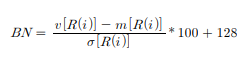

* 이미지 생성하기
  1. 빈 넘파이 열을 만든다: 변수 개수에 맞춰서
  2. 식에 따라 변수의 숫자 값을 변수 셀 순서에 맞춰서 넣는다
  3. 이를 이미지로 변환한다    
https://supermemi.tistory.com/139

* 이미지 밝기 조절    
https://lucathree.github.io/python/day44/
참고

- train에서 credit은 따로 빼고 만들어야하나?

In [ ]:
train = pd.read_csv('train_img.csv', index_col=0)
test = pd.read_csv('test_img.csv', index_col=0)

In [ ]:
train_credit = pd.read_csv('train_final.csv', index_col=0)
train_credit = train_credit['credit']

correlated method로 변수배치한 결과 반영하기

In [ ]:
train = train[['begin_month','income_total', 'income_type_Commercial associate', 'family_type_Married','DAYS_EMPLOYED','income_type_Pensioner', 'child_family', 'ID','Age']]
test = test[['begin_month','income_total', 'income_type_Commercial associate', 'family_type_Married','DAYS_EMPLOYED','income_type_Pensioner', 'child_family', 'ID','Age']]

In [ ]:
train.head()

begin_month  income_total  income_type_Commercial associate  \
0         -6.0     12.218500                                 1   
1         -5.0     12.419170                                 1   
2        -22.0     13.017005                                 0   
3        -37.0     12.218500                                 1   
4        -26.0     11.967187                                 0   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0                    1       8.457231                      0     -0.420886   
1                    0       7.339538                      0      0.984226   
2                    1       8.397057                      0     -0.420886   
3                    1       7.645876                      0     -0.420886   
4                    1       7.652071                      0     -0.420886   

       ID  Age  
0  3096.0   38  
1  7301.0   31  
2  5063.0   52  
3  3128.0   41  
4  1917.0   41

In [ ]:
test.head()

begin_month  income_total  income_type_Commercial associate  \
0        -60.0     11.630717                                 0   
1        -36.0     11.813037                                 0   
2        -40.0     11.147253                                 0   
3        -41.0     11.630717                                 1   
4         -8.0     12.323860                                 0   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0                    0       0.000000                      1     -0.428573   
1                    1       9.067739                      0     -0.428573   
2                    1       5.379897                      0     -0.428573   
3                    1       7.836370                      0     -0.428573   
4                    1       9.146868                      0     -0.428573   

       ID  Age  
0   306.0   60  
1   810.0   51  
2  3429.0   43  
3   226.0   52  
4  2387.0   48

In [ ]:
print(train.shape, test.shape)

(26457, 9) (10000, 9)


BN 구하기

In [ ]:
train.describe()

begin_month  income_total  income_type_Commercial associate  \
count  26457.000000  26457.000000                      26457.000000   
mean     -26.123294     12.022074                          0.234418   
std       16.559550      0.480823                          0.423643   
min      -60.000000     10.203629                          0.000000   
25%      -39.000000     11.707678                          0.000000   
50%      -24.000000     11.967187                          0.000000   
75%      -12.000000     12.323860                          0.000000   
max        0.000000     14.269766                          1.000000   

       family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  \
count         26457.000000   26457.000000           26457.000000   
mean              0.687757       6.201575               0.168160   
std               0.463417       2.938818               0.374015   
min               0.000000       0.000000               0.000000   
25%               0.000000       6.003887               0.000000   
50%               1.000000       7.338888               0.000000   
75%               1.000000       8.056110               0.000000   
max               1.000000       9.662244               1.000000   

       child_family            ID           Age  
count  2.645700e+04  26457.000000  26457.000000  
mean   4.458181e-17   4403.506671     43.213478  
std    1.151343e+00   2518.686247     11.513590  
min   -1.203536e+00      0.000000     21.000000  
25%   -4.208862e-01   2231.000000     34.000000  
50%   -4.208862e-01   4392.000000     42.000000  
75%    9.842259e-01   6622.000000     53.000000  
max    2.549359e+01   8758.000000     68.000000

In [ ]:
test.describe()

begin_month  income_total  income_type_Commercial associate  \
count  10000.000000  10000.000000                      10000.000000   
mean     -26.272400     12.010167                          0.228800   
std       16.348557      0.479566                          0.420081   
min      -60.000000     10.203629                          0.000000   
25%      -39.000000     11.707678                          0.000000   
50%      -25.000000     11.967187                          0.000000   
75%      -12.000000     12.323860                          0.000000   
max        0.000000     14.269766                          1.000000   

       family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  \
count         10000.000000   10000.000000           10000.000000   
mean              0.685200       6.198295               0.170300   
std               0.464459       2.953400               0.375915   
min               0.000000       0.000000               0.000000   
25%               0.000000       6.011267               0.000000   
50%               1.000000       7.361375               0.000000   
75%               1.000000       8.056110               0.000000   
max               1.000000       9.658929               1.000000   

       child_family            ID           Age  
count  1.000000e+04  10000.000000  10000.000000  
mean  -7.602807e-17   2827.857900     43.384300  
std    1.124768e+00   1606.638125     11.501663  
min   -1.213116e+00      0.000000     20.000000  
25%   -4.285734e-01   1450.000000     34.000000  
50%   -4.285734e-01   2839.500000     42.000000  
75%    9.760442e-01   4239.000000     53.000000  
max    6.594514e+00   5584.000000     68.000000

데이터 가공 시작

In [ ]:
train_stat = train.describe()
train_stat

begin_month  income_total  income_type_Commercial associate  \
count  26457.000000  26457.000000                      26457.000000   
mean     -26.123294     12.022074                          0.234418   
std       16.559550      0.480823                          0.423643   
min      -60.000000     10.203629                          0.000000   
25%      -39.000000     11.707678                          0.000000   
50%      -24.000000     11.967187                          0.000000   
75%      -12.000000     12.323860                          0.000000   
max        0.000000     14.269766                          1.000000   

       family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  \
count         26457.000000   26457.000000           26457.000000   
mean              0.687757       6.201575               0.168160   
std               0.463417       2.938818               0.374015   
min               0.000000       0.000000               0.000000   
25%               0.000000       6.003887               0.000000   
50%               1.000000       7.338888               0.000000   
75%               1.000000       8.056110               0.000000   
max               1.000000       9.662244               1.000000   

       child_family            ID           Age  
count  2.645700e+04  26457.000000  26457.000000  
mean   4.458181e-17   4403.506671     43.213478  
std    1.151343e+00   2518.686247     11.513590  
min   -1.203536e+00      0.000000     21.000000  
25%   -4.208862e-01   2231.000000     34.000000  
50%   -4.208862e-01   4392.000000     42.000000  
75%    9.842259e-01   6622.000000     53.000000  
max    2.549359e+01   8758.000000     68.000000

In [ ]:
train_stat = train.describe()
train_mean = train_stat.iloc[1,:]
train_std = train_stat.iloc[2,:]

In [ ]:
test_stat = test.describe()
test_mean = test_stat.iloc[1,:]
test_std = test_stat.iloc[2,:]

- 위 데이터를 각 열에 대해서 한 번에 뺄 수 있는 방법을 찾기

각 이미지 변수에 대해서 해야해서 다시 하기!

1. 각 열에 대해서 통계량 계산하기
2. 각 통계량에 대해서 iteration 돌면서 array로 만들기
3. array를 모두 이미지로 변형해서 저장하기

In [ ]:
train_img = (train - train_mean)/ train_std
test_img = (test - test_mean)/ test_std

In [ ]:
train_img.head(3)

begin_month  income_total  income_type_Commercial associate  \
0     1.215208      0.408521                          1.807141   
1     1.275596      0.825867                          1.807141   
2     0.248998      2.069225                         -0.553339   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0             0.673783       0.767539              -0.449607     -0.365561   
1            -1.484101       0.387218              -0.449607      0.854850   
2             0.673783       0.747063              -0.449607     -0.365561   

         ID       Age  
0 -0.519122 -0.452811  
1  1.150399 -1.060788  
2  0.261840  0.763144

In [ ]:
test_img.head(3)

begin_month  income_total  income_type_Commercial associate  \
0    -2.063032     -0.791236                         -0.544657   
1    -0.595013     -0.411059                         -0.544657   
2    -0.839683     -1.799364                         -0.544657   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0            -1.475264      -2.098698               2.207148     -0.381033   
1             0.677777       0.971573              -0.453028     -0.381033   
2             0.677777      -0.277103              -0.453028     -0.381033   

         ID       Age  
0 -1.569649  1.444635  
1 -1.255950  0.662139  
2  0.374161 -0.033413

In [ ]:
train_img = train_img*100
test_img = test_img*100

In [ ]:
train_img.head(3)

begin_month  income_total  income_type_Commercial associate  \
0   121.520781     40.852075                        180.714098   
1   127.559592     82.586725                        180.714098   
2    24.899797    206.922534                        -55.333934   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0            67.378314      76.753860             -44.960663    -36.556105   
1          -148.410096      38.721795             -44.960663     85.485030   
2            67.378314      74.706321             -44.960663    -36.556105   

           ID         Age  
0  -51.912249  -45.281085  
1  115.039868 -106.078803  
2   26.184021   76.314351

In [ ]:
test_img.head(3)

begin_month  income_total  income_type_Commercial associate  \
0  -206.303219    -79.123557                        -54.465662   
1   -59.501275    -41.105858                        -54.465662   
2   -83.968266   -179.936385                        -54.465662   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0          -147.526351    -209.869801             220.714825    -38.103271   
1            67.777722      97.157333             -45.302802    -38.103271   
2            67.777722     -27.710346             -45.302802    -38.103271   

           ID         Age  
0 -156.964898  144.463462  
1 -125.595046   66.213906  
2   37.416148   -3.341256

In [ ]:
train_img_3 = train_img + 128
test_img_3 = test_img + 128

In [ ]:
train_img_3.head(3)

begin_month  income_total  income_type_Commercial associate  \
0   249.520781    168.852075                        308.714098   
1   255.559592    210.586725                        308.714098   
2   152.899797    334.922534                         72.666066   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0           195.378314     204.753860              83.039337     91.443895   
1           -20.410096     166.721795              83.039337    213.485030   
2           195.378314     202.706321              83.039337     91.443895   

           ID         Age  
0   76.087751   82.718915  
1  243.039868   21.921197  
2  154.184021  204.314351

In [ ]:
test_img_3.head(3)

begin_month  income_total  income_type_Commercial associate  \
0   -78.303219     48.876443                         73.534338   
1    68.498725     86.894142                         73.534338   
2    44.031734    -51.936385                         73.534338   

   family_type_Married  DAYS_EMPLOYED  income_type_Pensioner  child_family  \
0           -19.526351     -81.869801             348.714825     89.896729   
1           195.777722     225.157333              82.697198     89.896729   
2           195.777722     100.289654              82.697198     89.896729   

           ID         Age  
0  -28.964898  272.463462  
1    2.404954  194.213906  
2  165.416148  124.658744

In [ ]:
train_img = train_img.applymap(lambda x:255 if (x >= 255) else x)
test_img = test_img.applymap(lambda x:255 if (x >= 255) else x)

In [ ]:
train_img = train_img.applymap(lambda x:0 if (x <0) else x)
test_img = test_img.applymap(lambda x:0 if (x <0) else x)

array로 만들기

In [ ]:
# test code
np.array([train_img.iloc[0,:]]).reshape((3,3))

array([[121.52078058,  40.85207547, 180.7140983 ],
       [ 67.37831397,  76.75386046,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [ ]:
data = 0
train_img_list = []
for i in range(len(train_img)):
  data = np.array([train_img.iloc[i,:]]).reshape((3,3))
  train_img_list.append(data)

In [ ]:
data = 0
test_img_list = []
for i in range(len(test_img)):
  data = np.array([test_img.iloc[i,:]]).reshape((3,3))
  test_img_list.append(data)

In [ ]:
print(len(train_img_list))
print(len(test_img_list))

26457
10000


이미지 생성 시작

In [ ]:
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import numpy as np

In [ ]:
pip install opencv-python

In [ ]:
import cv2
cv2.__version__    # 4.1.2

'4.7.0'

In [ ]:
train_img_list[0]

array([[121.52078058,  40.85207547, 180.7140983 ],
       [ 67.37831397,  76.75386046,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [ ]:
test_img_list[0]

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        , 220.71482519],
       [  0.        ,   0.        , 144.4634623 ]])

array를 하나씩 뽑아서 이미지로 저장하기

In [ ]:
train_to_img = []
for i in range(len(train_img_list)):
  data1 = Image.fromarray(train_img_list[i])
  train_to_img.append(data1)

In [ ]:
test_to_img = []
for i in range(len(test_img_list)):
  data2 = Image.fromarray(test_img_list[i])
  test_to_img.append(data2)

In [ ]:
train_to_img[:3]
# 데이터에 flot이 있어서 안 되는 것이라고 함;; 처음에도 그랬는데 왜 이번에는 안되는거지

[<PIL.Image.Image image mode=F size=3x3>,
 <PIL.Image.Image image mode=F size=3x3>,
 <PIL.Image.Image image mode=F size=3x3>]

이미지 잘 되어있나 확인

In [ ]:
train_to_img[9].show() # float이 있어서 이미지로 보여주지 않음

In [ ]:
train_to_img[9].resize((128,128)).show()

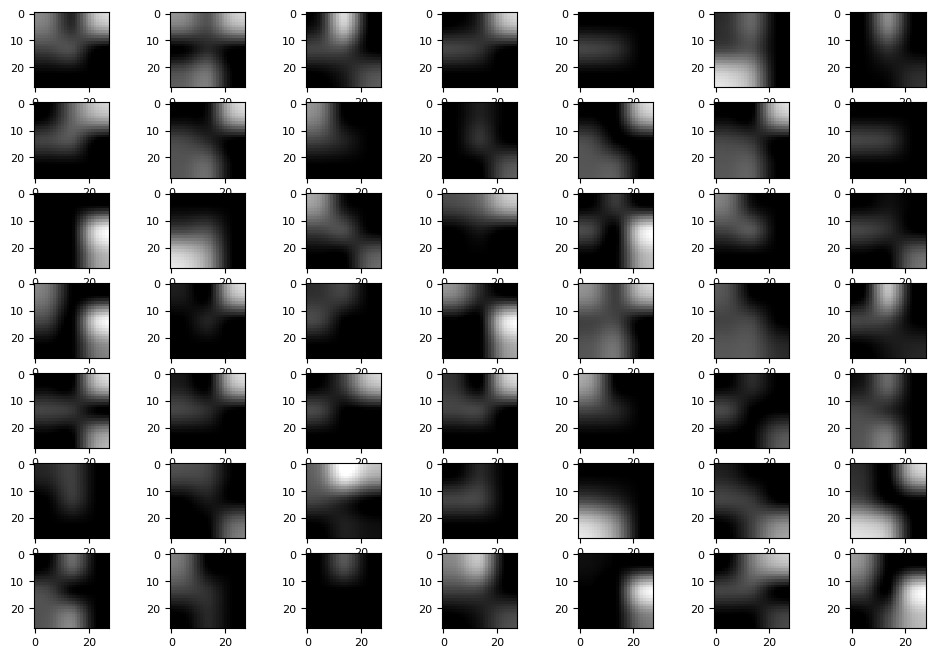

In [ ]:
plt.figure(figsize=(12,8))
count = 0

for i in range(49):
 count += 1
 plt.subplot(7,7,count)
 plt.imshow(train_to_img[i].resize((28,28)), cmap = plt.get_cmap('gray'), interpolation='nearest')
plt.show()

## 6. 모델링

* 위에서 이미지 변환하는 과정에서 피처임포턴스 기준 중요한 변수 9개만 뽑아서 이미지생성하는데 사용하기로함.
* 따라서 이미지 변환을 활용한 모델링과 그렇지 않은 모델링을 비교하기 위해 다른 모델에서도 변수 9개만 뽑아서 돌려본다.


### **Logistic Regression**

#### Ver. 변수 53개

In [ ]:
train = pd.read_csv('train_final.csv', index_col=0)
test = pd.read_csv('test_final2.csv', index_col=0)

전처리

In [ ]:
test.drop(['credit'], axis=1, inplace=True)

In [ ]:
features = train.drop(['credit'], axis=1)
target = train['credit']

In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, target)

기본 모델

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print(lr.score(train_features, train_labels))

0.639250075597218


In [ ]:
print(lr.score(test_features, test_labels))

0.6476190476190476


In [ ]:
lr_coef = pd.Series(lr.coef_[0], features.columns).sort_values(ascending=False)
lr_coef

begin_month                               2.254195e-03
child_family                              4.782149e-04
occyp_type_Pensioner                      9.463299e-05
income_type_Pensioner                     9.463299e-05
family_type_Civil marriage                7.329550e-05
occyp_type_Managers                       5.689372e-05
house_type_Municipal apartment            3.029298e-05
occyp_type_Accountants                    2.116185e-05
occyp_type_Laborers                       1.982541e-05
edu_type_Higher education                 1.142193e-05
occyp_type_IT staff                       7.916259e-06
occyp_type_Private service staff          6.848267e-06
occyp_type_Realty agents                  4.526129e-06
occyp_type_Cooking staff                  4.271698e-06
occyp_type_Low-skill Laborers             3.319234e-06
edu_type_Academic degree                  2.876684e-07
house_type_Co-op apartment               -2.470587e-06
income_type_Student                      -3.964376e-06
house_type

<Axes: ylabel='Feature'>

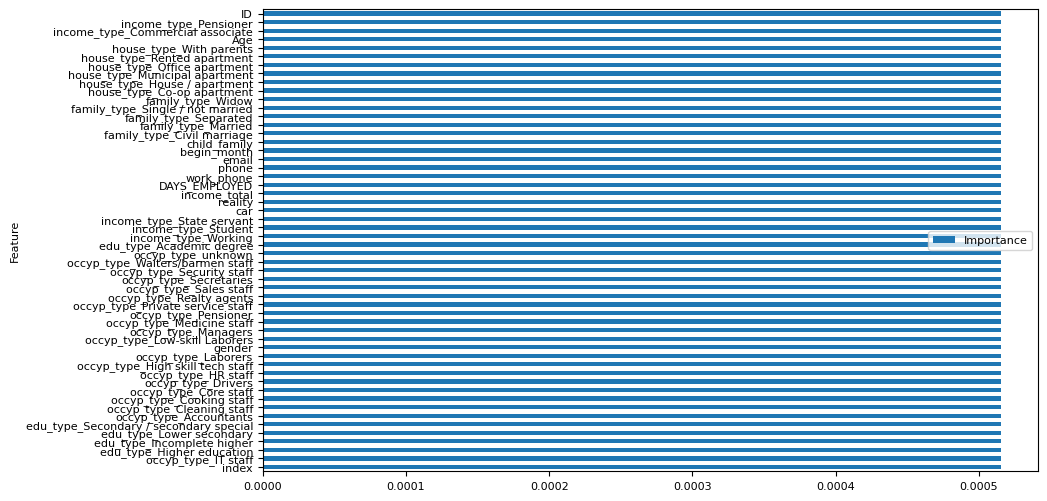

In [ ]:
# feature importance

avg_importance = np.mean(np.abs(lr_coef), axis=0)
feature_importance = pd.DataFrame({'Feature': train_features.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
from sklearn.metrics import log_loss

logloss = log_loss(test_labels, lr.predict_proba(test_features))
logloss

0.8574487949142867

In [ ]:
sub = pd.read_csv('sample_submission.csv', index_col=0)

In [ ]:
preds = lr.predict(test)

기본모델 정규화

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 0)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# 데이터에 정규화 적용
# 평균이 0이고 표준편차가 1인 분포를 따르도록 함
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
print(lr.score(X_train, y_train))

0.6418707791553271


In [ ]:
print(lr.score(X_test, y_test))

0.6473167044595616


In [ ]:
lr_coef = pd.Series(lr.coef_[0], features.columns).sort_values(ascending=False)
lr_coef

occyp_type_Low-skill Laborers             0.036687
begin_month                               0.036144
phone                                     0.035558
income_total                              0.033049
occyp_type_Laborers                       0.028161
occyp_type_HR staff                       0.026103
family_type_Civil marriage                0.025419
occyp_type_Core staff                     0.024143
car                                       0.020140
occyp_type_Managers                       0.018518
family_type_Married                       0.018013
occyp_type_Private service staff          0.016970
house_type_Municipal apartment            0.015302
Age                                       0.014494
income_type_State servant                 0.014006
income_type_Commercial associate          0.012425
gender                                    0.011300
edu_type_Secondary / secondary special    0.008291
occyp_type_unknown                        0.006239
occyp_type_Realty agents       

In [ ]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, lr.predict_proba(X_test))
logloss

0.858350172435058

In [ ]:
sub = pd.read_csv('sample_submission.csv', index_col=0)

In [ ]:
preds_n = lr.predict(test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


기본 모델_label

In [ ]:
train_le = pd.read_csv('train_le.csv', index_col=0)
test_le = pd.read_csv('test_le.csv', index_col=0)

In [ ]:
test_le.drop(['credit'], axis=1, inplace=True)

In [ ]:
features_le = train_le.drop(['credit'], axis=1)
target_le = train_le['credit']

In [ ]:
train_features_le, test_features_le, train_labels_le, test_labels_le = train_test_split(features_le, target_le)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_le = LogisticRegression()
lr_le.fit(train_features_le, train_labels_le)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print(lr_le.score(train_features_le, train_labels_le))

0.6441890938413466


In [ ]:
print(lr_le.score(test_features_le, test_labels_le))

0.6328042328042328


In [ ]:
lr_le_coef = pd.Series(lr_le.coef_[0], features_le.columns).sort_values(ascending=False)
lr_le_coef

begin_month      0.002618
child_family     0.000942
phone            0.000136
ID              -0.000006
car             -0.000520
work_phone      -0.000586
gender          -0.000681
email           -0.000811
reality         -0.001071
family_type     -0.002868
house_type      -0.003272
edu_type        -0.004737
Age             -0.004747
income_type     -0.006143
occyp_type      -0.012466
income_total    -0.016042
DAYS_EMPLOYED   -0.016164
dtype: float64

<Axes: ylabel='Feature'>

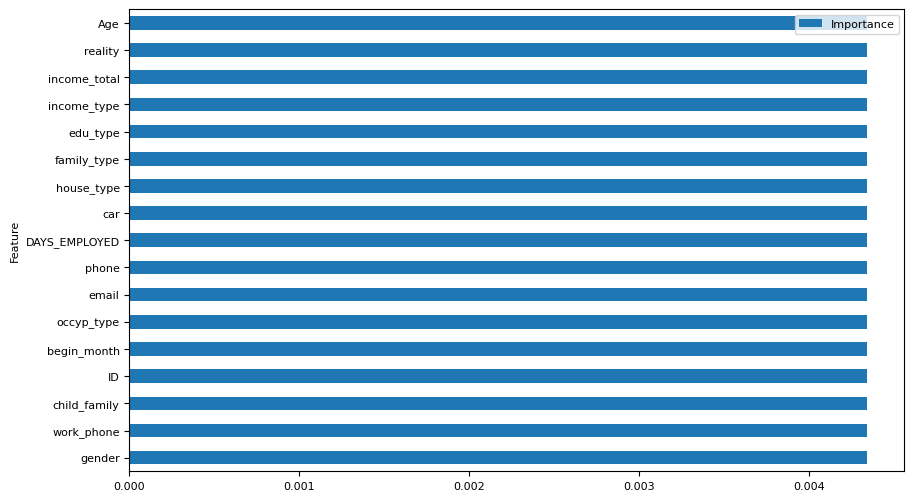

In [ ]:
# feature importance

avg_importance = np.mean(np.abs(lr_le_coef), axis=0)
feature_importance = pd.DataFrame({'Feature': train_features_le.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
logloss_le = log_loss(test_labels_le, lr_le.predict_proba(test_features_le))
logloss_le

0.8746601096428342

In [ ]:
sub = pd.read_csv('sample_submission.csv', index_col=0)

In [ ]:
preds_le = lr_le.predict(test_le)
sub['credit'] = preds_le

In [ ]:
sub.to_csv('submition_le.csv', index=False)

#### Ver. 변수 9개

In [ ]:
train = pd.read_csv('train_final.csv', index_col=0)
train_img = pd.read_csv('train_img.csv', index_col=0)
test_img = pd.read_csv('test_img.csv', index_col=0)

In [ ]:
features = train_img
target = train['credit']

In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, target)

기본 모델

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
print(lr.score(train_features, train_labels))

0.6409636125390585


In [ ]:
print(lr.score(test_features, test_labels))

0.6424792139077853


In [ ]:
lr_coef = pd.Series(lr.coef_[0], features.columns).sort_values(ascending=False)
lr_coef

child_family                        0.000497
income_type_Pensioner               0.000404
begin_month                         0.000385
ID                                 -0.000024
income_type_Commercial associate   -0.000230
family_type_Married                -0.000574
Age                                -0.008973
DAYS_EMPLOYED                      -0.010878
income_total                       -0.013008
dtype: float64

<Axes: ylabel='Feature'>

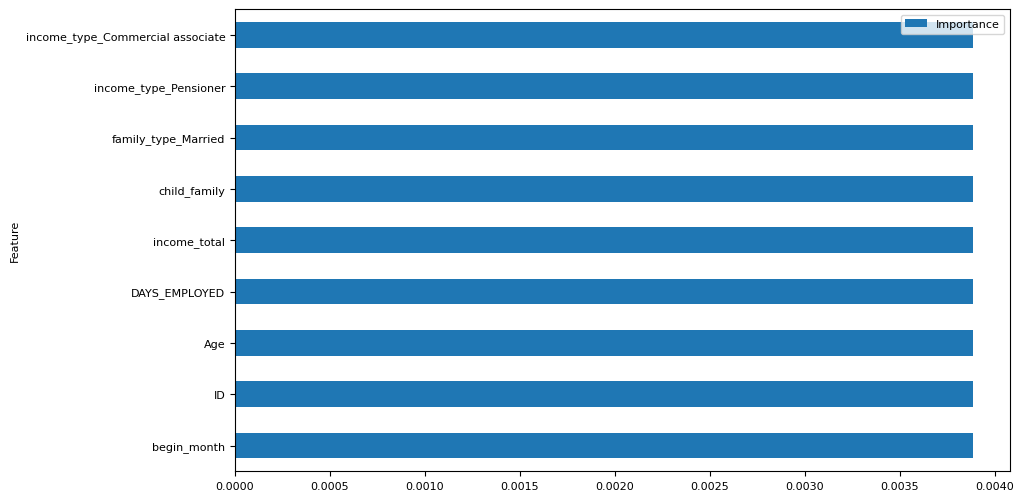

In [ ]:
# feature importance

avg_importance = np.mean(np.abs(lr_coef), axis=0)
feature_importance = pd.DataFrame({'Feature': train_features.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
from sklearn.metrics import log_loss

logloss = log_loss(test_labels, lr.predict_proba(test_features))
logloss

0.8571029191047516

### **Random Forest**

#### Ver. 변수 53개

In [ ]:
train = pd.read_csv('train_final.csv', index_col=0)
test = pd.read_csv('test_final2.csv', index_col=0)

In [ ]:
print(train.shape, test.shape)

(26457, 55) (10000, 55)


In [ ]:
test.drop(['index','credit'], axis=1, inplace =True)
train.drop('index', axis=1, inplace =True)

In [ ]:
train.head(3)

gender  car  reality  income_total  DAYS_EMPLOYED  work_phone  phone  \
0       1    0        0     12.218500       8.457231           0      0   
1       1    0        1     12.419170       7.339538           0      0   
2       0    1        1     13.017005       8.397057           0      1   

   email  begin_month  credit  ...  occyp_type_Medicine staff  \
0      0         -6.0     1.0  ...                          0   
1      1         -5.0     1.0  ...                          0   
2      0        -22.0     2.0  ...                          0   

   occyp_type_Pensioner  occyp_type_Private service staff  \
0                     0                                 0   
1                     0                                 0   
2                     0                                 0   

   occyp_type_Realty agents  occyp_type_Sales staff  occyp_type_Secretaries  \
0                         0                       0                       0   
1                         0                       0                       0   
2                         0                       0                       0   

   occyp_type_Security staff  occyp_type_Waiters/barmen staff  \
0                          0                                0   
1                          0                                0   
2                          0                                0   

   occyp_type_unknown      ID  
0                   1  3096.0  
1                   0  7301.0  
2                   0  5063.0  

[3 rows x 54 columns]

In [ ]:
test.head(3)

gender  car  reality  income_total  DAYS_EMPLOYED  work_phone  phone  \
0       0    1        0     11.630717       0.000000           0      1   
1       1    0        1     11.813037       9.067739           0      1   
2       1    0        1     11.147253       5.379897           1      1   

   email  begin_month  child_family  ...  occyp_type_Medicine staff  \
0      0        -60.0     -0.428573  ...                          0   
1      0        -36.0     -0.428573  ...                          0   
2      0        -40.0     -0.428573  ...                          0   

   occyp_type_Pensioner  occyp_type_Private service staff  \
0                     1                                 0   
1                     0                                 0   
2                     0                                 0   

   occyp_type_Realty agents  occyp_type_Sales staff  occyp_type_Secretaries  \
0                         0                       0                       0   
1                         0                       0                       0   
2                         0                       0                       0   

   occyp_type_Security staff  occyp_type_Waiters/barmen staff  \
0                          0                                0   
1                          0                                0   
2                          0                                0   

   occyp_type_unknown      ID  
0                   0   306.0  
1                   0   810.0  
2                   0  3429.0  

[3 rows x 53 columns]

분류랑 회귀 중 어떠한 것을 해야할까? 분류: 랜덤포레스트

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [ ]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 53) (26457, 1) (10000, 53)


train 데이터를 validation set과 train set으로 나눠줌

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

In [ ]:
print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(19842, 53)
(19842, 1)
Validation set: 
(6615, 53)
(6615, 1)


- 3:1 의 비율로 나눠졌음을 알 수 있음

In [ ]:
clf = RandomForestClassifier() # 라이브러리 로드
clf.fit(X_train, y_train) # train 데이터를 이용해서 모델 피팅
y_pred = clf.predict_proba(X_val) # validations set을 이용해 예측을 미리 해보기: 분류에 대한 확률로 예측(predict_proba)
y_pred

array([[0.02, 0.18, 0.8 ],
       [0.02, 0.  , 0.98],
       [0.02, 0.15, 0.83],
       ...,
       [0.04, 0.07, 0.89],
       [0.01, 0.79, 0.2 ],
       [0.02, 0.3 , 0.68]])

In [ ]:
print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}") # validation set의 예측과 실제 validation set 결과 값을 이용해서 로그로스를 계산

log_loss: 1.0491626893080086


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55) # 5개의 fold로 나눠서 교차검증을 함
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)

        predictions=clf.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=clf.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:1.05763698666688
FOLD 1 : logloss:1.0742811678751616
FOLD 2 : logloss:1.073362627533732
FOLD 3 : logloss:0.9408465283343559
FOLD 4 : logloss:1.1032489435646642
Mean:1.0498752507949587


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission

In [ ]:
submission.iloc[:,1:]= pd.DataFrame(my_submission)

In [ ]:
submission.head()

In [ ]:
submission.to_csv('sub_fin.csv',index = False)

Feautre Importance

In [ ]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

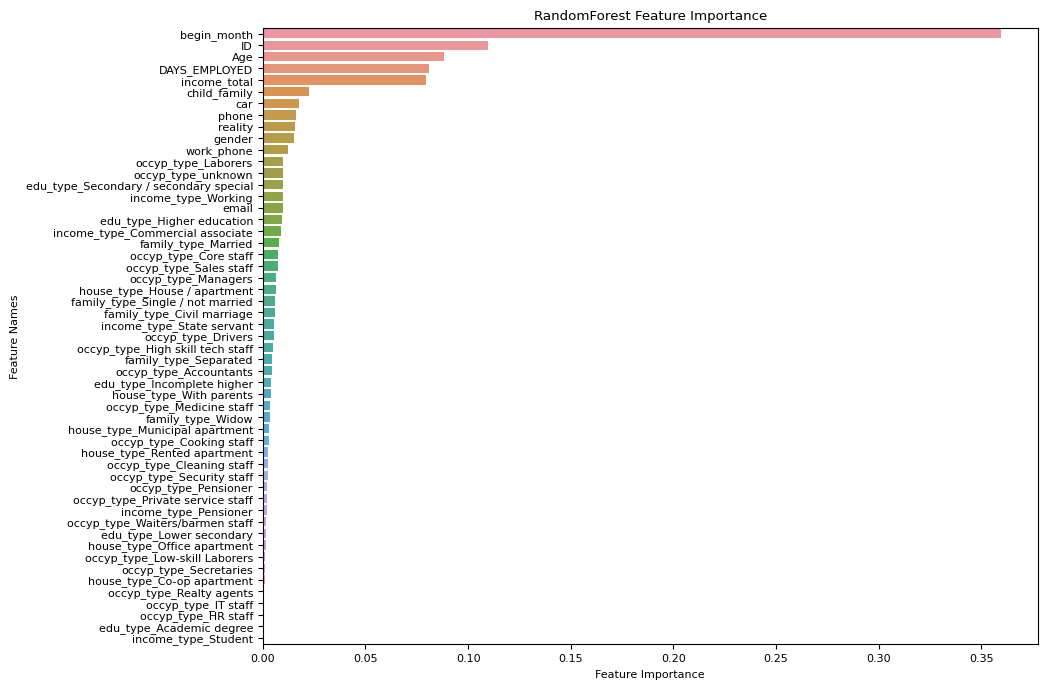

In [ ]:
plot_feature_importance(clf.feature_importances_,test_x.columns,'RandomForest')

#### Ver. 변수 9개

In [ ]:
train_credit = pd.read_csv('train_final.csv', index_col=0)

In [ ]:
train_credit['credit']

0        1.0
1        1.0
2        2.0
3        0.0
4        2.0
        ... 
26452    1.0
26453    2.0
26454    2.0
26455    2.0
26456    2.0
Name: credit, Length: 26457, dtype: float64

In [ ]:
train = pd.read_csv('train_img.csv', index_col=0)
test = pd.read_csv('test_img.csv', index_col=0)

In [ ]:
print(train.shape, test.shape)

(26457, 9) (10000, 9)


In [ ]:
train.head(3)

begin_month      ID  Age  DAYS_EMPLOYED  income_total  child_family  \
0         -6.0  3096.0   38       8.457231     12.218500     -0.420886   
1         -5.0  7301.0   31       7.339538     12.419170      0.984226   
2        -22.0  5063.0   52       8.397057     13.017005     -0.420886   

   family_type_Married  income_type_Pensioner  \
0                    1                      0   
1                    0                      0   
2                    1                      0   

   income_type_Commercial associate  
0                                 1  
1                                 1  
2                                 0

In [ ]:
test.head(3)

begin_month      ID  Age  DAYS_EMPLOYED  income_total  child_family  \
0        -60.0   306.0   60       0.000000     11.630717     -0.428573   
1        -36.0   810.0   51       9.067739     11.813037     -0.428573   
2        -40.0  3429.0   43       5.379897     11.147253     -0.428573   

   family_type_Married  income_type_Pensioner  \
0                    0                      1   
1                    1                      0   
2                    1                      0   

   income_type_Commercial associate  
0                                 0  
1                                 0  
2                                 0

분류랑 회귀 중 어떠한 것을 해야할까? 분류: 랜덤포레스트

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train_x=train
train_y=train_credit[['credit']]
test_x=test

In [ ]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 9) (26457, 1) (10000, 9)


train 데이터를 validation set과 train set으로 나눠줌

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

In [ ]:
print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(19842, 9)
(19842, 1)
Validation set: 
(6615, 9)
(6615, 1)


- 3:1 의 비율로 나눠졌음을 알 수 있음

In [ ]:
clf = RandomForestClassifier() # 라이브러리 로드
clf.fit(X_train, y_train) # train 데이터를 이용해서 모델 피팅
y_pred = clf.predict_proba(X_val) # validations set을 이용해 예측을 미리 해보기: 분류에 대한 확률로 예측(predict_proba)
y_pred

array([[0.3       , 0.17      , 0.53      ],
       [0.02      , 0.02      , 0.96      ],
       [0.06      , 0.02833333, 0.91166667],
       ...,
       [0.01      , 0.13      , 0.86      ],
       [0.01      , 0.92      , 0.07      ],
       [0.08      , 0.17      , 0.75      ]])

In [ ]:
print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}") # validation set의 예측과 실제 validation set 결과 값을 이용해서 로그로스를 계산

log_loss: 0.9284947868617467


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55) # 5개의 fold로 나눠서 교차검증을 함
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)

        predictions=clf.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")

        sub+=clf.predict_proba(test_x)


    mean_outcome=np.mean(outcomes)

    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.9285703202956186
FOLD 1 : logloss:0.9448689858448612
FOLD 2 : logloss:0.9683678431374172
FOLD 3 : logloss:0.9055337151770717
FOLD 4 : logloss:1.009561884316734
Mean:0.9513805497543405


In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission

In [ ]:
submission.iloc[:,1:]= pd.DataFrame(my_submission)

In [ ]:
submission.head()

In [ ]:
submission.to_csv('sub_9feature.csv',index = False)

Feautre Importance

In [ ]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

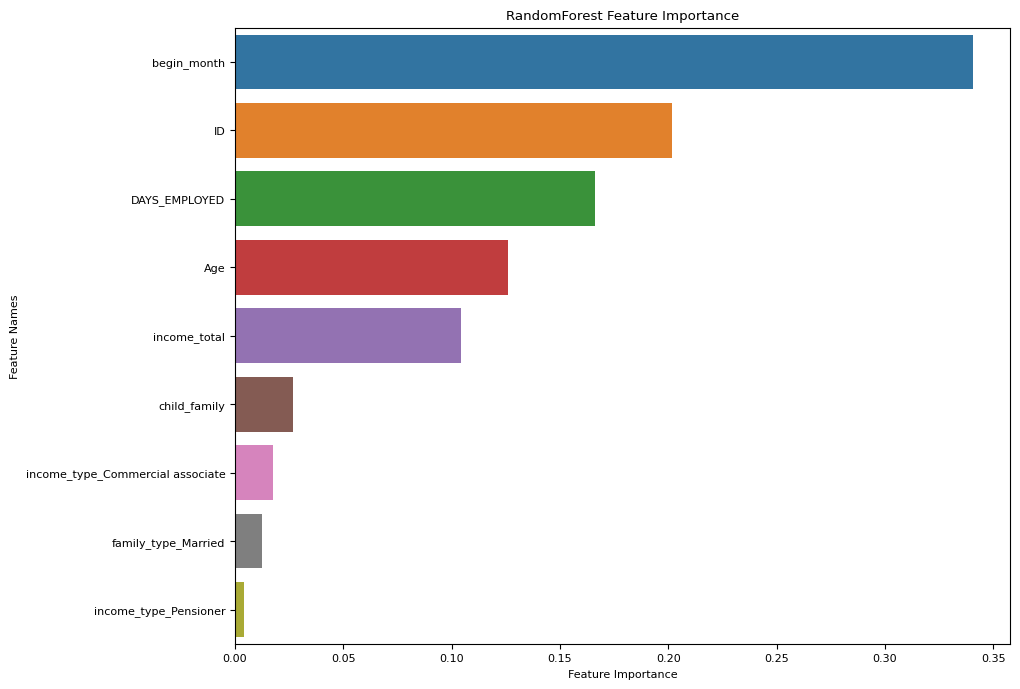

In [ ]:
plot_feature_importance(clf.feature_importances_,test_x.columns,'RandomForest')

### **Support Vector Machine**

#### Ver. 변수 53개

In [ ]:
train = pd.read_csv("train_ohe.csv", index_col=0)
test = pd.read_csv("test_ohe.csv", index_col=0)

In [ ]:
# X /y  데이터 분리

train_x=train.drop('credit', axis=1)
train_y=train[['credit']]

test_x=test.drop('credit', axis=1)

In [ ]:
# validation set TEST (생략 가능)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(19842, 53)
(19842, 1)
Validation set: 
(6615, 53)
(6615, 1)


In [ ]:
# svm 모델 학습
from sklearn.svm import SVC

svclassifier = SVC(probability=True, kernel = 'linear')
svclassifier.fit(X_train, y_train)

In [ ]:
# 검증
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = svclassifier.predict(X_val)

print("정확도 : ", accuracy_score(y_val,Y_pred))
print()
print(confusion_matrix(y_val,Y_pred))
print()
print(classification_report(y_val,Y_pred))

In [ ]:
my_sub = svclassifier.predict_proba(test_x)
my_sub

In [ ]:
sub.loc[:,:]=my_sub #my_submission
sub

In [ ]:
# 수집한 데이터를 화일로 저장

file_path =  "/content/gdrive/My Drive/Colab Notebooks/"

submission.to_csv(file_path+'baseline_submission4.csv', index=True)

Feature Importances

In [ ]:
# feature importance

pd.Series(abs(svclassifier.coef_[0]), index=train_x.columns).nlargest(10).plot(kind='barh')

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(svclassifier, X_val, y_val)

feature_names = train_x.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
feature_names = train_x.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx][-20:], perm_importance.importances_mean[sorted_idx][-20:])
plt.xlabel("Permutation Importance")

axes = plt.gca()
axes.xaxis.label.set_size(10)

#### Ver. 변수 9개

In [ ]:
train_img = pd.read_csv('train_img.csv', index_col=0)
test_img = pd.read_csv('test_img.csv', index_col=0)

In [ ]:
# X /y  데이터 분리

train_x=train_img
train_y=train_y

test_x=test_img

In [ ]:
# validation set

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

In [ ]:
# svm 모델 학습
from sklearn.svm import SVC

svclassifier = SVC(probability=True, kernel = 'linear')
svclassifier.fit(X_train, y_train)

In [ ]:
# 검증

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = svclassifier.predict(X_val)

print("정확도 : ", accuracy_score(y_val,Y_pred))
print()
print(confusion_matrix(y_val,Y_pred))
print()
print(classification_report(y_val,Y_pred))

In [ ]:
my_sub = svclassifier.predict_proba(test_x)
my_sub

In [ ]:
sub.loc[:,:]=my_sub #my_submission
sub

In [ ]:
# 수집한 데이터를 화일로 저장

file_path =  "/content/gdrive/My Drive/Colab Notebooks/"

submission.to_csv(file_path+'baseline_submission_svm9.csv', index=True)

### **DNN**

#### Ver. 변수 53개

In [ ]:
train=pd.read_csv('train_ohe.csv', index_col=0)
test=pd.read_csv('test_ohe.csv', index_col=0)
submission=pd.read_csv('/sample_submission.csv', index_col=0)

In [ ]:
test=test.drop('credit', axis=1)

모델링

In [ ]:
# OneHotEncoder
train = pd.get_dummies(data = train, columns = ['credit'], prefix = ['credit'])

In [ ]:
X_train = train.iloc[:, :-3]
y_train = train.iloc[:,-3:]

In [ ]:
X = train.iloc[:, :-3]
y = train.iloc[:,-3:]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle = True, random_state = 42)

In [ ]:
train.shape

모델 1

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model = tf.keras.Sequential([
    # hidden layer
    tf.keras.layers.Dense(units=48, activation='relu', input_shape=(52,)), # input_shape = number of feature
    tf.keras.layers.Dense(units=24, activation='relu'),
    tf.keras.layers.Dense(units=12, activation='relu'),

    # output layer
    tf.keras.layers.Dense(units=3, activation='softmax')
])
# model compile
# 분류 문제의 경우 손실함수는 categorical crossentropy
# 분류 문제는 정확도로 퍼포먼스를 측정하기 때문에 metrics=['accuracy']를 반드시 설정

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.25,verbose = 1,callbacks=[early_stop])

In [ ]:
# 다항 분류 모델 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Log Loss:", loss)

모델 2

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model1 = tf.keras.Sequential([
    # hidden layer
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=(52,), kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.2),

    # hidden layer
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dropout(0.2),

    # output layer
    tf.keras.layers.Dense(units=3, activation='softmax')
])


model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model1.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.25,verbose = 1,callbacks=[early_stop])

In [ ]:
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
print("Log Loss:", loss)

submission

In [ ]:
X_test.shape

In [ ]:
test.shape

In [ ]:
pred=model1.predict(test)

In [ ]:
submission.iloc[:, 0:] = pred

In [ ]:
submission.to_csv('/content/drive/MyDrive/학회/submission2.csv')

모델 3

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model2 = tf.keras.Sequential([
    # hidden layer
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=(52,)),
    tf.keras.layers.BatchNormalization(),

    # hidden layer
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.BatchNormalization(),

    # output layer
    tf.keras.layers.Dense(units=3, activation='softmax')
])


model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model2.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.25,verbose = 1,callbacks=[early_stop])

In [ ]:
loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)
print("Log Loss:", loss)

#### Ver. 변수 9개

In [ ]:
train_img=pd.read_csv('/content/drive/MyDrive/OB 1조/방학프로젝트/data/train_img.csv', index_col=0)

In [ ]:
train_img = train[['Age','income_total','gender', 'reality', 'begin_month', 'ID','DAYS_EMPLOYED','child_family','car']]

In [ ]:
train_img['credit']=train['credit']

In [ ]:
train_img.head()

In [ ]:
# OneHotEncoder
train_img = pd.get_dummies(data = train_img, columns = ['credit'], prefix = ['credit'])

In [ ]:
X = train_img.iloc[:, :-3]
y = train_img.iloc[:,-3:]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle = True, random_state = 42)

In [ ]:
train_img.shape

- 모델

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model_9 = tf.keras.Sequential([
    # hidden layer
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=(9,), kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.2),

    # hidden layer
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dropout(0.2),

    # output layer
    tf.keras.layers.Dense(units=3, activation='softmax')
])


model_9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),loss='categorical_crossentropy', metrics=['accuracy'])
model_9.summary()

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model_9.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.25,verbose = 1,callbacks=[early_stop])

In [ ]:
loss, accuracy = model_9.evaluate(X_test, y_test, verbose=0)
print("Log Loss:", loss)

변수 재선택

In [ ]:
train.head()

In [ ]:
columns=['credit','gender', 'car', 'reality', 'income_total', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'begin_month', 'ID',
       'child_family', 'Age', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'edu_type_Academic degree',
       'edu_type_Higher education', 'edu_type_Incomplete higher',
       'edu_type_Lower secondary', 'edu_type_Secondary / secondary special',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp_type_Cooking staff', 'occyp_type_Core staff',
       'occyp_type_Drivers', 'occyp_type_HR staff',
       'occyp_type_High skill tech staff', 'occyp_type_IT staff',
       'occyp_type_Laborers', 'occyp_type_Low-skill Laborers',
       'occyp_type_Managers', 'occyp_type_Medicine staff',
       'occyp_type_Pensioner', 'occyp_type_Private service staff',
       'occyp_type_Realty agents', 'occyp_type_Sales staff',
       'occyp_type_Secretaries', 'occyp_type_Security staff',
       'occyp_type_Waiters/barmen staff']

train.columns=columns

In [ ]:
pip install sm

In [ ]:
import statsmodels.api as sm

In [ ]:
## 전진 단계별 선택법
variables = train.columns[1:].tolist() ## 설명 변수 리스트

y = train['credit'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.00000000001
sl_remove = 0.00000000001

sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = train[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = train[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break

        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
len(selected_variables)

In [ ]:
print(selected_variables)

In [ ]:
['gender',
 'occyp_type_Laborers',
 'occyp_type_Drivers',
 'reality',
 'occyp_type_Security staff',
 'occyp_type_Low-skill Laborers',
 'occyp_type_Managers',
 'Age',
 'income_total',
 'occyp_type_Accountants',
 'family_type_Widow',
 'occyp_type_Sales staff',
 'occyp_type_Medicine staff',
 'occyp_type_Core staff',
 'income_type_Working',
 'family_type_Separated',
 'occyp_type_Private service staff']

In [ ]:
test_img1 = test[['Age','income_total','gender', 'reality', 'occyp_type_Laborers',
 'occyp_type_Drivers','occyp_type_Accountants', 'occyp_type_Sales staff', 'income_type_Working' ]]

train_img1 = train[['Age','income_total','gender', 'reality', 'occyp_type_Laborers',
 'occyp_type_Drivers','occyp_type_Accountants', 'occyp_type_Sales staff', 'income_type_Working' ]]

In [ ]:
test_img1.to_csv('/content/drive/MyDrive/OB 1조/방학프로젝트/data/test_img1.csv')
train_img1.to_csv('/content/drive/MyDrive/OB 1조/방학프로젝트/data/train_img1.csv')

### **CNN**

라이브러리 로드

In [ ]:
# import library
import sys
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical, plot_model
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# hyperparameter
batch_size = 128
num_classes = 3
epochs = 12

데이터 확인

In [ ]:
train = pd.read_csv('train_img.csv', index_col=0)
test = pd.read_csv('test_img.csv', index_col=0)

In [ ]:
train_credit = pd.read_csv('train_final.csv', index_col=0)

In [ ]:
train_credit = train_credit['credit']

In [ ]:
train_to_img[:3]

In [ ]:
plt.figure(figsize=(12,8))
count = 0

for i in range(9):
 count += 1
 plt.subplot(3,3,count)
 plt.imshow(train_to_img[i].resize((28,28)), cmap = plt.get_cmap('gray'), interpolation='nearest')
plt.show()

이미지를 model에 넣기 위해 각 pixel의 값을 숫자로 변형    
* 이미 array로 변환된 것을 사용

In [ ]:
train_img.head()

In [ ]:
test_img.head()

데이터 정규화

In [ ]:
train_img_normal = train_img.applymap(lambda x:x/255)
test_img_normal = test_img.applymap(lambda x:x/255)

In [ ]:
train_img_normal.head()

In [ ]:
test_img_normal.head()

In [ ]:
data = 0
train_img_normal_list = []
for i in range(len(train_img_normal)):
  data = np.array([train_img_normal.iloc[i,:]]).reshape((3,3))
  train_img_normal_list.append(data)

In [ ]:
data1 = 0
test_img_normal_list = []
for i in range(len(test_img_normal)):
  data1 = np.array([test_img_normal.iloc[i,:]]).reshape((3,3))
  test_img_normal_list.append(data1)

In [ ]:
train_img_normal_array = np.asarray(train_img_normal_list)
test_img_normal_array = np.asarray(test_img_normal_list)

In [ ]:
y_train = to_categorical(train_credit, num_classes)

모델

In [ ]:
# convolutional nueral network
model = keras.Sequential([
 layers.Conv2D(32, kernel_size = (2, 2), strides = 1, activation = 'relu', input_shape = (3,3,1)),

 layers.Conv2D(64, kernel_size = (2, 2), activation = 'relu'),

 layers.Flatten(),
 layers.Dropout(0.5),
 layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_img_normal_array, y_train, batch_size=batch_size, epochs=10, verbose=1 ) # epochs 조정 # validation_data=(x_test, y_test)

In [ ]:
y_pred=model.predict(test_img_normal_array)

In [ ]:
len(y_pred)

In [ ]:
train_img_normal_array

In [ ]:
test_img_normal_array

제출파일 생성

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission

In [ ]:
submission.iloc[:,1:]= pd.DataFrame(y_pred) # 모든 test 데이터를 같은 확률로 예측한 것 같음

In [ ]:
submission.head()

In [ ]:
submission.to_csv('sub_cnn.csv',index = False)

confusion matrix

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict(x_test)
ypred_class=np.argmax(y_pred,axis=1)
ytest_class=np.argmax(y_test,axis=1)
print(ypred_class.size)
print(ytest_class.size)

In [ ]:
conf_mat=confusion_matrix(ytest_class,ypred_class)
print(conf_mat)

In [ ]:
label = range(3)
import pandas as pd
table = pd.DataFrame(conf_mat, columns = label, index = label)
table

오분류 예시

In [ ]:
misclassified=np.where(ypred_class!=ytest_class)
aa=np.asarray(misclassified)
print(misclassified)
print(len(misclassified[0]))

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger
for i in range(16):
 plt.subplot(4,4,i+1)
 plt.imshow(x_test[aa[0,i]].reshape(28, 28), cmap='gray', interpolation='none')
 plt.title("True{},Pred{}".format(ytest_class[aa[0,i]],ypred_class[aa[0,i]]))
plt.tight_layout()

## 7. XAI (설명가능한 인공지능) - shap

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
explainer=shap.DeepExplainer(model,train)

In [ ]:
shap_values=explainer.shap_values(X_train)

In [ ]:
shap.plots.waterfall(shap_values[0])